# ML regression model as a surroage model

In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import os
from parameters import parameters as pm
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

## Load data

* q_data: $q \in [0.1,5]^4$

* y_data: $\alpha^{v},\beta^{v},\alpha^{max},\beta^{max},\alpha^{min},\beta^{min}$ standardization

* train:test=9:1  

* 5-fold cross validation, at each training set, 20% is used for validation

In [2]:
df=pd.read_excel(pm.file_datasets,index_col=0)

In [3]:
df.columns

Index(['q1', 'q2', 'q3', 'q4', 'alpha_vol', 'beta_vol', 'alpha_max',
       'beta_max', 'alpha_min', 'beta_min'],
      dtype='object')

In [4]:
df.columns=['q1', 'q2', 'q3', 'q4', r'$\alpha^v$', r'$\beta^v$', r'$\alpha^1$',
       r'$\beta^1$', r'$\alpha^2$', r'$\beta^2$']

In [5]:
df.describe()

q1           q2           q3           q4   $\alpha^v$  \
count  9997.000000  9997.000000  9997.000000  9997.000000  9997.000000   
mean      2.600700     2.600554     2.599693     2.599807    15.094456   
std       1.385338     1.385518     1.385785     1.385893     6.036963   
min       0.200084     0.200386     0.200090     0.200222     0.561585   
25%       1.401405     1.400876     1.399161     1.399617    10.678713   
50%       2.600653     2.600804     2.599831     2.599082    15.366682   
75%       3.800111     3.800463     3.799689     3.800125    19.484902   
max       4.999808     4.999766     4.999649     4.999584    29.369184   

         $\beta^v$   $\alpha^1$    $\beta^1$   $\alpha^2$    $\beta^2$  
count  9997.000000  9997.000000  9997.000000  9997.000000  9997.000000  
mean      1.092729   123.085574     1.331359    56.525405     1.226724  
std       0.150210    46.114824     0.171567    22.556580     0.183597  
min       0.976145     9.008910     1.003005     4.666916     1.000099  
25%       1.011990    93.677995     1.228542    41.438695     1.118608  
50%       1.031559   121.284121     1.274907    55.800434     1.155044  
75%       1.093286   150.709236     1.356900    70.234569     1.242047  
max       1.806483   452.741789     2.312083   193.279605     2.221449

In [6]:
df.head(5)

q1        q2        q3        q4  $\alpha^v$  $\beta^v$  $\alpha^1$  \
0  4.961442  2.385522  2.896893  0.806421   20.223655   1.103777  175.209895   
1  2.509299  3.074866  0.972012  4.125319   16.398545   0.999593   51.617745   
2  1.773326  0.717280  1.926991  1.375933    5.623686   1.187663   81.553839   
3  1.550003  0.337619  1.263067  3.412958    3.454852   1.438510   86.902361   
4  4.681192  1.154233  0.885567  4.695532   16.217840   1.255864  160.651447   

   $\beta^1$  $\alpha^2$  $\beta^2$  
0   1.278621   77.992722   1.198342  
1   1.003269   38.960331   1.001141  
2   1.502992   31.950368   1.412077  
3   1.806967   33.457987   1.777304  
4   1.373127   83.251062   1.351132

In [7]:
feature_columns=[ r'$\alpha^v$', r'$\beta^v$', r'$\alpha^1$',
       r'$\beta^1$', r'$\alpha^2$', r'$\beta^2$']
for col in feature_columns:
    df[col]=(df[col]-df[col].mean())/df[col].std()

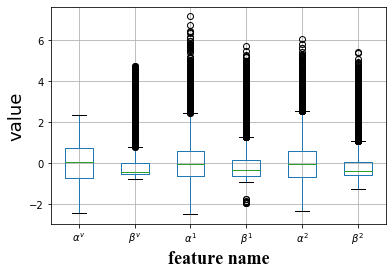

In [8]:
df[feature_columns].boxplot()
plt.gca().set_ylabel("value",fontdict={"size":18})
plt.gca().set_xlabel("feature name",fontdict={'family' : 'Times New Roman', 'size' : 18})
plt.show()

In [9]:
def box_plot_outliers(data_ser, box_scale):
    """
    remove some outliers
    :param data_ser: pandas.Series
    :param box_scale: the scale，
    :return:
    """
    iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
    val_low = data_ser.quantile(0.25) - iqr
    val_up = data_ser.quantile(0.75) + iqr
    low_index = data_ser[data_ser < val_low].index
    up_index = data_ser[data_ser > val_up].index

    return list(low_index) + list(up_index)

In [ ]:
# no need to run this part, just using the whole dataset
#error_index = []
#for col in feature_columns:
#    error_index += box_plot_outliers(df[col],box_scale=3)
#df=df.drop(error_index)

In [ ]:
#print(len(error_index))
#data_ser = df[feature_columns[0]]
#box_scale = 3
#iqr =(data_ser.quantile(0.75) - data_ser.quantile(0.25))
# print(iqr)

In [10]:
q_data,y_data=df.iloc[:,:4],df.iloc[:,4:]

In [11]:
train_size=int(0.9*len(q_data))

In [12]:
q_data_train,q_data_test=q_data.iloc[:train_size,:],q_data.iloc[train_size:,:]
y_data_train,y_data_test=y_data.iloc[:train_size,:],y_data.iloc[train_size:,:]

###  experimental data

In [13]:
q_data_exp,y_data_exp=df.iloc[-1,:4].values.reshape((1,-1)),df.iloc[-1,4:].values.reshape((1,-1))

In [14]:
q_data_train.shape,q_data_test.shape,q_data_exp.shape,y_data_exp.shape

((8997, 4), (1000, 4), (1, 4), (1, 6))

In [15]:
q_data_exp

array([[1., 1., 1., 1.]])

## Regression model
* [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=kneighborsregressor#)
* [xgboost](https://xgboost.readthedocs.io/en/latest/index.html)
* [muilt-layer perception](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlpregressor#)

##  Model trainning

* [Mulit-output regression model](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html?highlight=multioutputregressor#)  
This strategy consists of fitting one regressor per target. This is a simple strategy for extending regressors that do not natively support multi-target regression.
* [oof:](https://stackoverflow.com/questions/52396191/what-is-oof-approach-in-machine-learning)  
OOF simply stands for "Out-of-fold" and refers to a step in the learning process when using k-fold validation in which the predictions from each set of folds are grouped together into one group

In [ ]:
# Class to extend the Sklearn regressor
class SklearnHelper(object):
    def __init__(self, clf, params=None,isMuilt_reg=False):
        if isMuilt_reg: self.clf= MultiOutputRegressor (clf(**params))
        else: self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def score(self,x,y):
        return self.clf.score(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [16]:
def mse_loss(y_true,y_pred):
    return np.mean(np.square(y_true-y_pred))

X = q_data_train.values
y = y_data_train.values
X_test = q_data_test.values
y_test=y_data_test.values

In [17]:
X.shape,y.shape,X_test.shape,y_test.shape

((8997, 4), (8997, 6), (1000, 4), (1000, 6))

## Training the KNN model

In [102]:
fold = KFold(n_splits=5, shuffle=True, random_state=42)


def run_6sub_oof(clf, params):
    models = []
    pred = np.zeros(y_test.shape)
    oof = np.zeros(y.shape)
    for index, (train_idx, val_idx) in enumerate(fold.split(X)):
        x_tr, y_tr = X[train_idx,:], y[train_idx, :]
        x_val, y_val = X[val_idx,:], y[val_idx, :]

        tr_pred = np.zeros(y_tr.shape)
        val_pred = np.zeros(y_val.shape)
        test_pred = np.zeros(y_test.shape)
        for ix, para in enumerate (params):
            sub_model = clf(**para)
            sub_model.fit(x_tr, y_tr[:, ix])
            tr_pred[:, ix] = sub_model.predict(x_tr)
            val_pred[:, ix] = sub_model.predict(x_val)
            test_pred[:, ix] = sub_model.predict(X_test)
            models.append(sub_model) 
        oof[val_idx, :] = val_pred
        print('_'*100)
        print(index+1, 'Train: mse loss = {:.6f} r2_score = {:.6f}, Validation: mse loss = {:.6f} r2_score = {:.6f}'.format(
            mse_loss(y_tr, tr_pred), metrics.r2_score(y_tr, tr_pred),
            mse_loss(y_val, val_pred), metrics.r2_score(y_val, val_pred)))
        pred = pred+ test_pred/fold.n_splits
        del x_tr, y_tr, x_val, y_val
    print("#"*100)
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y, oof),metrics.r2_score(y_test, pred)))
    return models,oof,pred

In [19]:
# setup the training for the knn model
knn_params=[]
grid_params ={
            'n_neighbors': [1, 2, 4, 6, 8, 10, 12, 14],
            'p': [1, 2],
            'algorithm': ['ball_tree'],
            'weights': ['distance'],
            'metric': ['minkowski'],
            'n_jobs': [-1]
        }
knn_sub = GridSearchCV(KNeighborsRegressor(), grid_params, scoring = 'r2', n_jobs = -1, cv = 5)

In [20]:
## training the KNN model
for feat_flag in range(len(feature_columns)):
   print('GridSearch for feature %d' % feat_flag)
   knn_sub.fit(X, y[:, feat_flag])
   print(knn_sub.best_params_)
   knn_params.append(knn_sub.best_params_)
    

GridSearch for feature 0
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
GridSearch for feature 1
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
GridSearch for feature 2
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
GridSearch for feature 3
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
GridSearch for feature 4
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
GridSearch for feature 5
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_jobs': -1, 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}


In [21]:
# fit the modle and predict the output and others using the selected hyperparameters
knn_models=[]
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    knn_sub = KNeighborsRegressor(**knn_params[feat_flag])
    knn_sub.fit(X, y[:, feat_flag])
    knn_models.append(knn_sub)
    pred = knn_sub.predict(X_test)
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
Test: mse loss=0.004954 r2_score=0.995018
fitting feature 1
Test: mse loss=0.054941 r2_score=0.942119
fitting feature 2
Test: mse loss=0.045210 r2_score=0.948980
fitting feature 3
Test: mse loss=0.090652 r2_score=0.904052
fitting feature 4
Test: mse loss=0.024432 r2_score=0.973641
fitting feature 5
Test: mse loss=0.071231 r2_score=0.925703


In [22]:
## now we will re-train the knn model using 5-fold cross-validation
#knn_models, knn_oof, knn_pred = run_6sub_oof(KNeighborsRegressor, knn_params)
#joblib.dump(knn_models, "./Results/knn_models.m")


joblib.dump(knn_models, "./Results/knn_models.m")
## load the model 
knn_models = joblib.load("./Results/knn_models.m")

In [23]:
# model prediction for testing dataset
y_pred=np.zeros(y_test.shape)
for ix, model in enumerate(knn_models):
    y_pred[:, ix] += model.predict(X_test)

for feat_flag in range(len(feature_columns)):
    loss_test = mse_loss(y_test[:, feat_flag], y_pred[:, feat_flag])
    R2_test  = metrics.r2_score(y_test[:, feat_flag], y_pred[:, feat_flag])
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(loss_test, R2_test))

Test: mse loss=0.004954 r2_score=0.995018
Test: mse loss=0.054941 r2_score=0.942119
Test: mse loss=0.045210 r2_score=0.948980
Test: mse loss=0.090652 r2_score=0.904052
Test: mse loss=0.024432 r2_score=0.973641
Test: mse loss=0.071231 r2_score=0.925703


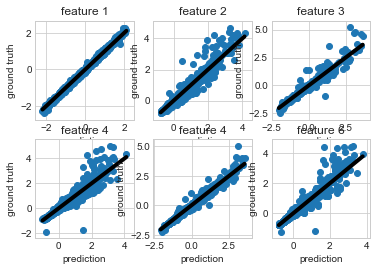

In [24]:
#plotting the predictions for the test dataset
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()

plt.subplot(2,3,2)
feat_flag = 1;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 2')
#plt.show()

plt.subplot(2,3,3)
feat_flag = 2;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 3')
#plt.show()

plt.subplot(2,3,4)
feat_flag = 3;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()


plt.subplot(2,3,5)
feat_flag = 4;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()

plt.subplot(2,3,6)
feat_flag = 5;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 6')
plt.show()

## Training the xgboost model

In [25]:
###### training the xgboost model
xgboost_params = []
grid_params = {
            'n_estimators' : [500, 1000, 2000],
            'max_depth' : [1, 2, 4, 6, 8, 16],
            'learning_rate' : [0.05, 0.1, 0.2],
            'objective' : ['reg:squarederror'],
            'booster' : ['gbtree'],
            'n_jobs' : [-1]
   }
xgboost_sub = GridSearchCV(XGBRegressor(), grid_params, scoring = 'r2', n_jobs = -1, cv = 5)

In [26]:
for feat_flag in range(len(feature_columns)):
    print('GridSearch for feature %d' % feat_flag)
    xgboost_sub.fit(X, y[:, feat_flag])
    print(xgboost_sub.best_params_)
    xgboost_params.append(xgboost_sub.best_params_)

GridSearch for feature 0
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 1
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 2
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 3
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 4
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}
GridSearch for feature 5
{'booster': 'gbtree', 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 2000, 'n_jobs': -1, 'objective': 'reg:squarederror'}


In [27]:
# predicting the output and others using the selected hyperparameters
xgboost_models = []
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    xgboost_sub = XGBRegressor(**xgboost_params[feat_flag])
    xgboost_sub.fit(X, y[:, feat_flag])
    xgboost_models.append(xgboost_sub)
    pred = xgboost_sub.predict(X_test)
    print('XGBoost Test: mse loss={:.6f} r2_score={:.6f}'.format(
            mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))
    

fitting feature 0
XGBoost Test: mse loss=0.000305 r2_score=0.999694
fitting feature 1
XGBoost Test: mse loss=0.000894 r2_score=0.999059
fitting feature 2
XGBoost Test: mse loss=0.006021 r2_score=0.993205
fitting feature 3
XGBoost Test: mse loss=0.017027 r2_score=0.981978
fitting feature 4
XGBoost Test: mse loss=0.001846 r2_score=0.998008
fitting feature 5
XGBoost Test: mse loss=0.009932 r2_score=0.989641


In [104]:
xgb_cv_models, xgb_cv_oof, xgb_cv_pred = run_6sub_oof(XGBRegressor, xgboost_params)

____________________________________________________________________________________________________
1 Train: mse loss = 0.000077 r2_score = 0.999922, Validation: mse loss = 0.002229 r2_score = 0.997934
____________________________________________________________________________________________________
2 Train: mse loss = 0.000080 r2_score = 0.999921, Validation: mse loss = 0.001589 r2_score = 0.998368
____________________________________________________________________________________________________
3 Train: mse loss = 0.000083 r2_score = 0.999918, Validation: mse loss = 0.001905 r2_score = 0.998102
____________________________________________________________________________________________________
4 Train: mse loss = 0.000084 r2_score = 0.999917, Validation: mse loss = 0.001420 r2_score = 0.998518
____________________________________________________________________________________________________
5 Train: mse loss = 0.000077 r2_score = 0.999923, Validation: mse loss = 0.002907 r2_sc

In [28]:
# model prediction for testing dataset
y_pred=np.zeros(y_test.shape)
for ix, model in enumerate(xgboost_models):
    y_pred[:, ix] += model.predict(X_test)

for feat_flag in range(len(feature_columns)):
    loss_test = mse_loss(y_test[:, feat_flag], y_pred[:, feat_flag])
    R2_test  = metrics.r2_score(y_test[:, feat_flag], y_pred[:, feat_flag])
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(loss_test, R2_test))

Test: mse loss=0.000305 r2_score=0.999694
Test: mse loss=0.000894 r2_score=0.999059
Test: mse loss=0.006021 r2_score=0.993205
Test: mse loss=0.017027 r2_score=0.981978
Test: mse loss=0.001846 r2_score=0.998008
Test: mse loss=0.009932 r2_score=0.989641


In [107]:
# model prediction for testing dataset
y_pred=np.zeros(y_test.shape)
for ix, model_cv in enumerate(xgb_cv_models):
    y_pred[:, ix%6] += model_cv.predict(X_test)/5

for feat_flag in range(len(feature_columns)):
    loss_test = mse_loss(y_test[:, feat_flag], y_pred[:, feat_flag])
    R2_test  = metrics.r2_score(y_test[:, feat_flag], y_pred[:, feat_flag])
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(loss_test, R2_test))

Test: mse loss=0.000252 r2_score=0.999747
Test: mse loss=0.000678 r2_score=0.999286
Test: mse loss=0.005616 r2_score=0.993662
Test: mse loss=0.016436 r2_score=0.982604
Test: mse loss=0.001762 r2_score=0.998099
Test: mse loss=0.009489 r2_score=0.990103


In [108]:
## save the model for future use
joblib.dump(xgboost_models, "./Results/xgboost_models.m")
joblib.dump(xgb_cv_models, "./Results/xgb_cv_models.m")

['./Results/xgb_cv_models.m']

In [30]:
## load the model 
xgboost_models = joblib.load("./Results/xgboost_models.m")

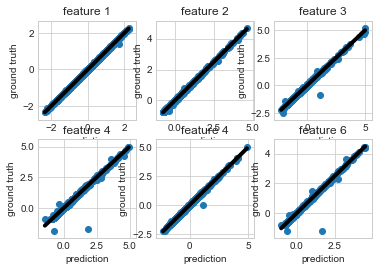

In [109]:
#plotting the predictions for the test dataset
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()

plt.subplot(2,3,2)
feat_flag = 1;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 2')
#plt.show()

plt.subplot(2,3,3)
feat_flag = 2;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 3')
#plt.show()

plt.subplot(2,3,4)
feat_flag = 3;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()


plt.subplot(2,3,5)
feat_flag = 4;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()

plt.subplot(2,3,6)
feat_flag = 5;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 6')
plt.show()

## training the MLP model

In [32]:
###training the MLP
mlp_params=[]
grid_params = {
            'hidden_layer_sizes' : [(128), (256,),(512,),(1024,)],
            'learning_rate_init' : [5e-3, 1e-2, 5e-2, 1e-3],
            'activation' : ['relu'],
            'early_stopping' : [True],
            'tol' : [1e-4],
            'n_iter_no_change' : [10],
            'max_iter' : [200]
    }

In [33]:
mlp_sub = GridSearchCV(MLPRegressor(), grid_params, scoring = 'r2', n_jobs = -1, cv = 5)
for feat_flag in range(len(feature_columns)):
    print('GridSearch for feature %d' % feat_flag)
    mlp_sub.fit(X, y[:, feat_flag])
    print(mlp_sub.best_params_)
    mlp_params.append(mlp_sub.best_params_)

GridSearch for feature 0
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (512,), 'learning_rate_init': 0.005, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 1
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (1024,), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 2
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (1024,), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 3
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (1024,), 'learning_rate_init': 0.001, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 4
{'activation': 'relu', 'early_stopping': True, 'hidden_layer_sizes': (512,), 'learning_rate_init': 0.01, 'max_iter': 200, 'n_iter_no_change': 10, 'tol': 0.0001}
GridSearch for feature 5
{'activation': 'relu', 'early_stopping

In [34]:
# predicting the output and others using the selected hyperparameters
mlp_models = []
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    mlp_sub = MLPRegressor(**mlp_params[feat_flag])
    mlp_sub.fit(X, y[:, feat_flag])
    pred = mlp_sub.predict(X_test)
    mlp_models.append(mlp_sub)
    print('MLP Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
MLP Test: mse loss=0.000225 r2_score=0.999774
fitting feature 1
MLP Test: mse loss=0.000616 r2_score=0.999351
fitting feature 2
MLP Test: mse loss=0.004933 r2_score=0.994433
fitting feature 3
MLP Test: mse loss=0.017690 r2_score=0.981277
fitting feature 4
MLP Test: mse loss=0.001426 r2_score=0.998462
fitting feature 5
MLP Test: mse loss=0.009852 r2_score=0.989724


In [35]:
## now we will re-train the mlp model using 5-fold cross-validation
## mlp_models, mlp_oof, mlp_pred = run_6sub_oof(MLPRegressor, mlp_params)
joblib.dump(mlp_models, "./Results/mlp_models.m")

## load the model 
mlp_models = joblib.load("./Results/mlp_models.m")

In [36]:
# model prediction for testing dataset
y_pred=np.zeros(y_test.shape)
for ix, model in enumerate(mlp_models):
    y_pred[:, ix] += model.predict(X_test)

for feat_flag in range(len(feature_columns)):
    loss_test = mse_loss(y_test[:, feat_flag], y_pred[:, feat_flag])
    R2_test  = metrics.r2_score(y_test[:, feat_flag], y_pred[:, feat_flag])
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(loss_test, R2_test))

Test: mse loss=0.000225 r2_score=0.999774
Test: mse loss=0.000616 r2_score=0.999351
Test: mse loss=0.004933 r2_score=0.994433
Test: mse loss=0.017690 r2_score=0.981277
Test: mse loss=0.001426 r2_score=0.998462
Test: mse loss=0.009852 r2_score=0.989724


In [37]:
#plotting the predictions for the test dataset
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()

plt.subplot(2,3,2)
feat_flag = 1;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 2')
#plt.show()

plt.subplot(2,3,3)
feat_flag = 2;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 3')
#plt.show()

plt.subplot(2,3,4)
feat_flag = 3;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()


plt.subplot(2,3,5)
feat_flag = 4;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()

plt.subplot(2,3,6)
feat_flag = 5;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 6')
plt.show()

## training the Gaussian process

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [42]:
## not yet finished
kernel = RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0))
# kernel = RBF(**gpr_para[feat_flag])

gpr_models=[]
for feat_flag in range(len(feature_columns)):
    gpr_sub = GaussianProcessRegressor(kernel=kernel,
                    random_state=0)
    print('fitting feature %d' % feat_flag)
    gpr_sub.fit(X, y[:, feat_flag])
    print(gpr_sub.kernel_)
    gpr_models.append(gpr_sub)

fitting feature 0
RBF(length_scale=0.7)
fitting feature 1
RBF(length_scale=0.635)
fitting feature 2
RBF(length_scale=0.533)
fitting feature 3
RBF(length_scale=0.516)
fitting feature 4
RBF(length_scale=0.588)
fitting feature 5
RBF(length_scale=0.567)


In [43]:
# predicting the output and others using the selected hyperparameters
for feat_flag in range(len(feature_columns)):
    print('fitting feature %d' % feat_flag)
    gpr_sub = gpr_models[feat_flag]
    pred = gpr_sub.predict(X_test)
    print('gpr Test: mse loss={:.6f} r2_score={:.6f}'.format(
        mse_loss(y_test[:, feat_flag], pred),metrics.r2_score(y_test[:, feat_flag], pred)))

fitting feature 0
gpr Test: mse loss=0.000723 r2_score=0.999273
fitting feature 1
gpr Test: mse loss=0.005750 r2_score=0.993942
fitting feature 2
gpr Test: mse loss=0.028893 r2_score=0.967394
fitting feature 3
gpr Test: mse loss=0.051098 r2_score=0.945916
fitting feature 4
gpr Test: mse loss=0.008252 r2_score=0.991097
fitting feature 5
gpr Test: mse loss=0.024989 r2_score=0.973935


In [44]:
joblib.dump(gpr_models, "./Results/gpr_models.m")

['./Results/gpr_models.m']

In [45]:
## load the model 
gpr_models = joblib.load("./Results/gpr_models.m")

In [46]:
# model prediction for testing dataset
y_pred=np.zeros(y_test.shape)
for ix, model in enumerate(gpr_models):
    y_pred[:, ix] += model.predict(X_test)

for feat_flag in range(len(feature_columns)):
    loss_test = mse_loss(y_test[:, feat_flag], y_pred[:, feat_flag])
    R2_test  = metrics.r2_score(y_test[:, feat_flag], y_pred[:, feat_flag])
    print('Test: mse loss={:.6f} r2_score={:.6f}'.format(loss_test, R2_test))

Test: mse loss=0.000723 r2_score=0.999273
Test: mse loss=0.005750 r2_score=0.993942
Test: mse loss=0.028893 r2_score=0.967394
Test: mse loss=0.051098 r2_score=0.945916
Test: mse loss=0.008252 r2_score=0.991097
Test: mse loss=0.024989 r2_score=0.973935


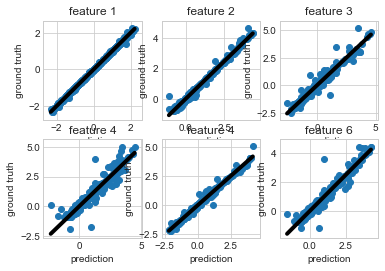

In [47]:
#plotting the predictions for the test dataset
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.subplot(2,3,1)
feat_flag = 0;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 1')
#plt.show()

plt.subplot(2,3,2)
feat_flag = 1;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 2')
#plt.show()

plt.subplot(2,3,3)
feat_flag = 2;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 3')
#plt.show()

plt.subplot(2,3,4)
feat_flag = 3;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()


plt.subplot(2,3,5)
feat_flag = 4;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 4')
#plt.show()

plt.subplot(2,3,6)
feat_flag = 5;
feature_min = min(y_pred[:,feat_flag])
feature_max = max(y_pred[:,feat_flag])
feature_linspace = np.linspace(feature_min, feature_max, 100)
plt.plot(feature_linspace, feature_linspace, '-k', linewidth=4)
plt.scatter(y_pred[:,feat_flag], y_test[:,feat_flag], marker='o');
plt.xlabel('prediction')
plt.ylabel('ground truth');
plt.title('feature 6')
plt.show()

## following will be for optimization

To be updated 

### Model evaluation

* The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
* The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

## Load model

In [110]:
from sklearn.externals import joblib
models = joblib.load("./Results/xgboost_models.m")
models_cv = joblib.load("./Results/xgb_cv_models.m")

In [111]:
def loss_func(x):
    # MSE 均方误差损失函数
    y_pre=np.zeros(y_data_exp.shape)
    # print(y_pre)
    for ix, model in enumerate(models):
        y_pre[:, ix ] += model.predict(x.reshape(1, -1))
    print(y_pre,y_data_exp)
    loss = mse_loss(y_pre, y_data_exp)
    #print(loss)
    return loss

def loss_cv_func(x):
    # MSE 均方误差损失函数
    y_pre=np.zeros(y_data_exp.shape)
    for ix, model_cv in enumerate(models_cv):
        y_pre[:, ix % 6] += model_cv.predict(x.reshape(1, -1))/5
    print(y_pre,y_data_exp)
    loss = mse_loss(y_pre, y_data_exp)
    return loss

# callback to save the function value.
def callback_save_func_val(xk, convergence):
    # xk is the current value of x0
    global niter
    niter=niter+1
    error=loss_func(xk)
    print('-'*100)
    print('niter={}:current x={},mse loss={}'.format(niter,xk,error))
    x_vec.append(xk)
    y_vec.append(error)
    return 

In [113]:
# experimental value test
loss=loss_func(q_data_exp)
print(loss)
print('from cv models')
loss_cv = loss_cv_func(q_data_exp)
print(loss)

[[-1.69454956 -0.57133818 -1.61065435  0.26535311 -1.59228158  0.09254304]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
0.0022673056191086023
from cv models
[[-1.69286299 -0.57387695 -1.61499402  0.269488   -1.59476081  0.09768992]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
0.0022673056191086023


In [133]:
print(q_data_exp)
#print(y_data_exp)

# model prediction using the true parameters
y_pred=np.zeros(y_data_exp.shape)
loss_gt = loss_func(q_data_exp)
print(loss_gt)

q_data_opt = np.array([1.00994278, 0.96534415, 4.99499447, 1.86184051])
print(q_data_opt)
loss_opt = loss_func(q_data_opt)
print(loss_opt)

[[1. 1. 1. 1.]]
[[-1.69454956 -0.57133818 -1.61065435  0.26535311 -1.59228158  0.09254304]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
0.0022673056191086023
[1.00994278 0.96534415 4.99499447 1.86184051]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
7.756619540167493e-06


## optimation process

In [114]:
from scipy.optimize import differential_evolution
import random
start_time=time.clock()
global niter#niter:Number of evaluations of the objective functions and of its Jacobian and Hessian.
niter=0
start_time=time.clock()

lb=0.2*q_data_exp[0]
ub=5*q_data_exp[0]
x0=(random.random()*(ub-lb)+lb)
print('initiate point x:',x0)
x_vec,y_vec=[],[]
res=differential_evolution(loss_func,bounds=[(lb[i],ub[i])for i in range(len(lb))]
            , strategy='best1bin', maxiter=500, popsize=50, tol=1e-6, mutation=(0.5, 1)
            , recombination=0.7,callback=callback_save_func_val)
end_time=time.clock()
print ('#'*100)
print(res)
print('optimation cost time=%f(s)' %(end_time-start_time))

initiate point x: [2.19105011 2.19105011 2.19105011 2.19105011]
[[ 0.02193683 -0.58431256 -0.38116205 -0.68076384 -0.28987139 -0.68791735]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.71152484 -0.38702166  0.9982903  -0.76925135  1.04269314 -0.65857995]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.8581475  -0.49411047 -0.90941274 -0.20341718 -0.97149253 -0.27675623]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.59087455 -0.4868443  -0.30823791 -0.37869638 -0.17546558 -0.42317545]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.82912421 -0.48294181  0.14820093 -0.66201043  0.2706601  -0.58621693]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.75172949 -0.48254764 -0.19878608 -0.41062021 -0.06042522 -0.42639375]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.18640816  0.931337 

[[ 0.76764154 -0.56770754 -0.03293902 -0.6487664   0.08617091 -0.67064393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.94154096 -0.51721168  0.00446022 -0.49588537  0.13406932 -0.56717706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.25486428 1.83432448 1.38233757 0.92682958 2.04468393 1.34053159]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.90466642e-03  3.40477204e+00  3.20644283e+00  2.72456360e+00
   3.37837458e+00  2.73196578e+00]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.1885086  1.33798885 0.96091217 0.4646033  1.46733761 0.96115512]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.73525321 -0.53819454 -1.03799701  0.24664149 -1.00450945 -0.16258585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.01378608 -0.50942647  0.12129915 -0.66396093  0.28518218 -0.61569619]

[[-1.34729862 -0.51287925 -1.28621471 -0.07589895 -1.29894662 -0.23453796]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.70744514  0.0488188   0.96005654 -0.43013185  0.8172816  -0.28115577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.78026152 -0.45265085  0.19485131 -0.64681113  0.27944666 -0.58393049]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77710366 -0.46663821 -1.58544469  0.3926419  -1.62391782  0.23150146]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.13548926 -0.41599107 -0.00423169 -0.59010637 -0.10154259 -0.57795036]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.00606284 -0.61660469 -0.4605118  -0.61034286 -0.35823256 -0.64831245]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[0.1161592  0.95944512 0.74883682 0.25451481 1.03951263 0.70171833]] [[-1.68777667 -0.5

[[ 0.16116887 -0.20721394  0.29754889 -0.46181446 -0.08967769 -0.42716104]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.25229192 -0.31824934  0.88934863 -0.68001914  0.79996926 -0.59021556]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.18472305  0.45590177  0.67895687 -0.12170523  0.65780461  0.14228615]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.4816218  -0.49726671  0.04747054 -0.72932994  0.07655954 -0.70573902]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.86764657 -0.6866467  -1.03736937 -0.4392668  -0.98047793 -0.57681966]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.01660675 -0.59001088 -0.46172583 -0.58819962 -0.38820362 -0.6119802 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.44639695  0.0840646  -0.95599031  0.38816959 -1.07028461  0.29178274]] [[-1.6877766

[[ 1.10638285 -0.54229176  0.330293   -0.82360315  0.44915196 -0.75190854]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.68363678  0.28978166 -0.11241663  0.07991171 -0.29477119  0.1480515 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.16663206  0.95933324  0.47721341  0.29086566  0.6782468   0.73009956]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.675156   -0.63808036 -0.96029437 -0.20149016 -0.91728044 -0.4473238 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.84476221 -0.67395914 -0.99222231 -0.46067607 -0.94476211 -0.5801779 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.35619009 -0.72935212 -1.39282262 -0.24244046 -1.33848417 -0.39433187]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.77143312  0.60401267 -0.06336564  0.41080731 -0.23159719  0.61225748]] [[-1.6877766

[[-0.96541727 -0.68560612 -1.17858183 -0.27588516 -1.11440063 -0.46781415]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.66246819 -0.20445144 -0.43015873 -0.23548752 -0.59026408 -0.28709131]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.37648022  1.89781892 -0.18544787  1.60617507 -0.33410543  1.90301216]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.50599372 -0.60298336 -0.73996961 -0.53985631 -0.69864547 -0.59827638]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.19513118 -0.22565103  0.32137269 -0.4648056   0.13418069 -0.44966465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.22164154 -0.51274478 -0.47913539 -0.2317704  -0.37274611 -0.44197512]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75084591 -0.75113428 -1.74803686  0.12945557 -1.67556143 -0.0805828 ]] [[-1.6877766

[[0.21550089 1.69221175 1.21051013 0.7825368  1.83612847 1.2037189 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.91939211 -0.43663502 -1.72508883  0.55038118 -1.7222538   0.39218137]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.594419   -0.21838188 -1.27008212  0.33264285 -1.37071478  0.17041457]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.708004   -0.47270483 -0.67926407 -0.42868137 -0.74645865 -0.50904667]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.14787138 -0.54307938 -1.21119201  0.10550514 -1.23610616 -0.02718604]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.39200598 -0.62843657 -0.68536448 -0.56110585 -0.63847303 -0.60811865]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-2.02161431 -0.55973482 -1.97874045  1.02387714 -1.91272736  0.70539087]] [[-1.68777667 -0.5

[[-0.62279665 -0.29327631 -0.43627328 -0.27910221 -0.58293498 -0.36865377]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.62026596 -0.66007531 -0.89843929 -0.35570878 -0.82374167 -0.5194732 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.46509326 -0.70331287 -1.49056792 -0.09158021 -1.44241774 -0.28984731]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.34816396 -0.63918281 -1.3258847  -0.21097237 -1.29821336 -0.37105095]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.38808209  0.40380245  0.21035621  0.12018642  0.03652331  0.26963216]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-2.06964397 -0.53404903 -1.97895885  1.01425707 -1.93969536  0.95354068]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65862107  0.28999728 -1.12518024  0.82570064 -1.26606703  0.73172539]] [[-1.6877766

[[-1.7024529  -0.71990192 -1.70585799  0.14979813 -1.65057302 -0.0464167 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.20077598 -0.42186958 -1.19596469  0.07452315 -1.187989   -0.06522506]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.743783   -0.69983506 -1.71913457  0.44943124 -1.67718911  0.04145846]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 1.69871545 -0.40886849  1.02346599 -0.83297384  1.06415844 -0.73046255]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.23445523  4.49860382  3.1129334   4.86463642  2.00896573  4.25852013]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56600809 -0.41582274 -1.38690495  0.09463626 -1.39490223 -0.05029547]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.07850668 -0.58878803 -0.45007145 -0.46931297 -0.3919003  -0.57749307]] [[-1.6877766

[[-1.78223991 -0.70620203 -1.76947021  0.45664108 -1.71957231  0.09775639]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.38778144  0.20930246  0.15231326  0.05225381 -0.04706228  0.13163981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72642803 -0.70301092 -1.92833877 -0.14945447 -1.64933372 -0.33040547]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.5651443   3.69016886  1.04528928  3.94284678  0.41654131  3.71669531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.98062611 -0.57994354 -1.96169949  1.20541561 -1.876894    0.60326403]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.9445039   0.86707175 -0.18112332  0.53055465 -0.27042454  0.75902909]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.79421747  4.67383814  4.32043171  4.66845655  3.16183233  4.07263947]] [[-1.6877766

[[ 0.73885363 -0.44366354 -0.14612049 -0.22716999 -0.14030099 -0.40724742]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.89907312 -0.65318298 -1.81205463  0.3966575  -1.75913858  0.18642363]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.02946126  1.07220912 -0.18851656  0.72816098 -0.24724346  1.00395656]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74588919 -0.12960964 -1.45054924  0.82858878 -1.50955081  0.67021072]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.04499191 -0.49532282 -0.57477748 -0.29930204 -0.48500836 -0.3396799 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.85524452 -0.56003642 -0.9018079  -0.40651959 -0.914801   -0.5002284 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.14637351 -0.56155157 -1.14121103 -0.27853608 -1.14695382 -0.38931793]] [[-1.6877766

[[-1.67713737 -0.64327323 -1.58535457  0.067651   -1.56570911 -0.10167623]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85873842  1.76446462 -0.91094446  2.20261383 -1.12655199  2.40362573]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.43012023 -0.69558954 -1.43148267 -0.10483474 -1.3996973  -0.28174931]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.87447047 -0.51024258 -1.708992    0.41868326 -1.71701407  0.23606369]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69123411 -0.52567744 -1.60961652  0.24640802 -1.59289765  0.05969587]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=3:current x=[1.04667534 0.97428496 0.85299399 1.16113466],mse loss=0.0014530282897076581
[[ 0.65640104 -0.46534169 -0.29510689 -0.276

[[-0.96073627  0.23301908 -0.41825682  0.2963953  -0.61503863  0.29591459]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82796788  1.04245257 -1.13949704  1.53137863 -1.27226329  1.56552744]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.83466434 -0.56813943  0.0169186  -0.72069287  0.17933607 -0.69682753]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.63626742 -0.67100024 -0.94099391 -0.45551848 -0.86683798 -0.60055292]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.54875112 -0.66904628 -1.53802347 -0.11447054 -1.49933541 -0.14823318]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.55536723 -0.66280198 -1.5168972  -0.04167151 -1.48862636 -0.19514591]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-2.02572584 -0.48878777 -1.96806026  0.87146246 -1.88717365  0.79246294]] [[-1.6877766

[[-1.37798047 -0.12983692 -1.05025947  0.18749437 -1.17462492  0.05228505]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.86185002  0.10570371 -1.51273417  0.95886564 -1.58220959  0.71966696]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.42024648  0.07598907 -0.9785862   0.38406968 -1.12007248  0.27130032]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.77071559 -0.6740098  -1.03600359 -0.36919916 -0.95171285 -0.54429042]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-0.16625488  3.50565338  3.24909854  2.94163585  3.33385921  2.89261794]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[3.95772755e-02 6.34422898e-01 5.77004611e-01 1.92165375e-04
  6.39121830e-01 2.94868827e-01]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.42031527 -0.55333328 -1.3764919  -0.11154306 -1.34095156 -0.261

[[-1.59746099 -0.37548167 -1.39642775  0.2312668  -1.43816793  0.06250256]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.99176788 -0.607391   -1.91188693  0.60651827 -1.85330391  0.43824697]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.48435891 -0.74310243 -1.55115032 -0.13497263 -1.47704136 -0.31659287]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82549548 -0.12987882 -1.54811573  0.62635052 -1.59487677  0.43752196]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.81475103 -0.55071807 -0.01271796 -0.61419368  0.08883131 -0.62508261]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.9479413  -0.58560801 -1.84708929  0.54499537 -1.80693841  0.37954211]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.48252535e+00 -6.36273861e-01 -1.49656451e+00  9.79155302e-04
  -1.44289792e+00 -1.2

[[-1.66143513 -0.29248834 -1.42963994  0.27266568 -1.48727512  0.1480585 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-2.02849603 -0.56412232 -1.97814727  0.71246099 -1.87650061  0.63204825]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70068836 -0.13111722 -1.35512006  0.59921676 -1.42159915  0.35694236]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72919941 -0.49010479 -1.59393597  0.21455899 -1.59287095  0.09573808]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78911972 -0.66155207 -1.72987556  0.15809321 -1.66924644 -0.02084702]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6194272  -0.43836766 -1.46703768  0.12216154 -1.47449005 -0.01475865]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.44496155 -0.64377213 -1.4224149  -0.0924722  -1.38337409 -0.25367004]] [[-1.6877766

[[-2.1927402  -0.4608438  -2.08563399  1.78763115 -2.06383753  1.51894259]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[ 0.42607731 -0.57512116 -0.21086299 -0.59977162 -0.12561798 -0.62671018]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.49190569 -0.48866385 -1.44929647  0.10628644 -1.4590292  -0.01143789]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.81311727 -0.63660455 -1.72354007  0.20125154 -1.69963646  0.03104424]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71286964  0.00301275 -1.2651813   0.54546142 -1.36797929  0.41240519]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64456797 -0.38107783 -1.50950694  0.4969576  -1.55250382  0.4004831 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72858024 -0.28447413 -1.51866651  0.3843613  -1.56444192  0.21059543]] [[-1.6877766

[[-1.40084136 -0.3427645  -1.22907865  0.06797582 -1.29993248 -0.04959548]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.50993681  0.11234856 -1.00942683  0.65764517 -1.17405427  0.59395885]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.48288429 -0.70740914 -1.51352072  0.04243714 -1.48770547 -0.14753723]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.50931025 -0.30262429 -1.3115437   0.30564737 -1.38691354  0.18179384]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.79383612 -0.72806203 -1.80536747  0.29387054 -1.70728779  0.03022569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57028246 -0.72268224 -1.60819793 -0.07084948 -1.53782296 -0.21056467]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.87822556  0.09626377 -1.520262    0.98382378 -1.59133196  0.70042098]] [[-1.6877766

[[-1.56784034 -0.74764037 -1.6219604   0.01234299 -1.56729078 -0.20813584]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65156627 -0.64387119 -1.64400029  0.17845815 -1.59530902  0.10682774]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60318208 -0.43580031 -1.51920938  0.51141143 -1.54035378  0.31885779]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.86740756 -0.71088946 -1.86164665  0.32347524 -1.77894664  0.13128451]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77929521 -0.76320064 -1.78062391  0.17998782 -1.69028115 -0.07475048]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76373148 -0.7266798  -1.7661159   0.26930898 -1.68078399  0.01464364]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66277075 -0.3207137  -1.47752714  0.23458213 -1.49262106  0.11186525]] [[-1.6877766

[[-1.75667667 -0.73142612 -1.75952911  0.20908353 -1.70131564 -0.02427012]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78055358 -0.6185106  -1.71892452  0.1894592  -1.66792965 -0.00317979]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69641161 -0.73042798 -1.7594533  -0.11165118 -1.65076351 -0.20861918]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56224799 -0.69444025 -1.59915519 -0.03775454 -1.53102016 -0.21881539]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.51621914 -0.32759601 -1.36292326  0.45817038 -1.38738275  0.31003129]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65034819 -0.27532864 -1.47487915  0.50779277 -1.54891324  0.44439721]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85383129 -0.28579175 -1.64215374  0.60679871 -1.67390156  0.52786815]] [[-1.6877766

[[-1.680233   -0.63824773 -1.58323717  0.07219124 -1.5629847  -0.09322762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66834712 -0.60779035 -1.64800501  0.32043231 -1.59531856  0.18402725]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.32929075 -0.50956321 -1.2416594  -0.1224004  -1.28529787 -0.25292772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64992929 -0.76348495 -1.65993595 -0.0218184  -1.59118629 -0.20828867]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75573802 -0.52883327 -1.62486148  0.27387595 -1.60331917  0.12388554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.5728159  -0.3014183  -1.33940804  0.34944743 -1.3885324   0.17378673]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65992403 -0.58501065 -1.57438087  0.0782654  -1.54801702 -0.06092656]] [[-1.6877766

[[-1.78999543 -0.57469022 -1.64610982  0.23132968 -1.65322304  0.0549618 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.83752918 -0.44935232 -1.65265918  0.59842157 -1.69108367  0.44372877]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.89170289 -0.58438313 -1.76282001  0.48213661 -1.7501018   0.30913663]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.53274822 -0.75161803 -1.61377954 -0.01131266 -1.55598783 -0.20840907]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66687894 -0.68915141 -1.69575047  0.07271281 -1.62973356 -0.12869126]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68697071 -0.34750432 -1.52235532  0.45636582 -1.56420016  0.29491791]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82791853 -0.71152496 -1.83043647  0.40993935 -1.74096084  0.0702844 ]] [[-1.6877766

[[-1.73919225 -0.70947611 -1.73143053  0.24301198 -1.6623981   0.11077315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.44570327 -0.75218153 -1.53687501 -0.06529057 -1.48161066 -0.26988471]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.83737302 -0.31608397 -1.60259771  0.41480592 -1.65244818  0.25556317]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82134509 -0.68636775 -1.77556109  0.17672181 -1.70813513  0.02775779]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78215122 -0.1314317  -1.45751548  0.51672012 -1.50432277  0.40181458]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73497343 -0.56028938 -1.62575126  0.14388782 -1.61215711 -0.0151093 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.76042366 -0.40052354 -1.58564782  0.3083266  -1.61655235  0.17484468]] [[-1.6877766

[[-1.87065816 -0.70395947 -1.85118604  0.32112318 -1.77788186  0.11640766]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66505241 -0.68267882 -1.64229155  0.09119102 -1.59042358 -0.03587985]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71850801 -0.68497956 -1.68334532  0.08693656 -1.63900042 -0.09356421]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67103982 -0.43346405 -1.5431602   0.29484022 -1.56260467  0.11689869]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67822599 -0.46970016 -1.57481384  0.19985917 -1.58078742  0.03231189]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7023766  -0.66375041 -1.64324975  0.09160858 -1.60163069 -0.11284417]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.92067719 -0.67565608 -1.89275742  0.70216399 -1.82263708  0.35466897]] [[-1.6877766

[[-1.65419269 -0.41028392 -1.53159022  0.54702598 -1.53381085  0.35023081]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.88803434  0.61018097 -1.33271039  1.38719594 -1.48469865  1.23191047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69967699 -0.60812283 -1.60025358  0.09147412 -1.57785439 -0.07144815]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70618367 -0.68267512 -1.63988352  0.0967319  -1.60699153 -0.08018929]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61960411 -0.26829714 -1.3952775   0.27856284 -1.45674431  0.12708947]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64032435 -0.69903529 -1.60720682 -0.12123168 -1.56792784 -0.21075243]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6800828  -0.68145919 -1.66294456  0.1775409  -1.61007285  0.05288178]] [[-1.6877766

[[-1.7331183   0.1157518  -1.29888821  0.61688036 -1.40640676  0.59904552]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.85075903 -0.6903708  -1.78920484  0.25897467 -1.73992133  0.10178742]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68150997 -0.60404575 -1.59951043  0.08989108 -1.5671382  -0.07412803]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.82408595 -0.17811233 -1.55416179  0.81434858 -1.60729551  0.69743091]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72385812 -0.58108437 -1.63088655  0.19379079 -1.61352468  0.02794933]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57007623 -0.48740458 -1.50918174  0.10215938 -1.51795626 -0.05604219]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73552346 -0.62568736 -1.69576025  0.24904343 -1.65829825  0.02857757]] [[-1.6877766

[[-1.67329264e+00 -5.34536719e-01 -1.57885051e+00  1.41565233e-01
  -1.57837915e+00  9.24885273e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63863993  0.58918864 -1.10203636  0.92372358 -1.2483933   0.9738313 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57893515 -0.73781204 -1.65194297 -0.03086358 -1.55930901 -0.21737719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75395107 -0.65486252 -1.71417618  0.12961048 -1.66073322 -0.03329086]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67730093  0.12659398 -1.18951595  0.82179999 -1.30512607  0.71168065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65676928 -0.70326567 -1.62084508  0.01473734 -1.56640697 -0.16895962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70135951 -0.69907069 -1.69529295  0.15802273 -1.63599658 

[[-1.7555778  -0.46982837 -1.59054542  0.29118657 -1.61468673  0.15952617]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77474833 -0.46899146 -1.6268692   0.35643297 -1.64375329  0.20674056]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70139956 -0.69656146 -1.62467694  0.08017024 -1.60199165 -0.09609622]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68731332 -0.7405026  -1.7007091   0.13228697 -1.63786459 -0.10088539]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72112417 -0.69191742 -1.67796659  0.0790329  -1.62074471 -0.08876032]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80450535 -0.62825131 -1.72305298  0.19029674 -1.70305562  0.0385462 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77745724 -0.62399316 -1.67215276  0.17223239 -1.64297462 -0.00977534]] [[-1.6877766

[[-1.69436979 -0.43305117 -1.54528928  0.22316805 -1.55687666  0.07506549]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63204002 -0.36943996 -1.45903313  0.24649334 -1.48834646  0.06935531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70444703 -0.60552418 -1.61885738  0.09961057 -1.59691143 -0.08183694]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73485208 -0.50305164 -1.58613515  0.23605242 -1.59571266  0.09930158]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.55128002 -0.66567075 -1.52025032 -0.04837012 -1.48159289 -0.20152569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72299004 -0.66421187 -1.68161869  0.10160324 -1.64185095 -0.08088011]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66236687e+00 -4.88155127e-01 -1.54146028e+00  1.55873358e-01
  -1.55408597e+00  1.8

[[-1.60963035 -0.54751325 -1.55589533  0.1504547  -1.5459938  -0.04042798]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68152142 -0.01341659 -1.32461119  0.5620079  -1.404055    0.37391278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72417641 -0.69504929 -1.67537856  0.14705998 -1.63338041 -0.04944813]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7253561  -0.67448413 -1.65519595  0.1325008  -1.62997746 -0.06020588]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62643027 -0.37397653 -1.46552718  0.39958832 -1.47014034  0.25843027]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65229583 -0.56992614 -1.56241035  0.10819361 -1.54824948 -0.06398058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62050962  0.51090461 -1.0491116   0.84475452 -1.20983303  0.91618347]] [[-1.6877766

[[-1.57095194 -0.48354179 -1.50998831  0.12330851 -1.52328849 -0.03653973]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60370803 -0.44877619 -1.44761443  0.08399498 -1.46163535 -0.06630594]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71481252 -0.58299422 -1.61943483  0.18134227 -1.60865116 -0.01080614]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74534822  0.11953315 -1.27556789  0.77025306 -1.40279424  0.67754143]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70442629 -0.49099708 -1.62272906  0.40682903 -1.5968802   0.286827  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73313999 -0.28555071 -1.51029468  0.41800025 -1.56393337  0.24804622]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74992943 -0.53879666 -1.61440516  0.20837623 -1.59522128  0.01502368]] [[-1.6877766

[[-1.71229625 -0.24674773 -1.47949302  0.36605382 -1.54775453  0.22592205]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66934705 -0.54189241 -1.58700132  0.15376595 -1.57998657  0.01223284]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69180107 -0.58257139 -1.60005093  0.16383556 -1.58056164  0.00642854]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61070633 -0.55472279 -1.57360601  0.2974776  -1.54880977  0.15253246]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.77429271 -0.5851903  -1.67171597  0.40160707 -1.65448117  0.26445889]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59677863 -0.61491406 -1.55524611  0.01446295 -1.53168678 -0.1484639 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64920115 -0.50469804 -1.52416039  0.1594899  -1.53858232 -0.00658929]] [[-1.6877766

[[-1.71921587 -0.57746494 -1.62888026  0.16899717 -1.60137963 -0.01324022]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68915486 -0.55765331 -1.58675885  0.18083292 -1.58756042  0.01405671]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7135613  -0.67910659 -1.66086292  0.22809994 -1.59606767  0.01911575]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70757842 -0.52384603 -1.61208296  0.20661101 -1.59970188  0.03791809]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71522188 -0.56974876 -1.63115716  0.27657783 -1.61104274  0.10819525]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68159056 -0.58865917 -1.59857965  0.09035683 -1.571172   -0.05341393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73832464 -0.67193127 -1.70414424  0.22036254 -1.64596677  0.0492039 ]] [[-1.6877766

[[-1.7351439  -0.50533164 -1.59005284  0.21392837 -1.59758401  0.08783191]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69715595 -0.59750867 -1.61337972  0.08889493 -1.58205009 -0.05022109]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61222196 -0.69426048 -1.58237243  0.00638056 -1.52974319 -0.18317664]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66681576 -0.49415308 -1.57812834  0.37131655 -1.57153583  0.20294896]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.78479218 -0.70943105 -1.76074147  0.335087   -1.72843814  0.13187554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73253798 -0.53538799 -1.61628795  0.5474996  -1.63037443  0.39263183]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7058599  -0.42402589 -1.55595279  0.24140635 -1.55661941  0.0934152 ]] [[-1.6877766

[[-1.71902442 -0.73299348 -1.67732906  0.03931057 -1.61161613 -0.14971787]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64893389 -0.43921608 -1.51175237  0.15860045 -1.53084731  0.01738295]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80066848 -0.5647049  -1.64725399  0.3959046  -1.66600609  0.19299647]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.53954291 -0.62259233 -1.54892302  0.09725448 -1.46945643  0.0031172 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73806953 -0.53788877 -1.63975167  0.43086934 -1.63265395  0.30643153]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65738511 -0.50661266 -1.53542018  0.17240942 -1.54991937  0.02580231]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69205904 -0.49439389 -1.60080719  0.38263011 -1.60222125  0.20304158]] [[-1.6877766

[[-1.61139035 -0.47571456 -1.56271362  0.37538439 -1.53624868  0.20482284]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70066118 -0.63298881 -1.60981584  0.08709872 -1.58504605 -0.07785058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.56480551 -0.37437844 -1.38083339  0.17679524 -1.40606642  0.04570526]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69293737 -0.58973551 -1.60126019  0.15704179 -1.59004831 -0.01224452]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.75565386 -0.53398192 -1.63798189  0.2235817  -1.61621237  0.04928854]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60787249 -0.54250968 -1.56329918  0.20582885 -1.54791999  0.06069115]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69256091 -0.22889107 -1.38584912  0.40569815 -1.46483123  0.28717017]] [[-1.6877766

[[-1.75981617 -0.48153126 -1.60891533  0.23325872 -1.62748694  0.10650849]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62548757 -0.57949758 -1.59898257  0.25165576 -1.56410551  0.10832328]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.54718924 -0.33709043 -1.27091694  0.17611626 -1.34713578  0.08940923]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67251229 -0.5469991  -1.58194947  0.17988321 -1.59191322  0.03324214]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69897914 -0.50035071 -1.57808518  0.18657514 -1.58218598  0.02652335]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71773314 -0.55790222 -1.62848949  0.17529753 -1.60443521  0.01080084]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70018888 -0.54810107 -1.59649587  0.28624368 -1.60014391  0.10659826]] [[-1.6877766

[[-1.70917034 -0.6656729  -1.64384437  0.23027471 -1.60789537  0.0297097 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73300552 -0.53309    -1.6200676   0.23509896 -1.59640956  0.03166157]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69816756 -0.55163074 -1.60358524  0.18687639 -1.59442186 -0.00534832]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69150352 -0.5798521  -1.61193776  0.18924463 -1.58774519  0.0227823 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68633866 -0.55847299 -1.58473039  0.13158008 -1.57790875 -0.03373557]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71480036 -0.56700373 -1.62903953  0.14565012 -1.60147262 -0.00353885]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70094061 -0.42987162 -1.58624077  0.34790719 -1.59223127  0.16110057]] [[-1.6877766

[[-1.60383916 -0.59619796 -1.55687094  0.11907154 -1.55002451 -0.05272883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61539054 -0.59868264 -1.5911572   0.23490837 -1.54574609  0.09516174]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71628642 -0.58482873 -1.62851596  0.15113628 -1.59389758 -0.02758205]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69763756 -0.68684053 -1.62960815 -0.00592208 -1.59541941 -0.09891492]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69118261 -0.58683145 -1.60126019  0.17084926 -1.58990717 -0.01384014]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.80820084 -0.61689854 -1.73628449  0.48092359 -1.7097218   0.37437212]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70284081e+00 -5.36411405e-01 -1.61236382e+00  1.42238736e-01
  -1.58800197e+00  1.0

[[-1.65824962 -0.5581944  -1.57241988  0.11630058 -1.57018566 -0.03914702]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6982491  -0.31084239 -1.46921444  0.34950945 -1.50658941  0.20881137]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67183018 -0.5688566  -1.57811427  0.23954448 -1.57508969  0.05663913]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57511473 -0.28739733 -1.35461867  0.33916944 -1.38101125  0.16863048]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7017982  -0.69352496 -1.63997197  0.12343577 -1.58954287 -0.05852401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69971967 -0.53620625 -1.58807564  0.1666944  -1.58662796  0.01339731]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67754555 -0.63728845 -1.59010553  0.05129695 -1.54473782 -0.117428  ]] [[-1.6877766

[[-1.62929606 -0.36668444 -1.4637872   0.33285934 -1.49670088  0.15785655]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67457271 -0.5695914  -1.57658386  0.17834419 -1.57423425  0.02025521]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.59493709 -0.53417277 -1.53025174  0.10663742 -1.52429461 -0.05726737]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71730042 -0.38457721 -1.54390717  0.2926448  -1.57177877  0.16043368]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.63003039 -0.32721293 -1.42562759  0.22862381 -1.48717082  0.08554688]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72098231 -0.60946047 -1.62628984  0.15998104 -1.61974263 -0.03205067]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64043117 -0.42853159 -1.51652551  0.25388265 -1.52578926  0.12783778]] [[-1.6877766

[[-1.66613126 -0.45101476 -1.53738737  0.19092891 -1.55517936  0.02627525]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68995476 -0.5828135  -1.59717155  0.1729579  -1.57921386  0.00567049]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7387991  -0.49262518 -1.60697007  0.24338436 -1.62379432  0.12007391]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7545352  -0.62713182 -1.70402336  0.18979099 -1.66534328 -0.02351862]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68997216 -0.57483757 -1.59287691  0.21868011 -1.57835722  0.04183465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72167897 -0.6042608  -1.62533331  0.13901967 -1.60069776 -0.0480696 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68479466 -0.55399597 -1.5931251   0.26306236 -1.59200025  0.09974736]] [[-1.6877766

[[-1.68857908 -0.5889132  -1.601722    0.17369202 -1.5898428  -0.01351357]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67407703 -0.69710445 -1.63041925  0.12863177 -1.60707259 -0.05532533]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68532372 -0.57387149 -1.58389091  0.17414576 -1.60582972  0.01836458]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73722768 -0.54617894 -1.62477827  0.17241657 -1.59618235  0.00989202]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67741227 -0.69734585 -1.669245    0.1269148  -1.6293366  -0.0556609 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.57446742 -0.68397605 -1.53709221 -0.0525589  -1.49662399 -0.21063203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6604774  -0.71428132 -1.63140464  0.05817646 -1.57497287 -0.15693009]] [[-1.6877766

[[-1.73100972 -0.49646062 -1.60202861  0.20226237 -1.61060858  0.0806866 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6962359  -0.54243076 -1.59076715  0.17740437 -1.5927608  -0.00704372]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68405414 -0.53367007 -1.58308649  0.17334569 -1.58319926  0.02049384]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72509336 -0.52549529 -1.61088634  0.19547647 -1.59587264  0.02109569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65884805 -0.6521647  -1.60108137  0.1726172  -1.58476067 -0.02305895]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69558692 -0.53679717 -1.59019661  0.16328308 -1.58120179  0.00910431]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61508989 -0.63071704 -1.56710911  0.03710118 -1.55021    -0.13069516]] [[-1.6877766

[[-1.6881597  -0.58368313 -1.58544278  0.17399943 -1.58089066  0.01504242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70070195 -0.62322462 -1.60616541  0.14180958 -1.58094406 -0.04663974]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74955058 -0.59854519 -1.62647128  0.14096341 -1.60424304 -0.01717532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72468734 -0.63842738 -1.64943838  0.19013077 -1.62479186 -0.00514054]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68042827 -0.5974884  -1.60777164  0.21626878 -1.58042836  0.0828127 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69797015 -0.56742036 -1.60073328  0.1882326  -1.58757353  0.02867895]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69650221 -0.54134262 -1.60440373  0.18662533 -1.59647417  0.01573712]] [[-1.6877766

[[-1.7217617  -0.58510125 -1.63214421  0.39469361 -1.62582898  0.24125081]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68057609 -0.56424832 -1.5888803   0.23718181 -1.58105993  0.05336836]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70747471 -0.52958643 -1.61096048  0.19394562 -1.60162234  0.03952315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69488311 -0.54702103 -1.59360814  0.13311958 -1.58554006 -0.00616133]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70341635 -0.64339256 -1.6072619   0.09367943 -1.57345891 -0.08029902]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69622183 -0.54235899 -1.61181808  0.24313751 -1.59621072  0.05491957]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70890188 -0.54494894 -1.61547947  0.19942376 -1.5999279   0.02801237]] [[-1.6877766

[[-1.71937466 -0.56501806 -1.62847352  0.16627249 -1.60614729  0.00905448]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6749897  -0.55612993 -1.57402492  0.16613632 -1.5822835   0.02199757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6971736  -0.56886888 -1.58576798  0.17115688 -1.58586264  0.00712261]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69712162 -0.53660524 -1.58864212  0.1779533  -1.59022021  0.03483018]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70774889 -0.40639782 -1.56699514  0.26125467 -1.56020641  0.12217674]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69649053 -0.58461213 -1.60731125  0.23699528 -1.59088945  0.04803169]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69506264 -0.57303762 -1.5821116   0.17708305 -1.57544017  0.00811762]] [[-1.6877766

[[-1.70665503 -0.52684975 -1.59299088  0.19248763 -1.59590578  0.02629825]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6879487  -0.55046451 -1.58069944  0.25894776 -1.59671569  0.06307602]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.64065361 -0.61537778 -1.60218906  0.18700728 -1.57546759 -0.02206236]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72025657 -0.64445937 -1.65446782  0.12762749 -1.61517835 -0.05594349]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6821928  -0.56934035 -1.58106184  0.16682017 -1.57476425  0.00742811]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61978245e+00 -5.87570190e-01 -1.58959293e+00  2.11518049e-01
  -1.55931377e+00  1.41549110e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68524528 -0.59567893 -1.58025694  0.13565144 -1.58466649 

[[-1.67680359 -0.55145156 -1.57862282  0.17798021 -1.58151841 -0.00533646]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70039129 -0.54032481 -1.60607052  0.15956852 -1.58193254  0.00591552]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68123507 -0.57299662 -1.57354069  0.10851863 -1.56926584 -0.05125278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7122159  -0.62403572 -1.64432454  0.16117427 -1.61779308 -0.05285269]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70891929 -0.61014247 -1.6129725   0.16633061 -1.60518217 -0.02017862]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71407342 -0.58821929 -1.6186235   0.17170101 -1.61078763 -0.03316772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70876026 -0.60138941 -1.62011456  0.22725952 -1.60566497  0.04132557]] [[-1.6877766

[[-1.676723   -0.57664323 -1.57144785  0.1589573  -1.57851315 -0.0131833 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69654274 -0.53626549 -1.61061096  0.24479684 -1.59642386  0.05398339]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68684149 -0.58395183 -1.59599233  0.11370954 -1.58581781 -0.06639588]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.670578   -0.56488848 -1.5726254   0.13524058 -1.57302022 -0.02786207]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70125031 -0.56222248 -1.59873533  0.18540329 -1.59443402  0.01201713]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65378046 -0.49942869 -1.52620149  0.18188241 -1.54873037  0.01909086]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67139769e+00 -5.22382021e-01 -1.57252121e+00  1.77483350e-01
  -1.57902622e+00 -1.5

[[-1.68761086 -0.59009218 -1.59785581  0.13655087 -1.57740569 -0.0301919 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69253111 -0.5908494  -1.58552456  0.16672358 -1.58641458 -0.01625872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68745685 -0.59163034 -1.58408213  0.1226396  -1.57637405 -0.04241264]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69939899 -0.53510761 -1.59351897  0.1826055  -1.59475851  0.01667547]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69935226 -0.49377024 -1.57762218  0.22050303 -1.59137893  0.08204824]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69081879 -0.57580554 -1.59498358  0.28141606 -1.59054494  0.07781357]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68600273 -0.53947937 -1.61334872  0.36252803 -1.57384443  0.19868246]] [[-1.6877766

[[-1.69601297 -0.5397644  -1.60410047  0.21606493 -1.59449172  0.04636666]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69247317 -0.57773352 -1.5864315   0.17015451 -1.59026718  0.0154016 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67226338 -0.57519662 -1.57334399  0.17147416 -1.57026982 -0.00982684]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69360423 -0.584041   -1.5921402   0.24035731 -1.5908277   0.04158852]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70053554 -0.50838101 -1.58014011  0.2081863  -1.60127807  0.04863855]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67089844 -0.50799298 -1.56952214  0.18334657 -1.57882667  0.02890089]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.74003816 -0.51843286 -1.59949541  0.27292413 -1.60470462  0.1137957 ]] [[-1.6877766

[[-1.70195341 -0.52587187 -1.59104085  0.20546791 -1.59802818  0.0745351 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62203836 -0.59389508 -1.57938766  0.21532652 -1.56830645  0.02114457]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70708942 -0.58385003 -1.61796427  0.23963952 -1.58052826  0.04638264]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6411314  -0.59436619 -1.56565499  0.07136363 -1.53691459 -0.06773376]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61095166 -0.65087736 -1.5540576   0.01766029 -1.54151511 -0.14541095]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72911763 -0.50459981 -1.61146331  0.20228803 -1.60065007  0.04780072]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72128868 -0.54587317 -1.6271708   0.17719904 -1.61116219  0.02875549]] [[-1.6877766

[[-1.70423317 -0.53588772 -1.59236026  0.20622429 -1.6000371   0.06893021]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67096639e+00 -5.09651542e-01 -1.57773423e+00  1.54138118e-01
  -1.57486868e+00  1.06382370e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70628524 -0.5405972  -1.59743309  0.19259956 -1.59900641  0.07640058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69192219 -0.53746104 -1.58594632  0.18677482 -1.58631873  0.01517349]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61917281 -0.62370479 -1.56182742  0.07995254 -1.55024743 -0.09330004]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67560506 -0.57463312 -1.57559776  0.16548532 -1.58088303 -0.0092293 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72133851 -0.62943923 -1.64216685  0.18730715 -1.62031913 

[[-1.68482089 -0.59109032 -1.59924078  0.14899567 -1.58551478 -0.04284775]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69648099 -0.52864301 -1.58819175  0.1955899  -1.5954392   0.04190558]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68002892 -0.57513857 -1.58791494  0.23284245 -1.56692815  0.0511246 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70002556e+00 -5.66214561e-01 -1.59303975e+00  1.49103343e-01
  -1.58302188e+00  9.27299261e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6737535  -0.60217297 -1.57987499  0.06352502 -1.55835319 -0.07389551]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69176912 -0.57813966 -1.58905602  0.11678752 -1.58197522 -0.03895217]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.61486602 -0.58092129 -1.57734323  0.149041   -1.5663178  

[[-1.67560124 -0.55570257 -1.57402492  0.1698921  -1.5822835   0.01385775]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69643259 -0.5756613  -1.60269046  0.20192805 -1.58947682  0.01645395]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70537496 -0.54079723 -1.6148653   0.45722759 -1.61488628  0.34683335]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6843369  -0.57106459 -1.5848875   0.17343336 -1.5874145   0.01847902]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70337892 -0.59374523 -1.62494206  0.22683612 -1.59702945  0.05347094]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70981956 -0.62350523 -1.62045288  0.24703074 -1.60336542  0.03309941]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7051785  -0.53021812 -1.6107986   0.18256235 -1.59548044  0.03033763]] [[-1.6877766

[[-1.70228672 -0.54625094 -1.59291196  0.19179311 -1.59873247  0.03048897]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70742536 -0.57879412 -1.63017678  0.33449584 -1.59383535  0.17325938]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68717504 -0.5897671  -1.60009909  0.16236699 -1.58030105  0.00602821]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6142056  -0.57785726 -1.56271529  0.20688781 -1.55656981 -0.02277642]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70647907 -0.54501033 -1.5940218   0.19694382 -1.59692097  0.03556028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62287283 -0.60340405 -1.58973098  0.12333682 -1.56743789 -0.05171758]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69682908 -0.55567169 -1.58355427  0.18295383 -1.59471774 -0.0143398 ]] [[-1.6877766

[[-1.64122295 -0.60518789 -1.61715674  0.24557206 -1.58558917  0.07392108]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69290948 -0.54155457 -1.58882761  0.16724205 -1.5829339   0.0112083 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69541097 -0.57439697 -1.59009123  0.19108692 -1.58944201 -0.00317973]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71152163 -0.52289963 -1.59152579  0.19472778 -1.59152007  0.04391971]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67536139 -0.5559839  -1.57512474  0.17925763 -1.57743454 -0.00780249]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69185495 -0.57524884 -1.5884583   0.13016063 -1.58623528 -0.03416842]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68917799 -0.51242685 -1.58064342  0.18042868 -1.58313513  0.02787003]] [[-1.6877766

[[-1.70449853 -0.50936055 -1.59210277  0.16169694 -1.58889031  0.01167247]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69713068 -0.56397378 -1.6124661   0.24634874 -1.59733558  0.05185711]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69978738 -0.56680179 -1.60415363  0.17894936 -1.59539485  0.01873112]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70459342 -0.51045346 -1.59278512  0.19051626 -1.59592891  0.08313307]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69735265 -0.52756584 -1.58759904  0.18388838 -1.59504986  0.07589161]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69726348 -0.56442606 -1.57961178  0.17975625 -1.59132242 -0.00947046]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71432257 -0.55998755 -1.61886311  0.1855641  -1.6128366   0.01543522]] [[-1.6877766

[[-1.68216896 -0.59766972 -1.59782529  0.13900277 -1.56883883 -0.04301465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68721104 -0.57041728 -1.58222127  0.16928962 -1.58469939  0.00755596]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70228338 -0.62147939 -1.62884474  0.25817096 -1.588871    0.08480549]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69780684 -0.53513896 -1.59699655  0.25258356 -1.59852004  0.10692206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69100976 -0.51228356 -1.58569956  0.22670698 -1.59287429  0.09083802]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69258523 -0.58249247 -1.60109448  0.16546765 -1.58846521  0.00969231]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68945217 -0.57888818 -1.5884037   0.17214143 -1.58162141  0.0146485 ]] [[-1.6877766

[[-1.69599509 -0.53934872 -1.58898091  0.18351448 -1.59502745  0.0199098 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66607261 -0.58476996 -1.57829261  0.26320556 -1.56087732  0.0740853 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68838048 -0.59147274 -1.5834372   0.17903781 -1.5893681  -0.00899392]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70071745 -0.53379941 -1.59002137  0.18062931 -1.59657073  0.07718542]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70859051 -0.60316241 -1.61949658  0.22885242 -1.60511923  0.04006684]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70759726 -0.53888822 -1.59362769  0.20254239 -1.59812093  0.0742155 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71617603 -0.58461404 -1.63047934  0.19067043 -1.61213088  0.02624819]] [[-1.6877766

[[-1.70499396 -0.54300082 -1.59350276  0.18627632 -1.59852791  0.03599545]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6913743  -0.58496583 -1.58704185  0.16640535 -1.58973742  0.01954374]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.62955308 -0.63379645 -1.5892055   0.03343028 -1.54499745 -0.13811737]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68154407 -0.5763042  -1.58326101  0.15859088 -1.57478356 -0.00623047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70051265 -0.52976966 -1.58815813  0.17168626 -1.59051633  0.03635323]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69714665 -0.54129291 -1.59405041  0.2221877  -1.59788513  0.03762624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68966365 -0.56387818 -1.59587526  0.26748505 -1.58529353  0.10217535]] [[-1.6877766

[[-1.68822861 -0.55698526 -1.58949447  0.25811142 -1.58378458  0.09365657]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70899153 -0.54486442 -1.61395192  0.16256598 -1.59390688  0.01033276]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70315266 -0.53363895 -1.5949719   0.15029681 -1.59403014  0.01133296]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69769669 -0.58084869 -1.60586357  0.23441157 -1.5814085   0.04666737]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68763256 -0.57721019 -1.58595586  0.16430545 -1.57591128  0.02192536]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66874075 -0.52715874 -1.57484269  0.18576026 -1.58927727  0.0204421 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71209335 -0.62460399 -1.6130085   0.22219613 -1.60514426  0.02323744]] [[-1.6877766

[[-1.70821285 -0.52423275 -1.59249783  0.20585331 -1.60039544  0.08266446]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69772601 -0.56504476 -1.58536005  0.16372538 -1.60540676 -0.01829141]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69382501 -0.52425671 -1.59066892  0.20020795 -1.5933578   0.0313831 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72138977 -0.513237   -1.59337425  0.17455485 -1.59604812  0.01666927]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69365144 -0.58388257 -1.60064316  0.16716835 -1.59017849  0.00984871]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68917561 -0.57417655 -1.58256984  0.17792302 -1.58663249  0.02199757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67245221 -0.57193327 -1.57676053  0.1758379  -1.57281876  0.00783771]] [[-1.6877766

[[-1.67719126 -0.57454789 -1.57468629  0.1782175  -1.57924318 -0.00555789]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6885066  -0.58457184 -1.58724713  0.1725474  -1.58448792  0.01760253]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68573093 -0.54307246 -1.59151554  0.22703114 -1.58788633  0.05267456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72318602 -0.52250922 -1.58536983  0.1809583  -1.59852767  0.02013132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66267109 -0.53841734 -1.57395363  0.24680266 -1.5689764   0.06114474]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68333864 -0.5241524  -1.57697606  0.18949765 -1.58768725  0.0317291 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69434786 -0.54185057 -1.58407235  0.13175023 -1.58160615 -0.02968687]] [[-1.6877766

[[-1.69810081 -0.5534842  -1.60617185  0.18802732 -1.59053111 -0.00919968]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70641494 -0.52579081 -1.63179159  0.30647457 -1.60523868  0.17323443]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69371319 -0.52681041 -1.58480501  0.19893694 -1.58990359  0.07608899]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69137216 -0.55685592 -1.62096643  0.3699052  -1.5778892   0.21448806]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69554663 -0.59507632 -1.61180019  0.09137046 -1.56772828 -0.05487871]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69755626 -0.56555927 -1.58757639  0.16787919 -1.59556437 -0.00509113]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6165266  -0.50306523 -1.54829836  0.27906564 -1.53477883  0.16846102]] [[-1.6877766

[[-1.69872665 -0.54806638 -1.58816195  0.15415552 -1.59094119 -0.01657122]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69269538 -0.5879482  -1.59094429  0.16934958 -1.59151435 -0.01396018]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69655418e+00 -5.63187838e-01 -1.58962083e+00  1.91423684e-01
  -1.59186435e+00  5.83291054e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7026341  -0.54224968 -1.61196208  0.19042668 -1.5979538   0.02823153]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69039106 -0.58210754 -1.5840342   0.18029007 -1.58919621 -0.02143043]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67139292 -0.53418767 -1.57999182  0.11203015 -1.57706547 -0.04971844]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68660736 -0.57744753 -1.58111358  0.1764012  -1.58216119 

[[-1.69048738 -0.5916419  -1.601336    0.18247584 -1.58868885 -0.0117389 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70178699 -0.52836943 -1.59590125  0.1999158  -1.60306239  0.0384202 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68256426 -0.5641855  -1.58377457  0.1656414  -1.57705235  0.01839054]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69229484 -0.58525598 -1.58813882  0.17370573 -1.59018946 -0.00654405]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69965053 -0.5599035  -1.61572194  0.15526187 -1.58654189 -0.00672638]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6995647  -0.53045094 -1.58643174  0.18723235 -1.59105706  0.00245997]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6963315  -0.55372071 -1.58439279  0.15894461 -1.58441544 -0.01759028]] [[-1.6877766

[[-1.70970631 -0.52325201 -1.61584973  0.20661151 -1.59967518  0.0333814 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68378115 -0.57430518 -1.58283043  0.17863974 -1.57886815  0.01816726]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69227314 -0.57982719 -1.58521152  0.16727173 -1.59193182  0.01936781]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68992615 -0.58677161 -1.58699727  0.18177846 -1.58879828 -0.00405502]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69398117 -0.54630911 -1.58797526  0.17484748 -1.59185767 -0.01422942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68837929 -0.57354808 -1.58596826  0.16006073 -1.58081603  0.01077381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69226718 -0.55964673 -1.58707857  0.19255486 -1.58753371  0.02600685]] [[-1.6877766

[[-1.6876657  -0.57565641 -1.58089066  0.16900948 -1.58758688  0.01256099]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68668866 -0.53974664 -1.57873511  0.16538516 -1.58762789 -0.00962585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68708205 -0.55921376 -1.57964706  0.17082694 -1.58462334  0.00711939]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6955874  -0.56652057 -1.5982008   0.20025691 -1.5887332  -0.01147252]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6954639  -0.56432366 -1.59024549  0.1956813  -1.59702015  0.02156243]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68204141 -0.57678068 -1.58194208  0.17174459 -1.57856941  0.02293181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6879375  -0.59484577 -1.5918026   0.17664486 -1.5830245   0.02180251]] [[-1.6877766

[[-1.69351745 -0.54469752 -1.58867288  0.14178157 -1.58727074 -0.0317198 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69310403 -0.55930042 -1.58606505  0.1949347  -1.58607817  0.01448146]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67963076 -0.59614861 -1.5835712   0.10856038 -1.57111597 -0.04965138]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6920836  -0.5213666  -1.58744192  0.18443391 -1.5912149   0.01348814]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69503069 -0.55350816 -1.59019065  0.19066629 -1.59988356  0.02211061]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69821739 -0.54972887 -1.58710909  0.16280621 -1.58616805 -0.02789044]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69791651 -0.56697083 -1.59540319  0.14475429 -1.59654069 -0.00616443]] [[-1.6877766

[[-1.70336652 -0.54847753 -1.59240794  0.18202648 -1.59859037  0.03137982]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67233062 -0.56275809 -1.57332301  0.16739011 -1.57423925  0.00273621]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6829915  -0.57885551 -1.57847691  0.17062697 -1.58501577 -0.00935966]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69875622 -0.56347108 -1.59011507  0.18298873 -1.59669232  0.02478644]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69197941 -0.55401886 -1.58301997  0.18429601 -1.58429241 -0.00335872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70452023 -0.50451601 -1.58658195  0.2028338  -1.59603906  0.08780599]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69716692 -0.5426228  -1.5890727   0.19092494 -1.59573936  0.00217888]] [[-1.6877766

[[-1.69794822 -0.54641724 -1.59424663  0.17218372 -1.59424543  0.00964299]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69619966 -0.53002226 -1.58787155  0.18368864 -1.58866143  0.02862635]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69498014 -0.54821885 -1.61029673  0.18552536 -1.59527063  0.0223071 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69120026 -0.57422948 -1.58442187  0.17238119 -1.59117174  0.00984672]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69655108 -0.54782248 -1.59357285  0.1618683  -1.59412551  0.00967997]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68823123 -0.57991195 -1.59306788  0.22381103 -1.58225107  0.04336345]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60490561 -0.5996176  -1.56287885  0.16377676 -1.55227423 -0.01961493]] [[-1.6877766

[[-1.69471908 -0.56257641 -1.59287286  0.18084979 -1.59846306  0.02958015]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69261098 -0.5834446  -1.58794689  0.17031369 -1.5896318   0.01420796]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69872236 -0.56361163 -1.60419559  0.18800944 -1.59648132 -0.00857109]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6815958  -0.58231676 -1.58255196  0.15595102 -1.58343577  0.01701194]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68871999 -0.58290231 -1.59275699  0.22412762 -1.56971145  0.04177862]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67915773 -0.57313442 -1.57381678  0.181759   -1.58185959  0.01420784]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70052934 -0.51625967 -1.57484722  0.18894678 -1.58259058  0.04964915]] [[-1.6877766

[[-1.69536519 -0.54460037 -1.59087062  0.19090563 -1.5973103   0.01492029]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67276001e+00 -5.74072957e-01 -1.57286930e+00  1.76299840e-01
  -1.57239175e+00  1.00579858e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69981217 -0.54850101 -1.58750987  0.18672669 -1.59721899  0.02602205]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68409491 -0.58211744 -1.58633733  0.15821743 -1.58096123  0.01155895]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68332553 -0.59140694 -1.58933115  0.17705676 -1.56995749  0.00961769]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69664979 -0.56407011 -1.60634279  0.18398753 -1.59204149  0.01364058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68910146 -0.58890676 -1.58800197  0.15568456 -1.58203578 

[[-1.70131135 -0.55427027 -1.59354901  0.14998651 -1.58888245  0.0062522 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69001579 -0.58079076 -1.58862138  0.11182046 -1.58531785 -0.05413729]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68082118 -0.50274432 -1.5732348   0.17227378 -1.5737617   0.02733725]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67879677 -0.56988871 -1.58866596  0.26066718 -1.5791142   0.07079181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69328523 -0.58982921 -1.58500028  0.16350874 -1.5894978  -0.00464183]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6850369  -0.59096813 -1.58388996  0.15240726 -1.57926297 -0.02046585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.704386   -0.59278011 -1.61490083  0.16098559 -1.59443092 -0.01633334]] [[-1.6877766

[[-1.69509673 -0.57284355 -1.59087062  0.17851117 -1.58989549  0.01232511]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69383001 -0.57145143 -1.61145878  0.25348786 -1.58533978  0.08323556]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68446779 -0.57152569 -1.58246541  0.1791862  -1.57837009  0.01480296]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67068911 -0.5575161  -1.57848406  0.16450161 -1.57048869  0.02003753]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66799831 -0.58126819 -1.56906891  0.22309867 -1.56153202  0.02912369]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69198465 -0.58905566 -1.58724141  0.17413571 -1.58940125 -0.01637965]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69411325 -0.59162545 -1.59995365  0.17508304 -1.58979559 -0.01715469]] [[-1.6877766

[[-1.68926215 -0.58768928 -1.60081244  0.17372611 -1.58049822 -0.01864141]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69522715 -0.56248629 -1.59105325  0.18937999 -1.59411383  0.01773456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69870996 -0.54599118 -1.60474181  0.19028434 -1.59532857  0.00551748]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69876099 -0.55675375 -1.59143019  0.17457962 -1.59900403 -0.01194894]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68698645 -0.5542891  -1.6029532   0.13713381 -1.58471847 -0.04019463]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70195007 -0.54974473 -1.59226871  0.18860626 -1.59874344  0.03196084]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67087317 -0.53956091 -1.58380461  0.36988908 -1.58677411  0.21160945]] [[-1.6877766

[[-1.68925762e+00 -5.29528141e-01 -1.58769250e+00  1.93615049e-01
  -1.59103346e+00  3.25500965e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69942617 -0.554546   -1.59432507  0.15461257 -1.58698845  0.00700057]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67870474 -0.55107284 -1.573879    0.16585758 -1.57911277  0.00864854]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69508362e+00 -5.72543979e-01 -1.58387613e+00  1.75911725e-01
  -1.59018946e+00  2.87294388e-05]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69543719 -0.5419507  -1.60344267  0.17169738 -1.59676433 -0.0158301 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68965006 -0.58265388 -1.58628225  0.15796602 -1.5929637  -0.00752729]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69946742 -0.52703047 -1.5991606

[[-1.68800402 -0.59442949 -1.60003972  0.10512975 -1.5795939  -0.0487324 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6738143  -0.56710255 -1.57633853  0.16423133 -1.57398009  0.00715137]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67569971 -0.53081083 -1.57806659  0.1680522  -1.58466625 -0.00760043]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68466949 -0.5637089  -1.58257055  0.16319215 -1.57231998 -0.0086261 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69244337 -0.52871156 -1.58649588  0.19254386 -1.58723474  0.00286347]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7298851  -0.52403295 -1.58874249  0.18731388 -1.59766102  0.04421052]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66445923 -0.57962632 -1.58268571  0.16330141 -1.56028104  0.0116064 ]] [[-1.6877766

[[-1.68527627 -0.58149016 -1.59078526  0.22713295 -1.58533311  0.04952848]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68566442 -0.58770728 -1.59032702  0.17723405 -1.58720899  0.01334947]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69685125e+00 -5.59776902e-01 -1.58780646e+00  1.92398310e-01
  -1.59662914e+00  1.25211477e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69590569 -0.58612728 -1.6016109   0.16848442 -1.59004831 -0.00189555]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68911433e+00 -5.83885789e-01 -1.57719135e+00  1.76323116e-01
  -1.58744431e+00 -8.33332539e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69649553 -0.53665495 -1.60296464  0.19525978 -1.59598255 -0.00858301]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67754817 -0.53876603 -1.5759856

[[-1.70644522 -0.54078257 -1.61640763  0.19146314 -1.60056067  0.06835902]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69287467 -0.58993626 -1.58668041  0.17001405 -1.58995223 -0.01217854]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68965006 -0.58942461 -1.58725572  0.18080601 -1.58924985 -0.00331533]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70153332 -0.53769028 -1.60000825  0.1554279  -1.58662963 -0.00326824]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69711852 -0.56540346 -1.60453176  0.19284293 -1.59697485  0.01031533]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69208908 -0.58278513 -1.60064816  0.16927737 -1.59010386  0.00356343]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68365884 -0.58343935 -1.58677053  0.17557877 -1.59161806  0.02837497]] [[-1.6877766

[[-1.69595718 -0.56592155 -1.58936524  0.19569847 -1.59657979  0.01377112]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71743131 -0.55746663 -1.62805319  0.16586566 -1.60565686 -0.00498462]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68885875 -0.5884788  -1.60110736  0.18250772 -1.58066082  0.00208881]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69259501 -0.57292211 -1.58368564  0.17441171 -1.58448172 -0.00268501]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69709015 -0.54487455 -1.58742309  0.17352313 -1.59207153 -0.00917733]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68516159 -0.57294714 -1.58234525  0.14651823 -1.57481217 -0.01433754]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68656683 -0.57566762 -1.58374739  0.17446929 -1.58422971  0.00201571]] [[-1.6877766

[[-1.68371081 -0.56476903 -1.57874036  0.1748068  -1.57757807  0.00863019]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69400048 -0.54630911 -1.58814764  0.17484185 -1.59186864 -0.01331401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69254971 -0.52831066 -1.58583117  0.19175705 -1.59342265  0.02612454]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68627882 -0.5853039  -1.58472514  0.14162254 -1.57969856 -0.01819503]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69106722 -0.59110463 -1.5868938   0.16822711 -1.58893943 -0.01252973]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68450928 -0.56125116 -1.5802598   0.15353104 -1.5834415  -0.01757675]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68782735 -0.58499205 -1.58669066  0.16657531 -1.5822866   0.01927447]] [[-1.6877766

[[-1.69203806 -0.58632052 -1.58153439  0.16570178 -1.58831882 -0.01297128]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67621565e+00 -5.58157563e-01 -1.56604815e+00  3.94804478e-02
  -1.57763648e+00  5.53935766e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69254422 -0.5850352  -1.58816028  0.1691184  -1.59038901  0.01190901]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69464731 -0.57210243 -1.60200691  0.16012615 -1.59006906  0.00384244]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70803213 -0.54011703 -1.60401297  0.19023338 -1.59991193  0.03272194]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68640018 -0.58648431 -1.59041381  0.16093796 -1.58173156  0.01485169]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69015527 -0.58707047 -1.60592103  0.23099917 -1.58137989 

[[-1.6947248  -0.55927074 -1.59662175  0.20171446 -1.5873034   0.00435689]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68368554 -0.57039642 -1.5809896   0.17170572 -1.57396245  0.00592095]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66861916 -0.56579018 -1.57609129  0.1697365  -1.56916237 -0.00337678]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68677378 -0.59215903 -1.58559966  0.15056697 -1.58561707 -0.02088666]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69294572 -0.55647504 -1.59458494  0.15971962 -1.58901858  0.03851369]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67889595e+00 -5.93463421e-01 -1.58275604e+00  1.65083289e-01
  -1.57101512e+00  7.11560249e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69094706 -0.56231868 -1.58686614  0.15400663 -1.59018016 

[[-1.68371964 -0.56979811 -1.57783937  0.17182639 -1.57578492  0.01915762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68395138 -0.53237057 -1.58369946  0.17454988 -1.59025216 -0.01020008]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69830513 -0.56108296 -1.58512187  0.176377   -1.58814526  0.00511158]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69746757 -0.58024061 -1.58295417  0.17630607 -1.59249735  0.01433441]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69207859 -0.53373659 -1.58533835  0.18819568 -1.5883379  -0.01115137]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69200182 -0.58931696 -1.58769917  0.17632183 -1.59015775 -0.00774002]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69294572 -0.55647504 -1.59458494  0.15971962 -1.58901858  0.03851369]] [[-1.6877766

[[-1.67868948 -0.56923163 -1.58847833  0.22698531 -1.57784081  0.05111682]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69629455 -0.56880057 -1.58936667  0.158223   -1.59400964 -0.00199908]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69182348 -0.58578086 -1.58692145  0.16718367 -1.5900166  -0.01399642]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70616436 -0.53298974 -1.59315205  0.20946172 -1.59586954  0.02791446]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6939981  -0.584041   -1.58704185  0.17165232 -1.5896318   0.0174835 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69102073 -0.58200681 -1.58797479  0.23411113 -1.59438229  0.05397093]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69251299e+00 -5.85241675e-01 -1.58302116e+00  1.59985512e-01
  -1.58983040e+00 -1.1

[[-1.69334102 -0.58192897 -1.58746719  0.19773558 -1.59224892  0.0174557 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68826318 -0.58970833 -1.58140564  0.13904279 -1.58398294 -0.02786207]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70739341 -0.52084208 -1.58854342  0.20245719 -1.59428406  0.07601625]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69029355 -0.58826196 -1.588238    0.16565245 -1.59358907  0.01888275]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68622708 -0.58392334 -1.59793448  0.14917663 -1.57515407 -0.02414584]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68986535 -0.5884316  -1.58459926  0.17946538 -1.59980679 -0.00809711]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67432666 -0.56718123 -1.58817959  0.25899753 -1.57779694  0.07302892]] [[-1.6877766

[[-1.72223449 -0.57690024 -1.62475443  0.15537426 -1.61219001 -0.02202624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69318008 -0.57054853 -1.59164691  0.18057108 -1.58989906  0.01284549]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69761705e+00 -5.66494107e-01 -1.59061265e+00  1.91514730e-01
  -1.59831882e+00  3.25590372e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69454336 -0.55804634 -1.60353446  0.19670498 -1.59742498 -0.00606006]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70403385e+00 -5.48805952e-01 -1.61476636e+00  1.61144972e-01
  -1.58831692e+00 -8.56578350e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6928432  -0.5795877  -1.59337282  0.24544957 -1.59037685  0.0481492 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6798892  -0.56573129 -1.5824654

[[-1.68396211 -0.57275975 -1.58385801  0.16364914 -1.57454443 -0.00894898]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68917799 -0.5936532  -1.59973931  0.11251363 -1.57962561 -0.04775929]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69516182 -0.57946455 -1.60129547  0.16918164 -1.58947587 -0.01480198]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7043736  -0.52126372 -1.59325886  0.20255801 -1.59835124  0.08644369]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69086146 -0.59046292 -1.58554292  0.14976481 -1.58395362 -0.0249179 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68874335 -0.58348453 -1.59291792  0.22564715 -1.58089042  0.05059364]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68446112 -0.57529044 -1.57649493  0.18753117 -1.56479907  0.02722377]] [[-1.6877766

[[-1.70947337 -0.5849421  -1.62272787  0.22009853 -1.60417128  0.04783952]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68814325 -0.57640398 -1.59175467  0.10871044 -1.59099483  0.05290174]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70879221 -0.5356108  -1.59109783  0.20415115 -1.59636831  0.07970962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69090772 -0.58924615 -1.58755398  0.17721206 -1.59068108  0.01193351]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69850636 -0.54737818 -1.59494781  0.18719736 -1.5978086   0.03158352]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67983103 -0.52822685 -1.57635832  0.19546393 -1.58748531  0.01422459]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71158743 -0.58400011 -1.61822343  0.18585578 -1.60881567 -0.00694591]] [[-1.6877766

[[-1.70566773 -0.54174125 -1.59226894  0.19053125 -1.59620023  0.0235267 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70498013 -0.54139471 -1.61272764  0.17875415 -1.5974257   0.02733618]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69479728 -0.58713639 -1.58623743  0.17157945 -1.58765483 -0.01162171]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6907773  -0.53333819 -1.58542752  0.20128936 -1.59022522  0.01306957]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70684981 -0.54356778 -1.61273479  0.18785095 -1.59617972  0.02494469]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72058082 -0.54513896 -1.62854004  0.17359424 -1.59176636  0.00283796]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66511464 -0.57675886 -1.57795858  0.23060668 -1.56241894  0.0502944 ]] [[-1.6877766

[[-1.69453835 -0.57306373 -1.59677029  0.16768941 -1.58330488 -0.01723182]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69162059 -0.58593297 -1.58678389  0.17390779 -1.59243059  0.01029381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69597077 -0.5503006  -1.5855279   0.18747285 -1.59367204  0.01549572]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69593382 -0.57053399 -1.59017301  0.18280721 -1.59720802  0.02696267]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6969862  -0.56708074 -1.60435414  0.2025511  -1.59930563  0.01526749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69715357 -0.52417254 -1.59249425  0.19330209 -1.59634662  0.07508269]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72566557 -0.5428654  -1.63020802  0.19310597 -1.59744453  0.051211  ]] [[-1.6877766

[[-1.69294572 -0.55647504 -1.59458494  0.15971962 -1.58901858  0.03851369]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=32:current x=[1.02079745 0.9866108  4.99247139 1.57137925],mse loss=4.982367920451161e-05
[[-1.70896029 -0.57485855 -1.61507773  0.15443474 -1.58869338 -0.02054471]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69768786e+00 -5.73238730e-01 -1.59034538e+00  1.90484315e-01
  -1.58967400e+00  4.49419022e-05]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69474697 -0.57328975 -1.59001565  0.19951347 -1.590271    0.00192955]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69246721 -0.56337523 -1.58366513  0.17071429 -1.58457875 -0.0141421 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69303727 -0.

[[-1.69032478 -0.58091104 -1.5892911   0.12640944 -1.5759263  -0.04357105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68703413 -0.58391929 -1.58678389  0.17362761 -1.58152747  0.0209949 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69256091 -0.59415352 -1.59237003  0.16821709 -1.59262013  0.01381746]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69877577 -0.5479511  -1.58968854  0.20184687 -1.59454107  0.01156139]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67510056 -0.58233726 -1.58026028  0.14466351 -1.56314254 -0.01930356]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68793058 -0.57001686 -1.5840199   0.17265561 -1.5870378   0.01096123]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68410754 -0.58410442 -1.60842609  0.21529278 -1.56817245  0.03985158]] [[-1.6877766

[[-1.7032764  -0.54343867 -1.61624527  0.21760055 -1.59226274  0.04870808]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69248629 -0.58538127 -1.6003108   0.16624078 -1.58915043 -0.01945567]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68905687 -0.5720253  -1.60699105  0.2366316  -1.58135462  0.04502559]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69659472e+00 -5.63362598e-01 -1.58333945e+00  1.88478559e-01
  -1.59434938e+00  1.27929449e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69320369 -0.58946681 -1.60497952  0.18740076 -1.59179997  0.00240362]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68507195 -0.56556058 -1.58266163  0.16942307 -1.57505345  0.00354436]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66682768 -0.5609827  -1.57617545  0.22907469 -1.56074429 

[[-1.68313003 -0.57641506 -1.58325863  0.17668295 -1.57744455 -0.00211608]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68714309 -0.58207023 -1.5877974   0.16978186 -1.58280993 -0.00538814]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68855906 -0.56041241 -1.58265591  0.17567778 -1.58705759  0.01403245]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71278071 -0.57444561 -1.61463904  0.17347634 -1.58778429  0.00294438]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69341254 -0.56977129 -1.59281373  0.17912021 -1.58984137  0.0111815 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69342566 -0.58444107 -1.58718657  0.16983974 -1.59160662  0.02127534]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67373085 -0.57271051 -1.58310699  0.15535367 -1.56725812  0.01512814]] [[-1.6877766

[[-1.69603324 -0.55176938 -1.60488939  0.1903221  -1.59752345  0.01007253]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72009873 -0.5445528  -1.61515164  0.21160161 -1.59976912  0.03443861]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69508243 -0.53943276 -1.62175179  0.17786962 -1.59800243  0.04598227]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6946547  -0.5797627  -1.58438158  0.15936124 -1.59032416  0.01861718]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67059898 -0.56442916 -1.57285333  0.1769205  -1.57300091  0.01703307]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6929667  -0.58777571 -1.59587002  0.17048821 -1.5865624  -0.01993781]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69193292 -0.53718686 -1.60520911  0.19300112 -1.59354687  0.04497305]] [[-1.6877766

[[-1.68127108 -0.57088244 -1.58121181  0.24376377 -1.58499384  0.05697829]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69052553 -0.59064853 -1.58053613  0.16065466 -1.58940125 -0.01757675]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70182371 -0.54409659 -1.61457968  0.16647059 -1.59414315  0.00172418]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68552375 -0.55992532 -1.58069277  0.1722298  -1.58447623  0.02336007]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69642186 -0.57350266 -1.60419559  0.1944136  -1.58907032 -0.00733548]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68403673 -0.57785976 -1.59831452  0.14492765 -1.57742143 -0.02688605]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69678593 -0.54586279 -1.59007049  0.20084119 -1.59803796  0.00251764]] [[-1.6877766

[[-1.68441868 -0.56343389 -1.58283663  0.17336977 -1.5774765   0.01460719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70531797 -0.53726339 -1.59010768  0.21139473 -1.59872818  0.03509536]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69286299 -0.56191814 -1.59258842  0.1726236  -1.59007955  0.0486564 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7045629  -0.54551947 -1.61542439  0.1933549  -1.59972906  0.04470327]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69213128 -0.58501351 -1.58870244  0.17816672 -1.59028792  0.00313309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68260002 -0.58801866 -1.58537745  0.15874231 -1.56989169 -0.01525092]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67972779 -0.56596136 -1.58761644  0.22899154 -1.57868862  0.04597831]] [[-1.6877766

[[-1.69623184 -0.54341066 -1.59017062  0.18255132 -1.59589672 -0.01365554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69442558 -0.57483017 -1.58715057  0.17968267 -1.58995986 -0.00194085]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70553207 -0.53849113 -1.61604118  0.19589448 -1.60171413  0.029347  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69508243 -0.58501184 -1.58720493  0.20963225 -1.59412766  0.03651965]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70432234 -0.54347575 -1.59841967  0.24595675 -1.60276723  0.10797724]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70554161 -0.53368378 -1.60999942  0.19446313 -1.5973084   0.02522925]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69539928 -0.56724405 -1.59130263  0.18954247 -1.59617305  0.03203523]] [[-1.6877766

[[-1.69993401 -0.60419643 -1.61386847  0.10732424 -1.59082294 -0.04681593]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6951282  -0.57082403 -1.58644462  0.17468563 -1.58519864  0.00794077]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69420338 -0.55646932 -1.58676744  0.18855813 -1.59818459  0.06367129]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69408345 -0.53442979 -1.58628535  0.18745473 -1.59342575  0.02923185]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70228577 -0.54411221 -1.61327243  0.18573621 -1.59652519  0.02100268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69837523 -0.53321111 -1.58787155  0.1827544  -1.58941579  0.03114337]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69707966 -0.57238734 -1.59523678  0.18522456 -1.6000042  -0.00779122]] [[-1.6877766

[[-1.67353249 -0.56027913 -1.5733006   0.17409551 -1.57389379  0.01634011]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67507648 -0.57640743 -1.57318926  0.17510644 -1.57777166 -0.00356263]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68771982 -0.56596625 -1.58240795  0.17379877 -1.57757521  0.01554346]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70365047 -0.5408287  -1.60059905  0.25586885 -1.60318589  0.1081768 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67464733 -0.55118406 -1.57312751  0.17204317 -1.57126784  0.02335018]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69381189 -0.54973543 -1.59211802  0.19047508 -1.600142    0.01467854]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6773715  -0.56002426 -1.58418798  0.17465857 -1.58751988  0.02863976]] [[-1.6877766

[[-1.69782972e+00 -5.50511837e-01 -1.59322381e+00  1.52144223e-01
  -1.58661532e+00  8.41587782e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70255208 -0.53482425 -1.60054636  0.18898213 -1.59861135  0.02902901]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69251013 -0.56729507 -1.58513999  0.16691563 -1.59008455 -0.01475763]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6711154  -0.5399462  -1.57623625  0.1945464  -1.58222437  0.02910361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70357442 -0.52803195 -1.6101644   0.19986254 -1.59762001  0.06429616]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68781948 -0.57717252 -1.58332539  0.17158917 -1.586972    0.027006  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70808315 -0.54033911 -1.59408164  0.20494178 -1.59866381 

[[-1.69063091 -0.55779433 -1.58313918  0.18770948 -1.58375144  0.00538042]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69177747 -0.58269453 -1.58599949  0.16211799 -1.58969259  0.00682554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69414711 -0.57122993 -1.5894773   0.15709776 -1.58830953  0.00388595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67874599 -0.53404057 -1.58053589  0.19845545 -1.58726358  0.00607571]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69782782 -0.54136479 -1.58726382  0.18105215 -1.59530878  0.00217888]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6940937  -0.58547199 -1.58694243  0.16662678 -1.58999896  0.00732446]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70040226 -0.54297411 -1.58628893  0.19358748 -1.60535526  0.02791819]] [[-1.6877766

[[-1.69025302 -0.55085254 -1.59033298  0.2073223  -1.59375358  0.025545  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69307947 -0.58577061 -1.59957123  0.17706165 -1.59117174  0.01462093]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68742752 -0.57665718 -1.58263946  0.1599775  -1.58700061  0.02275354]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69558549 -0.56452978 -1.57953787  0.19059244 -1.59823298  0.02932167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68044114 -0.57107818 -1.57290459  0.1731846  -1.5802536   0.02370715]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69082665 -0.55235136 -1.58696365  0.18620548 -1.59069228  0.00405037]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68757963 -0.59560668 -1.58984065  0.17670071 -1.58372211  0.01900673]] [[-1.6877766

[[-1.67436481 -0.53998387 -1.57474375  0.19489285 -1.56690955  0.03540277]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67827082 -0.55964899 -1.56867099  0.1746909  -1.57999706  0.01448467]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68616295 -0.57455575 -1.58400536  0.17092174 -1.57984924 -0.00466317]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69320893 -0.53109407 -1.58627844  0.20252526 -1.59126329  0.00529996]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69009805 -0.53155112 -1.58908081  0.18959105 -1.59623718  0.03166258]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------

[[-1.69827652 -0.56259179 -1.60643649  0.19301444 -1.59553599 -0.00763237]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69475222 -0.53900683 -1.58012033  0.18138042 -1.59160423  0.02356827]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69688535 -0.54930377 -1.59073567  0.18122604 -1.59012461 -0.00984806]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69332671 -0.54631782 -1.58792281  0.17475933 -1.59576941 -0.0061906 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7020247  -0.5689286  -1.59098244  0.1882638  -1.59697938 -0.00704199]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70125413 -0.52705467 -1.58453274  0.19445834 -1.60676908  0.03659496]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69713354 -0.51705205 -1.58327341  0.1575895  -1.58286738 -0.02666956]] [[-1.6877766

[[-1.67581248 -0.55804181 -1.57418442  0.17719296 -1.57915211 -0.00537759]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68594337 -0.58713329 -1.59185171  0.18460345 -1.58296895 -0.00192451]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69420552 -0.54334486 -1.59001565  0.19198698 -1.59695077  0.00291181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68844604 -0.56840467 -1.58196807  0.17383301 -1.58416104  0.01883495]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69732428 -0.54828715 -1.58348608  0.16410327 -1.58849931 -0.01723492]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69504309 -0.54493511 -1.59044123  0.19614956 -1.59572792 -0.00187653]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70451617 -0.54364777 -1.59533525  0.20108715 -1.59766054  0.03517279]] [[-1.6877766

[[-1.69809389 -0.54752934 -1.58996701  0.17618644 -1.59437823 -0.00393641]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67829585 -0.56497395 -1.57596231  0.17193764 -1.58358431  0.02614102]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69364381e+00 -5.81282854e-01 -1.58630490e+00  1.74409181e-01
  -1.58968663e+00 -9.48250294e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68398786 -0.57158303 -1.58358335  0.18838298 -1.5787437   0.0222249 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69480777 -0.5490793  -1.58765268  0.19271132 -1.59344006  0.01270694]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69111276 -0.55763519 -1.58691716  0.18631521 -1.58307123 -0.00614321]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69269443 -0.56379211 -1.59100723  0.23285645 -1.59123278 

[[-1.67306161 -0.56921053 -1.57677794  0.20250213 -1.57334566  0.03240815]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69985795 -0.54257381 -1.59340525  0.16711709 -1.59461308  0.008118  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69743729 -0.56292534 -1.58984375  0.18665183 -1.59214282  0.01387998]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68692875 -0.5345372  -1.58173347  0.16803548 -1.59069991 -0.00518781]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69442511 -0.56698287 -1.60062099  0.17438748 -1.58661485  0.01218659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6892457  -0.56039715 -1.5865984   0.19613215 -1.58541465  0.0020251 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69299936 -0.52770793 -1.5860517   0.19222638 -1.58978677  0.00336376]] [[-1.6877766

[[-1.68792605 -0.57508874 -1.58786154  0.17320731 -1.58195567 -0.0024451 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69840956 -0.56685889 -1.60402703  0.19316468 -1.59723139  0.00569552]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69985294 -0.53204644 -1.58272028  0.19016898 -1.59485269  0.00374147]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69497538 -0.54037714 -1.59153771  0.18878046 -1.59349966  0.02625394]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6855309  -0.56911671 -1.58067536  0.18776089 -1.58139348  0.02651381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67367601 -0.57163584 -1.57213783  0.1715067  -1.57121181  0.00923595]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.6877766

[[-1.69251037 -0.58311737 -1.59700227  0.1653322  -1.58877659  0.01175261]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68517947 -0.56227601 -1.58949637  0.12531671 -1.58179379 -0.01077336]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69189048 -0.54762924 -1.58863044  0.15056801 -1.58907843 -0.03717828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68348598 -0.5226301  -1.57924843  0.17065585 -1.58361316  0.0201526 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67153263 -0.50897598 -1.58338332  0.20740122 -1.58975911  0.0535782 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68607187 -0.59214211 -1.58445597  0.15311131 -1.58547187 -0.02136844]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71703172 -0.56660306 -1.61793876  0.18984821 -1.61000776 -0.00848109]] [[-1.6877766

[[-1.69578409 -0.571419   -1.60209441  0.1968922  -1.59780526  0.00988963]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69830894 -0.54492795 -1.59876919  0.18432087 -1.59764171  0.01484597]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69149995 -0.53305781 -1.60369396  0.18561694 -1.5938108   0.02629867]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68345952 -0.57004786 -1.58262992  0.1763961  -1.57718205  0.01898012]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69122958 -0.55474389 -1.5869751   0.17232993 -1.58323169 -0.00204909]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69680023 -0.53400695 -1.58925366  0.16612107 -1.58753538  0.01826748]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69528508 -0.59043097 -1.59992218  0.16741872 -1.58737493 -0.01182801]] [[-1.6877766

[[-1.69530702 -0.57228076 -1.59065223  0.17638555 -1.5892365  -0.00663882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69435883 -0.57603419 -1.59112859  0.18991166 -1.58936214  0.02096954]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68926096 -0.5912739  -1.58694243  0.17107016 -1.5900414  -0.00385714]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70853972 -0.52921033 -1.60856152  0.18990487 -1.59575152  0.03665328]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69072247 -0.58406723 -1.58661532  0.16947207 -1.58962798  0.02801666]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69221735 -0.53419161 -1.58532763  0.20378205 -1.5912745   0.03819054]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67521739 -0.5744015  -1.57318926  0.17163175 -1.5804956   0.00719121]] [[-1.6877766

[[-1.69355083 -0.5691514  -1.59087062  0.17860782 -1.59050441  0.01396617]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68888879 -0.57399523 -1.59619379  0.17166355 -1.57416081  0.0123753 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66038966 -0.55253255 -1.57255363  0.16987532 -1.57013679  0.01611361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69852662 -0.54302442 -1.5907414   0.18748289 -1.5971303   0.01700962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69183993 -0.51329958 -1.5828836   0.20087877 -1.58865261  0.04038024]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69533324 -0.54322743 -1.60435414  0.20813772 -1.59627151  0.00837845]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69900894 -0.56265569 -1.58941674  0.18898493 -1.59057522 -0.00493562]] [[-1.6877766

[[-1.69585109 -0.55723381 -1.58627844  0.18960094 -1.58633876  0.01637954]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68758559 -0.57055986 -1.58511853  0.17792347 -1.58733988  0.02912581]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67588663 -0.51842725 -1.57927203  0.17654723 -1.587677    0.03634846]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69084501 -0.52877438 -1.5880754   0.18955311 -1.58967662 -0.00694084]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68803835 -0.57589197 -1.57980919  0.1791589  -1.58675385  0.019862  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68516397 -0.56854296 -1.58107471  0.22361591 -1.57523322  0.05323896]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68180656 -0.57811046 -1.57967877  0.15206724 -1.57951212 -0.0216639 ]] [[-1.6877766

[[-1.69669056 -0.56708074 -1.60435414  0.19385779 -1.59708095  0.0114339 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6818316  -0.50762129 -1.57512832  0.22135746 -1.58682299  0.04963994]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68992543 -0.5731827  -1.5829525   0.16218901 -1.58282781 -0.00938523]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69911623 -0.54029751 -1.60430551  0.18282649 -1.59685802 -0.01311481]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66234565 -0.55652094 -1.57345939  0.18063903 -1.56698799  0.02267525]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67582154 -0.57087016 -1.57756519  0.16915658 -1.58253837  0.03071791]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67586732 -0.56834924 -1.57962227  0.18867192 -1.58241153  0.02547443]] [[-1.6877766

[[-1.70413232e+00 -5.43031454e-01 -1.60959196e+00  1.58141643e-01
  -1.60676718e+00  1.20157003e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6889782  -0.57666957 -1.58424687  0.15941671 -1.5804112  -0.01371723]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68124485 -0.52954459 -1.58560967  0.25800645 -1.58788991  0.08687559]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70362329 -0.53905046 -1.59777236  0.20086202 -1.60911274  0.02725345]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68192506 -0.53308094 -1.58519697  0.25371414 -1.58849001  0.06282717]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6973021  -0.51436126 -1.60124397  0.19474119 -1.59282613  0.07517713]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69822407 -0.56715715 -1.59097552  0.18916503 -1.59735179 

[[-1.69941640e+00 -5.45135498e-01 -1.58675909e+00  1.94025040e-01
  -1.59661126e+00  1.04945898e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68189859 -0.49297315 -1.58594179  0.27683598 -1.59452415  0.11809325]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67704582 -0.56152785 -1.58142185  0.22960764 -1.56879377  0.0538936 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70707273 -0.51880932 -1.58698678  0.21593758 -1.60025215  0.048365  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68056202 -0.54445529 -1.58461547  0.26259392 -1.58905911  0.06079376]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70469904 -0.54388416 -1.61322665  0.16957211 -1.5942843   0.00556481]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6960876  -0.55195642 -1.5921576   0.18402219 -1.59251022 

[[-1.68951464 -0.51669192 -1.58300161  0.1958155  -1.58890462  0.04219356]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68292332 -0.57102203 -1.58334684  0.17875087 -1.58232498 -0.0035432 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68956661 -0.57578266 -1.60560131  0.23703662 -1.57969379  0.05316791]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69101071e+00 -5.65615892e-01 -1.58557463e+00  1.69854909e-01
  -1.58790874e+00 -3.85105610e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6975615  -0.56724465 -1.59017301  0.18772361 -1.59709859  0.0109241 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67549992 -0.57660103 -1.57292843  0.17557153 -1.57887864 -0.00308454]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68600297 -0.5744139  -1.58418798  0.17096627 -1.58469653 

[[-1.69417596 -0.54258287 -1.59087062  0.18585479 -1.5973103   0.02885762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68743443 -0.5770539  -1.58395791  0.18412331 -1.58384085 -0.00600582]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69883037 -0.54828846 -1.61538672  0.17984912 -1.59771013  0.02337471]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68583536e+00 -5.55423498e-01 -1.58400536e+00  1.61989659e-01
  -1.58560348e+00 -8.32140446e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67141271 -0.56183004 -1.57372928  0.16827035 -1.57303262  0.02295291]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70604897 -0.54520428 -1.59464741  0.20420772 -1.60018516  0.06273955]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68693471 -0.5753479  -1.58644462  0.17092332 -1.58237529 

[[-1.68678284 -0.55166483 -1.5862236   0.19060418 -1.58729959  0.00348467]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6941421  -0.52479291 -1.58595824  0.18976361 -1.59121776  0.00290585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69361329 -0.55783129 -1.59100723  0.22988272 -1.58952236  0.05677858]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6768465  -0.55173397 -1.57514334  0.16471145 -1.57875633 -0.02039683]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68835068 -0.57892215 -1.58065486  0.16869253 -1.57989502  0.01946941]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69172549 -0.53692234 -1.5828619   0.1697455  -1.58440328  0.01813793]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68370318 -0.54667795 -1.58771729  0.17199284 -1.5886991   0.03011525]] [[-1.6877766

[[-1.69083929 -0.59017169 -1.58676863  0.16603526 -1.58876514  0.02122861]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68827081 -0.57186306 -1.58374739  0.17550012 -1.58823061  0.00768304]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69708395 -0.57432723 -1.5862236   0.18780074 -1.58933735  0.01669791]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68457961e+00 -5.74072719e-01 -1.58315039e+00  1.85736001e-01
  -1.58418036e+00 -1.32191181e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69954419 -0.53206444 -1.59115577  0.19332951 -1.59677768  0.05398667]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68378496 -0.55914688 -1.58890581  0.24294785 -1.57410479  0.05471319]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69448042 -0.58936667 -1.60241604  0.17622069 -1.59039974 

[[-1.67755055e+00 -5.47535658e-01 -1.57367373e+00  1.65611237e-01
  -1.57908559e+00 -5.24461269e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6921916  -0.53543568 -1.58606505  0.19262916 -1.59373593  0.03068301]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69478106e+00 -5.77166796e-01 -1.58709311e+00  1.87432349e-01
  -1.59685206e+00 -1.10864639e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68901873 -0.58966374 -1.60119557  0.15011263 -1.58013535 -0.01573062]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69121885 -0.57928824 -1.57617807  0.16674054 -1.5816741   0.00195491]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68657088 -0.56597149 -1.58557463  0.17540693 -1.58932066  0.01698482]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68892312 -0.57118058 -1.5818929

[[-1.70273542e+00 -5.53875089e-01 -1.61503911e+00  1.49703979e-01
  -1.58978009e+00 -1.40631199e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67267346 -0.52754641 -1.57629561  0.14899424 -1.57388544 -0.03005058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68300414 -0.56762934 -1.58792901  0.22931701 -1.58566546  0.05541611]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69144225 -0.55581379 -1.58179307  0.16034451 -1.59154129 -0.01481313]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70955944 -0.52266538 -1.61069703  0.18447611 -1.59836078  0.02210927]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69396615 -0.58562374 -1.58374739  0.16692507 -1.59258318  0.00958195]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67628908 -0.5574106  -1.58192873  0.23384631 -1.58222365 

[[-1.69777369 -0.56204522 -1.58707118  0.18067929 -1.59162903 -0.01336026]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67523694 -0.56028783 -1.5761199   0.16688529 -1.58021331 -0.0089615 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67425871 -0.57207894 -1.57656384  0.18046182 -1.58378386  0.01443702]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69051528 -0.51024508 -1.58175087  0.19863996 -1.59063268  0.08134562]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70733905 -0.52008033 -1.59785604  0.20056728 -1.60012269  0.08139724]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70230007 -0.54339135 -1.61370444  0.19763082 -1.59873247  0.02301124]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69633889 -0.56307256 -1.60307336  0.18567687 -1.59251022  0.00269717]] [[-1.6877766

[[-1.69369149 -0.52609217 -1.5822866   0.18605867 -1.58854795  0.04803908]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68673801 -0.56844473 -1.59587526  0.17968979 -1.59083104  0.03379107]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69823027 -0.55485606 -1.59081388  0.19029278 -1.59529781 -0.00564986]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69334602 -0.55575144 -1.5895505   0.18181667 -1.59962583 -0.00281125]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66355014e+00 -5.67785501e-01 -1.56429386e+00  1.68730378e-01
  -1.55563617e+00 -2.71499157e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68722177 -0.56825948 -1.58330774  0.17045403 -1.58698964  0.01559317]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69982076 -0.54647887 -1.60003567  0.18744543 -1.59663916 

[[-1.69196224 -0.54600501 -1.60452843  0.16203496 -1.59461188 -0.02138132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69378376 -0.5513953  -1.58335066  0.18404183 -1.5916357   0.0130727 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68296814 -0.55665982 -1.59009576  0.23661774 -1.57828903  0.05451486]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68916988 -0.52667403 -1.5798521   0.20571288 -1.58921289  0.08052564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66444945 -0.54892969 -1.57261419  0.17374465 -1.57303262  0.02614138]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69360995 -0.54924524 -1.58841062  0.17660648 -1.59028506  0.00217807]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69317484 -0.5856384  -1.58400536  0.16697901 -1.59305167  0.01952848]] [[-1.6877766

[[-1.68797684 -0.58220339 -1.60204887  0.16488922 -1.5784359  -0.01318693]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68311691 -0.57199514 -1.58408451  0.16776317 -1.58458638 -0.01156843]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69504261 -0.57284641 -1.60389566  0.18268836 -1.58798003  0.02624395]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6884253  -0.57447243 -1.57820249  0.17704725 -1.58213234 -0.0088048 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68919706 -0.55450583 -1.58651042  0.19116655 -1.58305478 -0.00251549]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69141173 -0.58319235 -1.59862399  0.12784508 -1.58699274 -0.03593838]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69534969 -0.55002916 -1.5874939   0.1722106  -1.59268212 -0.00978035]] [[-1.6877766

[[-1.6977241  -0.5600903  -1.59201336  0.17797375 -1.58356309  0.01793215]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69834638 -0.56672978 -1.60435414  0.20423001 -1.59323764  0.00679484]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70664263 -0.53900802 -1.59709406  0.19795462 -1.59968209  0.06528527]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66551566 -0.52686632 -1.56573248  0.18229842 -1.55104423 -0.00321114]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6955204  -0.55572259 -1.58845067  0.18137413 -1.59555125 -0.01723766]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68618941 -0.57234931 -1.58287454  0.16766793 -1.58383417 -0.00328541]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69859052 -0.54737818 -1.59017301  0.20009983 -1.59450936  0.01005599]] [[-1.6877766

[[-1.67877555 -0.55067933 -1.58043456  0.19736993 -1.59024215  0.02667004]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70626426 -0.5421865  -1.59451699  0.19974273 -1.59970498  0.07283846]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69639921 -0.53460097 -1.58117676  0.19607532 -1.58796763  0.00519049]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68636751 -0.55908287 -1.58400536  0.15699962 -1.58698249  0.0106976 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70166087 -0.52831244 -1.58364034  0.19039401 -1.58699799  0.00437108]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69134378 -0.56463623 -1.5847106   0.16545886 -1.5956707  -0.01182634]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69186664 -0.55170095 -1.57722592  0.1723651  -1.5807972   0.01637846]] [[-1.6877766

[[-1.66884589 -0.5676676  -1.575459    0.15733638 -1.5690589  -0.01387322]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69381523 -0.58100462 -1.59106016  0.18337637 -1.58978629  0.02429107]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68908978 -0.5627737  -1.58316445  0.18306363 -1.5834713  -0.00479579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69583058 -0.54567885 -1.59087062  0.19758594 -1.59666204  0.01042676]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68828821 -0.57782388 -1.57492781  0.15381163 -1.57923865 -0.02534622]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69943547 -0.52593911 -1.5914464   0.20051083 -1.5923419   0.0370059 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68574739 -0.57618141 -1.58105755  0.16266993 -1.58334231 -0.01307666]] [[-1.6877766

[[-1.68628502 -0.57231688 -1.58348012  0.16895759 -1.58689117  0.009902  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69636679 -0.56300163 -1.58974028  0.17590871 -1.59588766 -0.00594676]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69250321 -0.576262   -1.58502245  0.17549548 -1.58907294 -0.00474668]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68812919e+00 -5.80164194e-01 -1.58671212e+00  1.76734000e-01
  -1.58642077e+00 -8.49545002e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69310308 -0.58741927 -1.60187817  0.17095691 -1.58993888 -0.01324612]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69181204 -0.53752744 -1.58671451  0.17285439 -1.59640074 -0.01683986]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69249129 -0.55544639 -1.57928562  0.15288413 -1.58316231 

[[-1.68635845 -0.56910181 -1.58300734  0.17363888 -1.58691192  0.00772312]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69598389 -0.55985677 -1.59043097  0.18620697 -1.59720802  0.02510661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69065595 -0.54901516 -1.58707857  0.1869449  -1.58292603  0.00216097]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69188738 -0.57917261 -1.58017421  0.15393081 -1.57174826 -0.0136503 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69812775 -0.53085399 -1.59115577  0.19128078 -1.59395432  0.03955308]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69329786 -0.57192171 -1.58400536  0.16322309 -1.58777785  0.0106976 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69689012 -0.54226267 -1.58436275  0.19004664 -1.59417224  0.02559802]] [[-1.6877766

[[-1.68588376 -0.51357007 -1.57986212  0.17843226 -1.58344865  0.04102749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69075489 -0.58071005 -1.58278918  0.16575176 -1.58184338  0.00779319]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69774294 -0.57347465 -1.59100485  0.18459821 -1.58828139 -0.01403898]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.60301065 -0.566661   -1.57282424  0.21613932 -1.5613184   0.02452347]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70033145 -0.53255093 -1.58596158  0.18478572 -1.58804488 -0.00284493]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6904242  -0.50772297 -1.5783236   0.18908039 -1.5916481   0.07410961]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68092275 -0.560413   -1.58251858  0.16062644 -1.57751513  0.02573353]] [[-1.6877766

[[-1.69278193 -0.58184111 -1.58679914  0.16218442 -1.59192634 -0.01281106]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70315409 -0.54314053 -1.59262323  0.18785197 -1.59454584  0.01755509]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69570017 -0.54358661 -1.58865547  0.17210773 -1.59127855 -0.01355749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67420959 -0.56425416 -1.57392979  0.17988309 -1.57669115  0.02588582]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69319773 -0.55449831 -1.58547759  0.18018082 -1.58157682 -0.00276095]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69422674 -0.54622436 -1.58763313  0.16683084 -1.59576941 -0.00864786]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70898509 -0.52375424 -1.59652019  0.20272866 -1.60107112  0.0821341 ]] [[-1.6877766

[[-1.69254088 -0.58309424 -1.58645368  0.16146383 -1.58858562  0.00399679]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68949509 -0.57631946 -1.58116293  0.17308316 -1.57878733  0.03133354]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69705057 -0.55728614 -1.5836761   0.19075483 -1.58386207  0.01422459]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.696697   -0.56918418 -1.58707857  0.18584388 -1.59120965  0.00405037]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68498254 -0.57987821 -1.5917511   0.23749864 -1.58511996  0.05236444]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66742349 -0.57905555 -1.57424235  0.13513133 -1.56942153 -0.01767159]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67417359e+00 -5.49930334e-01 -1.57476521e+00  1.79895371e-01
  -1.57879901e+00 -8.9

[[-1.66405749 -0.56402063 -1.57760215  0.22360411 -1.56387663  0.04731941]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69708753e+00 -5.66947937e-01 -1.59017301e+00  1.85747415e-01
  -1.59696841e+00  1.44690275e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69164562 -0.57802176 -1.58098221  0.15265539 -1.58348441 -0.01396441]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69035769 -0.54384494 -1.60223675  0.1634813  -1.59521294 -0.01907754]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69663572 -0.5604887  -1.58921671  0.18955678 -1.59411812 -0.00577587]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68093038 -0.56928492 -1.58156729  0.15746284 -1.57575154  0.00894988]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69670486 -0.5521003  -1.58978438  0.14770743 -1.58732247 

[[-1.69158983 -0.57759225 -1.60209942  0.16380525 -1.58514357 -0.02959132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67296886 -0.55416214 -1.57193565  0.15808153 -1.57349706  0.0062193 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69263577 -0.54113042 -1.58296466  0.17498264 -1.5883069  -0.02077115]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67132449 -0.56512094 -1.57565451  0.16025108 -1.57406735  0.01434889]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69227934 -0.56073713 -1.58682299  0.19155651 -1.58607793  0.00507665]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69582653 -0.54737902 -1.60496569  0.19067389 -1.59752345  0.00770447]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69963908 -0.52781129 -1.5908246   0.19657633 -1.59281325  0.03705183]] [[-1.6877766

[[-1.68895674 -0.58093679 -1.58798003  0.18032035 -1.59089589  0.00775436]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70474243 -0.52835858 -1.59012985  0.18271759 -1.59054184  0.02050436]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69546056 -0.55202138 -1.59227395  0.18833521 -1.59385204  0.04514334]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69709301e+00 -5.62789679e-01 -1.58458924e+00  1.87172830e-01
  -1.59477210e+00 -1.17105246e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69699192 -0.54190433 -1.58333945  0.1938549  -1.59362078  0.01121044]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69971466 -0.53702092 -1.58873367  0.18475276 -1.59844375  0.03292292]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69261599 -0.58363724 -1.60095406  0.16360447 -1.59038901 

[[-1.6899457  -0.57567406 -1.58897495  0.16085023 -1.58990026 -0.01368552]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70652437 -0.52713251 -1.58957434  0.17727438 -1.59449506  0.02247918]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69577599 -0.53784788 -1.60488939  0.19149712 -1.59742498 -0.00480974]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69752645 -0.55945754 -1.58878016  0.188732   -1.59192419 -0.00783551]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68678117 -0.5718714  -1.58422446  0.17555663 -1.58727074  0.02566189]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69191289 -0.57764196 -1.59902644  0.14182115 -1.58549714 -0.02059394]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68321347 -0.5745784  -1.58218002  0.1756565  -1.57356191 -0.00406629]] [[-1.6877766

[[-1.67829823 -0.56622875 -1.58729362  0.2259289  -1.57782984  0.04950657]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70313811 -0.52865255 -1.5915339   0.19841713 -1.59723854  0.07299393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68858123 -0.57430375 -1.5827198   0.16299319 -1.5836792  -0.00921816]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69318223e+00 -5.82249522e-01 -1.60166883e+00  1.66747987e-01
  -1.58837676e+00  1.15185976e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66613626 -0.55767274 -1.57185817  0.16907862 -1.57879853 -0.00987637]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66712046 -0.59205949 -1.57423377  0.14456606 -1.55635309 -0.02003217]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68636608 -0.57006872 -1.58400536  0.16886953 -1.58253145 

[[-1.688133   -0.5840379  -1.58370972  0.16514367 -1.5832603  -0.0138014 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68636966 -0.56642675 -1.58215094  0.18152514 -1.58702135  0.02639693]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68766689 -0.59266889 -1.5990932   0.14491287 -1.57927537 -0.0239259 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6853776  -0.57994032 -1.58089566  0.1532312  -1.58143282 -0.01258117]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68802547 -0.57725918 -1.58368587  0.17266199 -1.58663249  0.02218261]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69310522 -0.58923459 -1.59045076  0.17470989 -1.58356309  0.01459718]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69314194 -0.5273124  -1.58594775  0.18515468 -1.58949018  0.00280112]] [[-1.6877766

[[-1.68287349 -0.57478464 -1.57994628  0.16709304 -1.57821512  0.02799624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68885159 -0.55280471 -1.58639169  0.19224137 -1.59157467  0.00340214]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65783906 -0.55842328 -1.56955123  0.15868342 -1.55649686  0.00653288]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69915366 -0.54386401 -1.59055114  0.19439831 -1.59731984  0.00280026]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67256904 -0.53957164 -1.5779922   0.21172091 -1.58128524  0.03691727]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68363786 -0.5678196  -1.58120227  0.19108483 -1.57619548  0.02659729]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69699049 -0.57216108 -1.58210254  0.18053457 -1.58983254  0.02631909]] [[-1.6877766

[[-1.69040322 -0.5485456  -1.58973241  0.19678462 -1.59688854  0.03147277]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70380259 -0.52765298 -1.59025168  0.19276625 -1.59156322  0.03957945]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70496321 -0.53525496 -1.59430361  0.17217276 -1.60662937  0.03546321]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69950223 -0.54694891 -1.59087062  0.18823871 -1.59772491  0.02559742]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69226456 -0.52845836 -1.58707857  0.18935665 -1.59529185  0.02767619]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68844414 -0.57221878 -1.58295417  0.16243619 -1.58636451  0.00785604]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70015121 -0.55649567 -1.59176636  0.18171766 -1.59721899  0.01903301]] [[-1.6877766

[[-1.69352269 -0.58606315 -1.58701992  0.17097387 -1.58767581 -0.01193005]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69260287 -0.57831323 -1.57779336  0.1684382  -1.58019447 -0.00795352]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69487119 -0.56343973 -1.58617473  0.19588453 -1.58821726 -0.0024609 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69486356 -0.54514444 -1.58828712  0.17417434 -1.59581876 -0.00569153]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67968774 -0.55011964 -1.57608032  0.1904597  -1.58727622  0.00365886]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68636298 -0.56049144 -1.58429265  0.17816064 -1.57644749  0.01617199]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68263102 -0.57329619 -1.57940912  0.1692971  -1.57636213  0.01533529]] [[-1.6877766

[[-1.68515062 -0.57580996 -1.581038    0.13817543 -1.57931995 -0.03651619]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69362569 -0.58406878 -1.58553171  0.16435274 -1.59959412  0.00803864]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68926692 -0.58463824 -1.60622716  0.19945762 -1.5908041   0.0102151 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69629145 -0.57101536 -1.58439684  0.18842947 -1.58723807  0.01646158]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68409491 -0.56316543 -1.58777046  0.2410022  -1.57892632  0.05733192]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69214439 -0.5324291  -1.58456755  0.17224666 -1.58727765 -0.0065062 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68698883 -0.5608089  -1.58400536  0.16160512 -1.5849545  -0.00242776]] [[-1.6877766

[[-1.68905854 -0.58904111 -1.58769917  0.17470455 -1.59015775 -0.00774002]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69455528 -0.52726901 -1.58514452  0.06021377 -1.58947945  0.00305992]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69572353 -0.56279075 -1.58760452  0.1847389  -1.59362507  0.02521417]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68911672 -0.57596743 -1.58290386  0.1706697  -1.58422971 -0.00754291]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68803835 -0.5744065  -1.58139777  0.17554566 -1.58420897 -0.0036149 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69245338 -0.58593297 -1.60108495  0.15997094 -1.58952165  0.02160344]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69508624 -0.55087352 -1.58288264  0.20064321 -1.59037542  0.01159537]] [[-1.6877766

[[-1.69973874 -0.5572027  -1.60246205  0.18334797 -1.59359217  0.02065608]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69053769 -0.56964564 -1.58523273  0.17288688 -1.58541608  0.00940904]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69404006 -0.5524646  -1.60030174  0.17836291 -1.59760427  0.06368613]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6849184  -0.53107345 -1.58504272  0.17247978 -1.58992958 -0.00751621]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68289256 -0.56903839 -1.5810051   0.20114002 -1.57976532  0.03199533]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69183302 -0.57753527 -1.59099698  0.17768976 -1.59023857  0.01747623]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67544198 -0.57703459 -1.57691908  0.17451483 -1.57890916 -0.00212508]] [[-1.6877766

[[-1.68988967 -0.57515466 -1.58395386  0.18112469 -1.58270717 -0.0035432 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69076896 -0.54778826 -1.58656788  0.18678543 -1.59198761  0.03699094]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68703651 -0.59565306 -1.59088397  0.22608474 -1.56989288  0.05632883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68668675 -0.54569042 -1.57930994  0.15275073 -1.57249475 -0.01264614]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70656824 -0.53963256 -1.59550977  0.19818887 -1.60050488  0.0754188 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69414163 -0.55115283 -1.59894609  0.18862948 -1.59455228 -0.01367909]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70060563 -0.55282104 -1.59025669  0.15688998 -1.58357716  0.00804359]] [[-1.6877766

[[-1.7000351  -0.53011358 -1.5906713   0.19766119 -1.59343553  0.03888309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69619727 -0.57209778 -1.59087062  0.18701544 -1.59056067  0.00284106]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69918942 -0.54304898 -1.59011507  0.1913822  -1.59668922  0.02642694]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69143176 -0.55208063 -1.58707857  0.1777986  -1.59321928  0.01513001]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68292499 -0.59651899 -1.58459187  0.12187436 -1.57989287 -0.04288757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69246984 -0.55072415 -1.58019876  0.18134844 -1.59351563  0.01717597]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69283652 -0.54321241 -1.58076692  0.19115648 -1.58939171  0.01504934]] [[-1.6877766

[[-1.69013357 -0.57221878 -1.58295417  0.17614344 -1.58689117  0.00800309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69138718 -0.58650029 -1.58799767  0.16436324 -1.58999443  0.01881674]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68759775 -0.5532968  -1.58686471  0.19332671 -1.59048867  0.02100587]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66978073 -0.56966913 -1.5771904   0.23045221 -1.57371473  0.04952654]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6976037  -0.57110441 -1.58959007  0.18803814 -1.58910155 -0.00577456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69103885e+00 -5.20442486e-01 -1.58179903e+00  1.73478574e-01
  -1.58797646e+00  4.10705805e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69961095 -0.52863157 -1.59595871  0.20405728 -1.5948472  

[[-1.69388413 -0.57030809 -1.58333445  0.17359367 -1.58317184  0.00834197]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68948388 -0.54957497 -1.58709311  0.17990279 -1.59388018  0.01096836]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69156098 -0.58409548 -1.58753943  0.16372979 -1.59028792  0.00679266]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69105959 -0.56815779 -1.58266163  0.17399514 -1.58542848  0.0311358 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68751574 -0.57735252 -1.58299184  0.17329645 -1.58636522  0.0242047 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6927166  -0.57941818 -1.5877974   0.1611219  -1.57675457  0.00558889]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6856091  -0.56345761 -1.57494044  0.1737133  -1.58597207  0.01965559]] [[-1.6877766

[[-1.70547128 -0.54762173 -1.59407902  0.19351476 -1.59859037  0.0283516 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69146895 -0.58498955 -1.58811593  0.18001327 -1.58512068  0.0170508 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68637729 -0.56865001 -1.58305597  0.16785455 -1.58519864  0.03096849]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6957345  -0.55176437 -1.5859437   0.16718256 -1.59665966 -0.0079909 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69853163 -0.54920793 -1.58893967  0.18055227 -1.59354925 -0.00433946]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68671679 -0.55472624 -1.58400488  0.16623476 -1.58775187 -0.006863  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68374729 -0.57525218 -1.57749104  0.17556939 -1.57112718 -0.0037834 ]] [[-1.6877766

[[-1.69656634 -0.57371366 -1.58953166  0.18301374 -1.58760118 -0.01416391]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69422936 -0.58611286 -1.60135198  0.16849092 -1.58756638 -0.01847661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67013335 -0.56201327 -1.5822773   0.23706895 -1.56063628  0.07997715]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67050982 -0.56074774 -1.58172798  0.23846608 -1.5729506   0.0564678 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69275117 -0.56005037 -1.5869751   0.17648774 -1.5839467  -0.00383395]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70033717 -0.55001318 -1.61726832  0.18198758 -1.6003027   0.02183875]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68307257 -0.5672307  -1.58795929  0.24375471 -1.57741904  0.06199229]] [[-1.6877766

[[-1.68608022 -0.52926385 -1.58427954  0.19385636 -1.59002256  0.040077  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67696047 -0.54218447 -1.58298755  0.22029886 -1.58123136  0.06059414]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66975284 -0.52644312 -1.57962871  0.19859019 -1.58494353  0.02618942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68966746 -0.5600431  -1.58119297  0.16967651 -1.58027792  0.0026038 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67537284 -0.57747173 -1.57389832  0.17771909 -1.57947874 -0.00268501]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68170428 -0.56061053 -1.58326292  0.22650394 -1.57838058  0.06172138]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68355298 -0.57484937 -1.58395386  0.17682293 -1.57474446 -0.00194758]] [[-1.6877766

[[-1.6981504  -0.57611656 -1.58991218  0.1744549  -1.58978653 -0.00481707]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680739 -0.57515645 -1.58197427  0.18177122 -1.5829761  -0.00350577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.705055   -0.54122698 -1.61405444  0.17879209 -1.59873056  0.02982417]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68777704 -0.54083121 -1.5881927   0.17913896 -1.58914566 -0.02829516]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66634226 -0.56184518 -1.57120061  0.15937626 -1.57458377 -0.0085637 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67495036 -0.57160044 -1.57505488  0.17500323 -1.58241153  0.02492744]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69273019 -0.55116332 -1.58707857  0.18435645 -1.5948391   0.03166252]] [[-1.6877766

[[-1.68295383 -0.53853774 -1.58194327  0.19110197 -1.58453918  0.00671434]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68515825 -0.57543933 -1.58918166  0.17858645 -1.58855987  0.02086362]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69709039 -0.56749105 -1.60370374  0.17954537 -1.59647036  0.02797717]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71467328 -0.55507088 -1.60407686  0.19165778 -1.59217215  0.00897577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70446754 -0.54560506 -1.59398246  0.19387197 -1.59991765  0.06261268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6927743  -0.55219328 -1.59882116  0.19196135 -1.5934906   0.04425618]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69841933 -0.55133247 -1.60358524  0.17950958 -1.5944109   0.01909706]] [[-1.6877766

[[-1.69141006 -0.58459389 -1.59036279  0.16769224 -1.5902133   0.01839212]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68849945 -0.56801271 -1.59978008  0.15851307 -1.58429074 -0.01846242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69573021 -0.56263971 -1.60026979  0.18343383 -1.59160018 -0.01694238]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69171119 -0.56988978 -1.5940702   0.19488013 -1.589885    0.03113183]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68266773 -0.57701612 -1.59138942  0.22405457 -1.57629657  0.05645174]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69591737 -0.55050933 -1.62177849  0.2939226  -1.59712124  0.10284203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68325806 -0.58400273 -1.58119321  0.12153861 -1.56948733 -0.04076833]] [[-1.6877766

[[-1.6697762  -0.53618765 -1.57494283  0.20579568 -1.58442044  0.03323126]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69899082 -0.5286988  -1.5851562   0.18984726 -1.60093999  0.00258589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6836834  -0.56938672 -1.58368564  0.17349058 -1.58730507  0.01295245]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69970417 -0.53094614 -1.58511281  0.19454071 -1.5896759   0.03979385]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69515061 -0.55565631 -1.59082365  0.19946942 -1.5875113   0.01565033]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69097352 -0.59168434 -1.58558369  0.1503427  -1.58705187 -0.02294749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66766000e+00 -5.60814261e-01 -1.57282948e+00  1.71116054e-01
  -1.57898951e+00  7.6

[[-1.6756897  -0.5621618  -1.57535195  0.18310711 -1.57940412  0.00926635]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6953342  -0.55492401 -1.58538961  0.19138676 -1.59716511  0.01921475]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68257976 -0.55099237 -1.57742548  0.19264308 -1.58564854  0.00679785]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69447351e+00 -5.63002110e-01 -1.59360695e+00  1.96822762e-01
  -1.59715772e+00  5.66542149e-05]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68633723 -0.52147782 -1.58453059  0.16157073 -1.59240079 -0.00555724]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68326735 -0.57456911 -1.58407545  0.17596585 -1.58522296 -0.00765872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68918777e+00 -5.60320377e-01 -1.58591342e+00  1.84921533e

[[-1.69707823 -0.55136788 -1.60019016  0.17618641 -1.59259939 -0.01320207]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68791747 -0.57988048 -1.59501934  0.25380686 -1.57852316  0.08124259]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69228077 -0.55337834 -1.58393145  0.1520642  -1.58421636 -0.02814835]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70154905 -0.52978337 -1.60565281  0.19034705 -1.59484625  0.03570208]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68789625 -0.55891037 -1.58343625  0.16683948 -1.58406782 -0.00322336]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69334412 -0.54670835 -1.6020062   0.15975493 -1.59073472 -0.03169221]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69357681 -0.55553699 -1.58751631  0.17584953 -1.59393024 -0.01153427]] [[-1.6877766

[[-1.69574809 -0.5734024  -1.58629203  0.18657809 -1.58927441  0.0118722 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69126511 -0.52913523 -1.58403826  0.15899664 -1.57990718 -0.03121889]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69455004 -0.5608089  -1.58400536  0.16198966 -1.5849545  -0.00242776]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68636012 -0.5685364  -1.58739972  0.22348192 -1.57706332  0.0512003 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68689919e+00 -5.75400591e-01 -1.58400536e+00  1.68264091e-01
  -1.58652925e+00 -8.32140446e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70697045 -0.54451835 -1.58865762  0.18738908 -1.59673023  0.03499651]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70576906 -0.5439049  -1.59347534  0.18285143 -1.59666491 

[[-1.69460058 -0.57293189 -1.60301137  0.16265878 -1.58981776 -0.01789784]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69805312 -0.53935635 -1.58643985  0.16216817 -1.59122229 -0.01655716]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69772673 -0.54586732 -1.6144228   0.17492437 -1.59544277  0.02142042]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68296361 -0.53353918 -1.58193803  0.16496146 -1.5846796  -0.00897729]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69052744 -0.5870688  -1.58688164  0.17376462 -1.59008121 -0.01470584]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67662787 -0.56932354 -1.57983208  0.17409846 -1.58293653 -0.00659227]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68943381 -0.55390668 -1.58932734  0.19346794 -1.59389853  0.01664197]] [[-1.6877766

[[-1.70072842 -0.56518865 -1.58776617  0.18126148 -1.59181452 -0.00600171]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69340158 -0.57213461 -1.59061265  0.20057797 -1.5904448   0.00198987]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68812656 -0.56346083 -1.58574963  0.17456603 -1.58932066  0.02722761]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68836522 -0.56850326 -1.58313251  0.16004664 -1.58533001  0.02145556]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68615961 -0.53639686 -1.58350754  0.1696617  -1.58439589 -0.00676173]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68990517 -0.55879557 -1.58282328  0.1852836  -1.58394551  0.00334907]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69347548 -0.58712208 -1.58694243  0.16740635 -1.59012914  0.03541416]] [[-1.6877766

[[-1.70585299 -0.54122174 -1.59320164  0.18292609 -1.59849381  0.0582397 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69535279e+00 -5.72844386e-01 -1.59135509e+00  1.89443171e-01
  -1.58948779e+00  8.53925943e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67838025 -0.54381204 -1.57418013  0.23755932 -1.57682133  0.06575567]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69206309 -0.58427441 -1.58599949  0.17634353 -1.58980203  0.01606131]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66130686 -0.55632257 -1.57435036  0.23478886 -1.55737543  0.05397058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69245315 -0.56603003 -1.58783913  0.18964678 -1.59698224  0.01184702]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67534614 -0.55571413 -1.57123065  0.18437868 -1.59466028 

[[-1.69432473 -0.5521487  -1.58948779  0.17605254 -1.58891129 -0.01948869]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69124126 -0.58999586 -1.58822942  0.16316244 -1.58988953 -0.01050454]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69319558 -0.58889163 -1.60142207  0.17354244 -1.58834457 -0.01381516]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69694686 -0.59430766 -1.60771155  0.24448252 -1.59036613  0.05401352]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65892506 -0.56006289 -1.57119274  0.16414717 -1.56138206  0.00623548]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69040489 -0.58494127 -1.5870142   0.16608036 -1.59287167  0.00685415]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69601512 -0.5643878  -1.5834465   0.18104592 -1.60230207 -0.00973964]] [[-1.6877766

[[-1.69004321 -0.53067327 -1.5862236   0.18101725 -1.59381437  0.01660424]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68709731 -0.57403803 -1.5885644   0.1732325  -1.58488846  0.02516729]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68845201 -0.55640209 -1.58308125  0.17146239 -1.58723187  0.01974025]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69118619 -0.53956485 -1.58620262  0.18858334 -1.59394145  0.02996483]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70056033 -0.54369557 -1.59546113  0.16571075 -1.59365416  0.00279289]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68754697 -0.53289008 -1.58304119  0.16709483 -1.57806134 -0.00387037]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69031382 -0.55804753 -1.60120463  0.15269437 -1.59228253 -0.03722644]] [[-1.6877766

[[-1.68770695 -0.55583978 -1.58333874  0.18335345 -1.58334827  0.01528609]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=61:current x=[1.03933925 0.98671058 4.98278919 1.59910428],mse loss=3.5585685051514985e-05
[[-1.6721518  -0.57235491 -1.57826281  0.17405337 -1.58060193 -0.00242776]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69632745 -0.56411541 -1.59204268  0.17820048 -1.59667277  0.00697708]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69507957 -0.56071341 -1.58374739  0.17033708 -1.58422971 -0.00388879]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69587708 -0.53260672 -1.58435559  0.1

[[-1.69647264 -0.54042363 -1.60539174  0.19345605 -1.5976398  -0.00732577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70785332 -0.5176363  -1.59472752  0.195602   -1.59936881  0.07318497]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69367599 -0.58650029 -1.58613443  0.17112976 -1.59002042  0.0073587 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68835831 -0.569363   -1.5829525   0.16791904 -1.58282781 -0.00938523]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70009851 -0.55351329 -1.58602571  0.18018168 -1.58191156 -0.0028016 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69026732 -0.55758357 -1.58510065  0.18379632 -1.58281446 -0.00335872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69224024 -0.53312445 -1.58393145  0.1512835  -1.58397818 -0.02951407]] [[-1.6877766

[[-1.69767809 -0.56735063 -1.58788967  0.16642866 -1.59188938 -0.01019609]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69573998 -0.57414067 -1.58747768  0.18127859 -1.59021807  0.00390679]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68897629 -0.56729555 -1.5830946   0.16411605 -1.5774765   0.01726308]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69550061e+00 -5.70547104e-01 -1.58491778e+00  1.92903668e-01
  -1.58878660e+00 -1.56259537e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69148135 -0.54681659 -1.58934951  0.21419752 -1.59097886  0.03994972]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70637035 -0.53771222 -1.60737681  0.19959891 -1.59933496  0.06735983]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7005434  -0.5471983  -1.59345412  0.17552319 -1.59745026 

[[-1.67514157 -0.56635213 -1.57955551  0.17787474 -1.57806683  0.03705302]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68637013 -0.57118273 -1.58308125  0.16919973 -1.58702135  0.02284762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69415617 -0.53781152 -1.59309483  0.20319331 -1.60035539  0.02805874]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68582582 -0.57551849 -1.58207655  0.16151625 -1.57557535 -0.00949186]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68469667 -0.57002473 -1.58249021  0.15989769 -1.58546996  0.03040776]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68663192 -0.57069945 -1.58464622  0.16770628 -1.58709192  0.0187358 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69040084 -0.53715062 -1.58540392  0.19393206 -1.5889504   0.00169814]] [[-1.6877766

[[-1.6892643  -0.58437026 -1.58269191  0.17421323 -1.58303189  0.00940445]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69931221 -0.54559565 -1.61333036  0.18360215 -1.59279895  0.02439973]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69781685 -0.55057776 -1.58751917  0.19296134 -1.59795165  0.02731052]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67165208 -0.55608475 -1.5713706   0.18020147 -1.56625986  0.00882795]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68666506 -0.57798946 -1.5807941   0.1586228  -1.58286548 -0.01308328]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69059539 -0.55419064 -1.58373952  0.170012   -1.5893085  -0.00657058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68630576 -0.57252157 -1.58478737  0.17310512 -1.58483768 -0.00600582]] [[-1.6877766

[[-1.68787384 -0.51504791 -1.57763791  0.18974251 -1.58670282  0.03508797]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69572091 -0.54218435 -1.59263301  0.18760857 -1.59721184 -0.00663787]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67991757 -0.55003786 -1.57454944  0.20118019 -1.57869768  0.00274181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68709993 -0.57361066 -1.57742381  0.17874065 -1.58341098  0.02518564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6999402  -0.52614844 -1.58659101  0.20742199 -1.59173536  0.03865203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69249821 -0.57231271 -1.58704185  0.15955782 -1.5896318   0.01994863]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69315338 -0.5886333  -1.58666515  0.16467547 -1.58887553 -0.01421845]] [[-1.6877766

[[-1.7062552  -0.52774227 -1.58773327  0.18822902 -1.58988833  0.0350228 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69636273 -0.5606662  -1.58931065  0.14636886 -1.59163046 -0.03811753]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67930222 -0.5723443  -1.58353329  0.17971054 -1.57841921  0.02863976]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67627406e+00 -5.76089621e-01 -1.57676935e+00  1.76823854e-01
  -1.58137226e+00  1.64660811e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68860912 -0.58281684 -1.58799887  0.17802408 -1.59068108  0.02285933]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66584277 -0.56099188 -1.57206225  0.17743865 -1.57805014  0.00337791]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68694162 -0.55064309 -1.58161473  0.19018823 -1.58225083 

[[-1.66655254 -0.55538642 -1.57879543  0.24473017 -1.57755232  0.06318679]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69955921 -0.55057561 -1.59246278  0.17281237 -1.59630919  0.01211295]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69332862 -0.57805264 -1.58129001  0.17189479 -1.58797121 -0.00545013]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6877327  -0.57528532 -1.58390713  0.17724136 -1.584198   -0.00453031]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70500803 -0.53239536 -1.60204411  0.17829993 -1.60662937  0.02946618]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69717813 -0.54644656 -1.60520911  0.19128567 -1.59973979 -0.00446993]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69351983 -0.58501184 -1.59099698  0.19339448 -1.59023857  0.02752256]] [[-1.6877766

[[-1.68741035 -0.52686977 -1.58459806  0.15758562 -1.5763166  -0.02643883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6913085  -0.54923308 -1.60828733  0.15108803 -1.59131193 -0.02150875]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68718815 -0.56965649 -1.58361864  0.16431478 -1.59503603  0.02131134]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70474386 -0.54327369 -1.59210396  0.17325059 -1.59414482  0.01169899]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66419387 -0.5542345  -1.58104634  0.22840089 -1.57339263  0.05498549]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68562627 -0.6066736  -1.59107304  0.22365102 -1.57029223  0.05125681]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69952893 -0.53025711 -1.59140158  0.1910623  -1.59357977  0.03849158]] [[-1.6877766

[[-1.67545366 -0.57082367 -1.5817585   0.19907579 -1.58462834  0.03199026]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70412564 -0.54682326 -1.600137    0.15914568 -1.5942874   0.00635368]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69644833 -0.57011819 -1.5862236   0.18468183 -1.58711791  0.02397352]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67766452 -0.57217467 -1.57385659  0.16431272 -1.57922673 -0.00957435]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69028378e+00 -5.32158375e-01 -1.58616543e+00  1.94331110e-01
  -1.59202242e+00  4.26918268e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67468452 -0.57273996 -1.57410359  0.17903787 -1.57289028 -0.0019505 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68870544 -0.56853974 -1.58217025  0.17274162 -1.57277465 

[[-1.70227766 -0.56814814 -1.59314108  0.18012807 -1.59258199  0.01011562]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69050145 -0.5513221  -1.58638096  0.18998903 -1.59394145  0.01851323]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69552183 -0.56146502 -1.58550477  0.1935631  -1.58330035  0.02315068]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68838453 -0.57861173 -1.6004653   0.16844973 -1.58187175  0.01618806]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68330884 -0.57458365 -1.57662773  0.11776209 -1.56540728 -0.03628659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70583153 -0.53988361 -1.61576629  0.19470415 -1.59693098  0.06893703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68943596 -0.58059466 -1.60790277  0.21980026 -1.58188415  0.04345334]] [[-1.6877766

[[-1.68639517 -0.57451999 -1.58154964  0.1541068  -1.58090544 -0.01407468]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70533705 -0.53024769 -1.58958769  0.19398069 -1.60633445  0.067444  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66723943e+00 -5.50228834e-01 -1.57352328e+00  1.74046040e-01
  -1.57947874e+00 -2.96831131e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7023983  -0.52475977 -1.58472204  0.16803935 -1.58769441  0.02533862]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69134235 -0.59068549 -1.58567643  0.16496995 -1.58947587 -0.01202381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70481873 -0.53960264 -1.61410832  0.17458931 -1.59395146  0.00715247]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68838048 -0.54967082 -1.57854152  0.17827439 -1.58504248 

[[-1.69816208 -0.56376278 -1.59138322  0.19125491 -1.59573936 -0.00720173]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70708728 -0.53609252 -1.59502816  0.20290452 -1.60257125  0.03852567]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68268538 -0.5124774  -1.58067751  0.20377746 -1.5925765   0.07625055]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71002316 -0.54777741 -1.61857677  0.1898194  -1.59836245  0.0694941 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70086122 -0.53005648 -1.59034801  0.19724315 -1.59343553  0.03888309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69506836 -0.55028546 -1.60566854  0.18683189 -1.59752345  0.02080142]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6991477  -0.56300163 -1.60407877  0.17880383 -1.59577823 -0.01273876]] [[-1.6877766

[[-1.68612242 -0.55282843 -1.58327198  0.24243501 -1.58699393  0.06394324]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68588209 -0.57321882 -1.58368564  0.16687292 -1.58730507  0.00839487]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70136452 -0.53168142 -1.59068823  0.20019972 -1.59264755  0.04226363]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69413376 -0.57277203 -1.59105325  0.18987066 -1.59044385 -0.00269133]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68833995 -0.57862484 -1.57820773  0.18443355 -1.58153892 -0.00213039]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68834519 -0.55086708 -1.58472252  0.16361853 -1.57833099 -0.00646007]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69109511 -0.56580472 -1.5825603   0.18311557 -1.58631968  0.03049716]] [[-1.6877766

[[-1.68893456 -0.55749297 -1.58709311  0.18493009 -1.58657479  0.01111853]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68966079 -0.57435071 -1.57764554  0.16289654 -1.58241749 -0.00942504]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69484758 -0.56967807 -1.58549261  0.18570244 -1.60066438  0.00908464]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69730949 -0.56504619 -1.60369396  0.17846155 -1.5938108   0.0050872 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69764304 -0.53603458 -1.58373952  0.17333615 -1.58654881 -0.00657058]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69316483 -0.57294989 -1.58330774  0.17031309 -1.58698964  0.02328926]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68976164 -0.54862499 -1.60109019  0.16512153 -1.59256434 -0.01935023]] [[-1.6877766

[[-1.69830298 -0.5423131  -1.5900898   0.18209609 -1.59698582 -0.00526947]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69387174 -0.52893019 -1.58694935  0.19401193 -1.59118152  0.00849381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68413329 -0.56809425 -1.58348012  0.16993827 -1.58702135  0.02123478]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70414829 -0.52404499 -1.59158063  0.20288286 -1.59409356  0.04355311]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68531609 -0.57466948 -1.5883317   0.1923691  -1.58504272  0.03066239]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68396711 -0.57729197 -1.58283043  0.1778059  -1.57607651  0.00345358]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69674444 -0.57005823 -1.59081912  0.19260529 -1.58905244  0.01227042]] [[-1.6877766

[[-1.68392086 -0.56684959 -1.58299184  0.18448851 -1.57826138  0.01650861]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70110106 -0.53280842 -1.59099841  0.20249468 -1.59407783  0.04277197]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68846774 -0.53055406 -1.58385658  0.1636478  -1.57932973 -0.02001971]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69811869 -0.57072198 -1.58573484  0.19452098 -1.59153414  0.01398391]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69185734 -0.5539844  -1.58722162  0.18453413 -1.58631968  0.02521417]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6869278  -0.57125115 -1.58321977  0.17642078 -1.586972    0.02302173]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6987493  -0.54786253 -1.58981943  0.19129741 -1.59386349  0.01649162]] [[-1.6877766

[[-1.68642282 -0.56550193 -1.58827472  0.23954463 -1.58877063  0.05635598]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68281388 -0.59090471 -1.58457088  0.15113145 -1.57612824 -0.02051681]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68770409 -0.57971323 -1.58547187  0.17932111 -1.5902133   0.01339573]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69751787 -0.54592335 -1.58369875  0.16962704 -1.59209991 -0.0073148 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.685426   -0.5557487  -1.58340979  0.1650646  -1.5835557  -0.00792187]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623757 -0.56910157 -1.58374739  0.17094973 -1.58691192  0.03035882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69300413 -0.55635738 -1.58724403  0.16684937 -1.5867126  -0.00770801]] [[-1.6877766

[[-1.69471812 -0.58577514 -1.58461928  0.18156916 -1.58408165 -0.00698072]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68570924 -0.56795883 -1.58491421  0.27179259 -1.57472324  0.0818972 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6871953  -0.57267892 -1.58312941  0.17088473 -1.58698964  0.02493465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6917901  -0.52774942 -1.58594775  0.17632303 -1.59360933  0.03791803]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67196512 -0.5717541  -1.57439423  0.15244538 -1.56816411 -0.01120424]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67494512 -0.56518781 -1.57389832  0.16239196 -1.58230209  0.00839487]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69220972 -0.56973565 -1.58861423  0.23659325 -1.58700705  0.05631903]] [[-1.6877766

[[-1.696738   -0.55912912 -1.58572698  0.19701317 -1.59613705  0.00420743]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69899893 -0.54327238 -1.60192728  0.19057387 -1.59848285  0.06554747]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68716788 -0.58399808 -1.58627987  0.1723271  -1.57974815 -0.0069409 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69275022 -0.56756604 -1.58913732  0.1787402  -1.59699321 -0.00685894]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68431568 -0.56825686 -1.58294415  0.15511045 -1.57540751 -0.00631338]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68299747 -0.57616913 -1.58324575  0.16862059 -1.57548952  0.02060249]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67158151 -0.56812203 -1.57295704  0.16642401 -1.56723666 -0.00632936]] [[-1.6877766

[[-1.69315982 -0.57274699 -1.60247564  0.1637103  -1.58909059 -0.01753616]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68337655 -0.58133936 -1.58761668  0.15505984 -1.58073187  0.02196488]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67884064 -0.55357468 -1.57346988  0.17183724 -1.58202529  0.02122226]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7043891  -0.53919184 -1.60071015  0.17481607 -1.60104108  0.02551597]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68922257 -0.52871382 -1.57858038  0.19444111 -1.59193206  0.07141262]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69359231 -0.53353119 -1.58193493  0.19210845 -1.59287047  0.03866991]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68906236 -0.55023587 -1.59253573  0.17147321 -1.59468675  0.02953565]] [[-1.6877766

[[-1.6877625  -0.57532859 -1.58305597  0.17328736 -1.58282781 -0.00168979]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6859777  -0.56875348 -1.58251739  0.17248395 -1.58694673  0.0134621 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69359946 -0.58485532 -1.58759022  0.17762408 -1.59330082  0.01980641]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70804095 -0.52504706 -1.59342265  0.20555493 -1.59433579  0.05401108]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69076848 -0.53006649 -1.58638096  0.19454119 -1.59103537  0.00290939]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69640493 -0.57180607 -1.60143852  0.17010391 -1.58968377  0.00494581]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6869328  -0.57217228 -1.58299184  0.17473638 -1.58678412  0.01325423]] [[-1.6877766

[[-1.6761415  -0.55258703 -1.57279181  0.16529775 -1.5818882   0.01229033]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69623637 -0.5439831  -1.5898571   0.18780303 -1.59657979  0.01357546]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69290423 -0.52984059 -1.58341169  0.17140585 -1.58299232 -0.00850308]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68983936 -0.59053838 -1.58664274  0.16849107 -1.58934736 -0.01198238]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68268323 -0.57770169 -1.58147573  0.17739597 -1.57836699  0.0240362 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70298696 -0.54147303 -1.60955811  0.19476122 -1.59948802  0.03047174]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68820477e+00 -5.76918006e-01 -1.58295417e+00  1.70828402e-01
  -1.58354115e+00 -1.6

[[-1.68994379 -0.57741308 -1.59196472  0.18509027 -1.59066582  0.03695837]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66953588 -0.56273985 -1.57772088  0.17389798 -1.57530546  0.02328828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67817855 -0.53576326 -1.5779345   0.18650955 -1.58898664  0.02620393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67414236 -0.57497156 -1.577492    0.17178908 -1.5820508   0.01976675]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69435763 -0.55431867 -1.58029914  0.19675583 -1.58058476  0.02737972]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68970990e+00 -5.58711290e-01 -1.57856107e+00  1.85323983e-01
  -1.57866192e+00 -1.53696537e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69555759 -0.56752324 -1.5844667   0.19603589 -1.58747649 

[[-1.69682789 -0.54495251 -1.59130263  0.19446796 -1.59684134 -0.00465053]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69233179 -0.58009827 -1.60568237  0.17458552 -1.5925107   0.01502842]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70228958 -0.52522802 -1.59085536  0.20067307 -1.59398603  0.03959188]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69723916 -0.55149472 -1.58551216  0.18672553 -1.59564495 -0.00363141]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69190025 -0.58515155 -1.58704185  0.16971603 -1.58973742  0.0209949 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69468045 -0.56281757 -1.58606458  0.18984094 -1.58739924  0.01832408]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69339538 -0.55104887 -1.58606505  0.19114774 -1.59183526  0.00485057]] [[-1.6877766

[[-1.69568205 -0.56670749 -1.59001565  0.1996235  -1.59696746  0.00391665]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68191957 -0.52108741 -1.5814445   0.19614077 -1.58814311  0.01706403]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68571711 -0.52352607 -1.58462501  0.17145365 -1.59234357 -0.00562161]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68591928 -0.55156863 -1.58483839  0.16749504 -1.58784151 -0.01176196]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68238187 -0.57053161 -1.57712555  0.17838696 -1.57845998  0.00879869]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69715643 -0.56874573 -1.58353806  0.1744104  -1.58499599  0.03652915]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68815804 -0.58431911 -1.60143852  0.17599711 -1.59014678  0.00415742]] [[-1.6877766

[[-1.69855905 -0.54376554 -1.59203362  0.17611635 -1.59799623  0.00458357]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69694924 -0.57192409 -1.59073567  0.16769809 -1.58601737 -0.01025295]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69795108 -0.55754101 -1.60421109  0.18464056 -1.5971303   0.02235508]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69735861 -0.56134522 -1.5868206   0.19196561 -1.58519483  0.00453043]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67367816 -0.56946468 -1.57775283  0.19889453 -1.58142138  0.03282404]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69654417 -0.56576395 -1.59403586  0.18010253 -1.59375453  0.02205592]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68725491 -0.57003474 -1.58400536  0.16526198 -1.58571243  0.00879869]] [[-1.6877766

[[-1.68676257 -0.57686388 -1.58368564  0.16856945 -1.58448172 -0.00268501]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67404294 -0.56561708 -1.57171392  0.15470517 -1.57281899 -0.01312047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69541192 -0.57251966 -1.5840292   0.17856953 -1.58292532 -0.00642198]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68941259 -0.52378595 -1.58638954  0.18576935 -1.59012532  0.00773743]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67093372 -0.56659245 -1.57816744  0.23723614 -1.57415152  0.0566822 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69145036 -0.55378222 -1.58638096  0.18952855 -1.59114981  0.00393534]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68449402 -0.53704762 -1.59571385  0.18708625 -1.59270382  0.0507755 ]] [[-1.6877766

[[-1.69079041 -0.58333766 -1.58711052  0.18034801 -1.59058261 -0.00603694]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69099522 -0.56684792 -1.58288503  0.16379359 -1.58694816  0.02908614]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69191074 -0.55061507 -1.58892393  0.16199887 -1.59369397 -0.01643139]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69063473 -0.58295059 -1.5877974   0.17603061 -1.58579803  0.0041039 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69625306 -0.57334566 -1.59007049  0.19517982 -1.59066439  0.03975484]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69840574 -0.56296885 -1.58876252  0.18207636 -1.59430909 -0.00473839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67973113 -0.57212543 -1.58135009  0.15987939 -1.57749438  0.00463668]] [[-1.6877766

[[-1.69471002 -0.57156861 -1.58120823  0.18327361 -1.58636141  0.00800309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68215394 -0.56273985 -1.5822866   0.16155222 -1.57776809  0.02183712]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68450713 -0.57035875 -1.58321214  0.17196724 -1.57837009  0.02151793]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69185972 -0.59042382 -1.58678389  0.17370397 -1.5894978  -0.00443256]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69748807 -0.56213903 -1.58145094  0.17420587 -1.58038735  0.02580753]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67256546 -0.55738115 -1.57688975  0.16943368 -1.57507205  0.01404759]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67091775 -0.54912281 -1.57806253  0.23984224 -1.56984806  0.05770007]] [[-1.6877766

[[-1.69037271 -0.58763587 -1.59797335  0.23848072 -1.59626889  0.0521816 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69111037 -0.57143807 -1.58390188  0.16404581 -1.57959795 -0.01031238]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67666864 -0.5408355  -1.58262873  0.19567463 -1.58114362  0.0443241 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6835165  -0.55550981 -1.60341883  0.16630933 -1.59784794  0.02759674]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68734407 -0.56843984 -1.58316278  0.17679122 -1.58661556 -0.00319362]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69008803 -0.55993128 -1.58698964  0.17458445 -1.58729959 -0.00621074]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69022012 -0.53106833 -1.58625627  0.17673147 -1.58780599  0.03219512]] [[-1.6877766

[[-1.67681646 -0.55502617 -1.57455683  0.15526876 -1.58156085  0.0106976 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68861604 -0.56935382 -1.57723594  0.17135516 -1.57921481 -0.00311422]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68522835 -0.55446482 -1.59474397  0.27181411 -1.58400726  0.10501608]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69124866 -0.55153465 -1.58707857  0.18656182 -1.57385278  0.0205282 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68426132 -0.55933344 -1.58295417  0.16260761 -1.58636451  0.0310308 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69611526 -0.54564822 -1.598243    0.19055754 -1.59607983  0.05453539]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69428754 -0.5766263  -1.58299184  0.17920053 -1.58357358 -0.00356895]] [[-1.6877766

[[-1.68597341 -0.56039846 -1.58511853  0.17634511 -1.58733988  0.03419167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68981099 -0.56683016 -1.58428597  0.17392397 -1.58576775  0.03174222]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70415783 -0.52987325 -1.5866344   0.18470234 -1.59275031  0.04169592]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68816781 -0.57846606 -1.58080959  0.15753374 -1.58148217 -0.01290619]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=73:current x=[1.03933925 0.98671058 4.98278919 1.59910428],mse loss=3.5585685051514985e-05
[[-1.70957446 -0.54528308 -1.63522291  0.2

[[-1.68958402 -0.56948066 -1.58244157  0.16364291 -1.58434796  0.00940445]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68712115 -0.57519841 -1.58111548  0.17739934 -1.58226252 -0.00863361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71053839 -0.50935578 -1.59152532  0.19465932 -1.59636164  0.06018448]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69767666e+00 -5.46313047e-01 -1.61497498e+00  1.81327194e-01
  -1.59501576e+00  5.20229340e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68002272 -0.5186348  -1.58251977  0.18418327 -1.59128237  0.04126412]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69797993 -0.56154394 -1.60914445  0.19402334 -1.59339643  0.02707043]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70730495 -0.54304981 -1.61850071  0.20568988 -1.59889531 

[[-1.69843888 -0.56911838 -1.58686447  0.19438645 -1.59954405  0.02702472]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69411993 -0.58868301 -1.60024858  0.16544721 -1.58786774 -0.01804721]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70403314 -0.54512036 -1.6010375   0.16231635 -1.59433174  0.00608498]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65838194 -0.55638814 -1.5726769   0.15810916 -1.5723567   0.03568915]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69165802 -0.56220138 -1.58612013  0.17730626 -1.58665276 -0.00241643]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66034675 -0.5530268  -1.57715821  0.23756143 -1.56766605  0.05643511]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67991948 -0.56492984 -1.57484174  0.16270864 -1.55763412  0.02968925]] [[-1.6877766

[[-1.69638753 -0.5728215  -1.60418034  0.19188768 -1.58830214  0.00234747]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68446374 -0.54919267 -1.58833337  0.1285263  -1.58179379 -0.00337893]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69829535 -0.55074108 -1.5889008   0.17310491 -1.58770728 -0.01205105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68283629 -0.56624639 -1.58274579  0.17223915 -1.57672167  0.02413988]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68192434e+00 -5.33900380e-01 -1.57613540e+00  1.81291282e-01
  -1.58602309e+00  4.29332256e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68820882 -0.58909512 -1.58180761  0.13597643 -1.57998514 -0.03119868]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69626451 -0.5670898  -1.60043287  0.18073288 -1.59678221 

[[-1.69495082 -0.57734823 -1.60496569  0.1913082  -1.58997846 -0.00877339]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6969347  -0.59030771 -1.58699727  0.18335167 -1.58996987 -0.00453055]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69723916e+00 -5.65618992e-01 -1.59017301e+00  1.88551843e-01
  -1.59710956e+00  9.75191593e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69047332 -0.5490278  -1.5869751   0.17159748 -1.59220028 -0.00204909]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69526434 -0.54058683 -1.58983588  0.16197491 -1.59623122 -0.01799589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69337559e+00 -5.75829864e-01 -1.59055090e+00  1.91813201e-01
  -1.59022903e+00  2.38269567e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6916523  -0.54368603 -1.5908975

[[-1.70695591 -0.52888799 -1.59106779  0.19633687 -1.59686947  0.07837668]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69151306 -0.53928077 -1.58951783  0.18622515 -1.59215045  0.0374468 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69584131 -0.54863358 -1.58607149  0.1633361  -1.59648919 -0.01551706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68876266 -0.5584172  -1.58752608  0.18602863 -1.58668423  0.02475277]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69154787 -0.55208516 -1.5862236   0.20102063 -1.59113216  0.00794485]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69754004 -0.54741085 -1.5898571   0.19230369 -1.59585571  0.02787811]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6913166  -0.57998908 -1.59126306  0.23578641 -1.59465575  0.04845351]] [[-1.6877766

[[-1.68549776 -0.57858086 -1.57661366  0.15587479 -1.57792974 -0.01262331]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69873762 -0.54587543 -1.59120655  0.1866774  -1.5948391   0.03539902]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69870639 -0.54789484 -1.58576512  0.19126266 -1.59736395  0.01923504]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69046545 -0.53811026 -1.58459044  0.14748868 -1.58464217 -0.03327554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68444419 -0.56548011 -1.58247352  0.15549925 -1.57669663  0.00174299]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69850135e+00 -5.62672496e-01 -1.59061265e+00  1.87740803e-01
  -1.59700012e+00 -4.30822372e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70644593 -0.54287982 -1.59533596  0.16067553 -1.59635711 

[[-1.69897032 -0.5416472  -1.58663654  0.19017047 -1.59246182  0.01441908]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68403125 -0.56979632 -1.58261847  0.1666576  -1.57762456  0.01413018]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68246913 -0.57585597 -1.58026791  0.15381837 -1.57584667 -0.02961421]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66135788 -0.55491614 -1.58126116  0.23509905 -1.57454467  0.05544376]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69430852 -0.5807755  -1.58727217  0.17935371 -1.59015775  0.0070971 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6873939  -0.57408774 -1.58413267  0.18274    -1.58384085 -0.00600582]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68574572 -0.55872643 -1.59751058  0.18041179 -1.59362268  0.0524165 ]] [[-1.6877766

[[-1.67778182 -0.57896328 -1.57142591  0.16230771 -1.5606513   0.0182873 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68871498 -0.57371962 -1.59869528  0.17176697 -1.59057975  0.02619284]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69814038 -0.5721848  -1.5914073   0.17310661 -1.58960199 -0.01543462]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68799186 -0.58510911 -1.60110736  0.1748172  -1.58076024  0.01088554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68167996 -0.50972724 -1.57058072  0.19458169 -1.5838809   0.01844579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69473577 -0.56437504 -1.58948088  0.17568138 -1.59753442 -0.00511134]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68873692 -0.57771933 -1.58322453  0.17131972 -1.58382297 -0.00859296]] [[-1.6877766

[[-1.67792082 -0.58143592 -1.58152699  0.22278446 -1.56709933  0.00649822]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68444657 -0.57005858 -1.58903098  0.23971239 -1.57913375  0.05822942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70621705 -0.53957844 -1.59764767  0.19190696 -1.60359025  0.07835659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68733478 -0.57033479 -1.58300734  0.16503042 -1.58691192  0.03074771]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69419789 -0.57042646 -1.58721995  0.15818852 -1.58767581 -0.0124197 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71040368 -0.5385921  -1.61528325  0.19744295 -1.5990963   0.0263733 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68798161 -0.57674468 -1.58031011  0.1577256  -1.58099627 -0.0130465 ]] [[-1.6877766

[[-1.66856861 -0.56036007 -1.57631326  0.22704732 -1.56202459  0.04632145]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69035721 -0.55543268 -1.62025356  0.19749784 -1.60237813  0.07824704]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69229126 -0.53022099 -1.61905313  0.17486134 -1.59329343  0.0416562 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70130754 -0.54737818 -1.59178543  0.18609914 -1.60308862  0.05564049]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67036486 -0.55632651 -1.57541227  0.16878447 -1.58079267  0.00359944]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67288184 -0.56535387 -1.57328629  0.23173779 -1.5734694   0.04731265]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6944468  -0.57741308 -1.58985662  0.19519451 -1.59346843  0.02211344]] [[-1.6877766

[[-1.70169306 -0.5442735  -1.61322665  0.18868399 -1.5960741   0.02384242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69439578 -0.59008491 -1.60071921  0.16174218 -1.58928037 -0.01941824]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68479633 -0.55937874 -1.53616142  0.17651621 -1.57031584  0.00516203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6821394  -0.58553219 -1.58526015  0.12599874 -1.58246469 -0.00474972]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67516136 -0.57598352 -1.57615948  0.18004626 -1.5834434   0.0129503 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68601084 -0.56450999 -1.59051847  0.21969661 -1.58319402  0.05253926]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70648551 -0.54437566 -1.59352612  0.16552302 -1.59585142  0.012559  ]] [[-1.6877766

[[-1.70261455 -0.54355121 -1.60736036  0.16603142 -1.59448671  0.00579154]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69863272 -0.53031814 -1.59468889  0.16089529 -1.59913301  0.01021805]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69265819 -0.53012908 -1.58620262  0.19213161 -1.59383202  0.01548779]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70143485 -0.5437237  -1.5899806   0.16116893 -1.58958673  0.00849381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65787554 -0.55763435 -1.5765481   0.22764683 -1.56382203  0.05471686]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67572498 -0.57765269 -1.57184839  0.15624297 -1.57796574 -0.01304901]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68179488 -0.48337978 -1.57845831  0.28563392 -1.58602142  0.12015554]] [[-1.6877766

[[-1.68470168 -0.55446827 -1.61129379  0.1703026  -1.59147811  0.02129245]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67511988 -0.55198574 -1.58217025  0.24011955 -1.5819273   0.07809865]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69020033 -0.59067655 -1.59117746  0.1771709  -1.59108424 -0.00618225]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69204044 -0.57642293 -1.5815506   0.15168035 -1.58351612 -0.01230353]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68843293 -0.57193112 -1.58282328  0.17366076 -1.58712244  0.00866506]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68773341 -0.55878878 -1.58395386  0.17416716 -1.58563995  0.01841283]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.65834427 -0.54242408 -1.56473207  0.16404754 -1.55602169  0.00457454]] [[-1.6877766

[[-1.69402289 -0.55450022 -1.5907557   0.1824266  -1.59678221  0.03509498]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68434715 -0.53568113 -1.58384109  0.16799903 -1.58722043 -0.00584298]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69321465 -0.57999504 -1.58444047  0.16304547 -1.58888888 -0.01281649]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7033608  -0.54380751 -1.59230638  0.18972477 -1.59821367  0.03200543]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69249344 -0.58460212 -1.5875237   0.1931574  -1.5931232   0.02594283]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69059896 -0.57396185 -1.59478402  0.1742706  -1.59171176  0.0410029 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68821979 -0.57773566 -1.58321214  0.16150296 -1.58700061  0.02151793]] [[-1.6877766

[[-1.68367505 -0.56627631 -1.57736063  0.18396115 -1.57277393  0.01857176]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68888712 -0.53387558 -1.58518004  0.19242257 -1.59438968  0.0300287 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68669176 -0.53035939 -1.58548212  0.18479416 -1.5901444  -0.00443244]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69303823 -0.58851016 -1.59947109  0.15148991 -1.58541656 -0.01779121]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70333266 -0.54183114 -1.60493016  0.20869628 -1.60095954  0.05057672]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70136571 -0.5243926  -1.59081221  0.19441876 -1.5925281   0.03441024]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67566466 -0.57372355 -1.57274938  0.18398416 -1.57551241 -0.00387144]] [[-1.6877766

[[-1.69043326 -0.55234039 -1.58733654  0.1801132  -1.5948391   0.03021136]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68517208 -0.57405365 -1.58368564  0.16742224 -1.58730507  0.01763013]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69681191 -0.56828582 -1.58556342  0.18604502 -1.59298897  0.02977264]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68169236 -0.56803656 -1.58268666  0.22365254 -1.57432985  0.04877335]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6929915  -0.6008203  -1.58781195  0.17340648 -1.58990026 -0.00939405]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6982379  -0.55235112 -1.58640623  0.18157479 -1.59407043 -0.00368494]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68504453 -0.57234991 -1.58312941  0.16970184 -1.58688021  0.03031263]] [[-1.6877766

[[-1.68511391 -0.56646907 -1.60418606  0.24238116 -1.57688689  0.08801135]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69109583 -0.56927371 -1.58568573  0.16363066 -1.59003305  0.02577645]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6918211  -0.56087446 -1.58993316  0.21118078 -1.59966755  0.03086203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68800521 -0.55518198 -1.59196234  0.19546485 -1.58988047  0.04193577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69078779e+00 -5.77050328e-01 -1.58315039e+00  1.79119736e-01
  -1.58403921e+00 -7.11202621e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68770647 -0.58226407 -1.58820295  0.17955005 -1.57952571  0.01067024]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68503356 -0.52376676 -1.5849452   0.16535088 -1.59115458 

[[-1.69051313 -0.55918133 -1.58638096  0.18801063 -1.58370328  0.00233975]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69289446 -0.56150579 -1.58031702  0.16654599 -1.58095217 -0.00924015]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69113922 -0.58917117 -1.59297371  0.17639428 -1.59451962  0.01790321]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69476438 -0.57209516 -1.59112859  0.18444085 -1.59000492  0.02885762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68776226 -0.5420481  -1.59168172  0.16428816 -1.58575201  0.04613402]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66956615 -0.57172787 -1.57518339  0.1810956  -1.5741303   0.02897227]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68919253 -0.57662058 -1.58250713  0.176328   -1.58152461 -0.00212508]] [[-1.6877766

[[-1.69689012 -0.54602778 -1.58645701  0.16808739 -1.59186864 -0.02797234]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68941903 -0.59033275 -1.58416843  0.14490351 -1.58714604 -0.01612496]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69234204 -0.55127668 -1.58453941  0.18411848 -1.59342265  0.02799624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69268203 -0.56142962 -1.5863986   0.18994358 -1.59392381  0.04080784]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69597363 -0.57368028 -1.60143852  0.19135165 -1.58969474 -0.00825089]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69641709 -0.56963134 -1.59090638  0.17704058 -1.58725619  0.01380479]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.6877766

[[-1.69848013 -0.56364918 -1.60073328  0.18796396 -1.60778522 -0.00940418]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70526361 -0.54373014 -1.5906713   0.19297028 -1.60008669  0.03858566]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68609691 -0.57649124 -1.58089066  0.17478356 -1.58769631  0.0134016 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70686555 -0.54180717 -1.60127568  0.26451808 -1.60294151  0.10997292]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69727683 -0.54157615 -1.58933067  0.18839622 -1.59675384  0.02801144]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69363785 -0.55117798 -1.5868206   0.19266284 -1.59118152  0.00254333]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.686306   -0.57745814 -1.58297658  0.1645076  -1.58761263  0.0040901 ]] [[-1.6877766

[[-1.68496728 -0.56824613 -1.58884406  0.24057174 -1.58842254  0.05572876]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67545938 -0.56773496 -1.57449865  0.17631608 -1.58062601  0.00923523]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69255066 -0.57798934 -1.61546636  0.16510096 -1.59667039  0.03278983]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69914699 -0.55869317 -1.59580564  0.18535253 -1.59571481  0.01241603]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=81:current x=[1.03933925 0.98671058 4.98278919 1.59910428],mse loss=3.5585685051514985e-05
[[-1.69747806 -0.54591358 -1.58841491  0.1

[[-1.68842268 -0.53685439 -1.58874369  0.17250454 -1.59354734  0.03551504]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69659185 -0.55894613 -1.59945369  0.19392481 -1.60040736  0.05335692]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69259882 -0.5455339  -1.58751631  0.17028487 -1.59450483 -0.01335561]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69688702 -0.56276762 -1.58450246  0.18766168 -1.59420824 -0.00710273]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66893435e+00 -5.59741616e-01 -1.57298803e+00  1.81491405e-01
  -1.57917738e+00  1.39081478e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68937349 -0.57168508 -1.58260846  0.17127031 -1.5844574   0.01275668]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69001722 -0.53119552 -1.58991408  0.16132659 -1.59620738 

[[-1.68778729 -0.57316089 -1.58297849  0.17977816 -1.5829761  -0.00350577]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69351864 -0.54358244 -1.59000683  0.17091984 -1.59547067 -0.01771498]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69734216 -0.54181039 -1.59076715  0.17765653 -1.60051179 -0.00663882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68443084 -0.56764019 -1.58614612  0.23599145 -1.57625651  0.04492831]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68440628 -0.56949985 -1.58192277  0.16153237 -1.57414436 -0.01039314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69097042 -0.55403364 -1.61384439  0.19486964 -1.59314156  0.02837196]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68359733 -0.56929171 -1.5832653   0.17853856 -1.5789175   0.02123478]] [[-1.6877766

[[-1.68321085 -0.56363118 -1.58671188  0.24517784 -1.5792315   0.03465083]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67441392 -0.57502735 -1.57397461  0.17608851 -1.57947874 -0.00194818]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68947315 -0.57109463 -1.58785486  0.24120674 -1.58853698  0.0516274 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69294143 -0.54231834 -1.58981252  0.18287066 -1.58819675 -0.00358522]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69244695 -0.58949339 -1.59370375  0.16971174 -1.59158683 -0.01405823]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69301224 -0.58011794 -1.58674622  0.16973352 -1.58974051  0.0137037 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69691753 -0.57161534 -1.59412503  0.20675144 -1.59187889  0.02310464]] [[-1.6877766

[[-1.69570279 -0.54513538 -1.59076715  0.17669865 -1.59462261 -0.00500947]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7013886  -0.54447114 -1.59434843  0.17863277 -1.59581971  0.02521881]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66336441 -0.51817513 -1.56577873  0.16604707 -1.56696892  0.02894342]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68366027 -0.53226113 -1.58322477  0.23771867 -1.58902931  0.06288579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69050527 -0.53199613 -1.58400488  0.15245086 -1.58589792 -0.02550203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70241523 -0.54335213 -1.59764767  0.17314649 -1.60514235  0.07464924]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67216206 -0.53508651 -1.57586503  0.19420388 -1.58212566  0.00876939]] [[-1.6877766

[[-1.68702912 -0.59365296 -1.59915638  0.15784219 -1.58124661 -0.01961827]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70229983 -0.54321814 -1.59049249  0.18832877 -1.59603071 -0.0031243 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69178033 -0.54966497 -1.58676839  0.18503261 -1.58537078 -0.00335872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69143391 -0.5929085  -1.58089566  0.14888117 -1.57953739 -0.02547783]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68395019 -0.56936932 -1.58745193  0.18941215 -1.57762456  0.02057055]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69379926 -0.58210754 -1.58370996  0.18062538 -1.59192634  0.00319782]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68648458 -0.5719018  -1.58426332  0.16898245 -1.58788729  0.02249745]] [[-1.6877766

[[-1.68907666 -0.5658623  -1.58923388  0.22813705 -1.58671093  0.05822942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68020272 -0.56257653 -1.58299541  0.16715789 -1.57796097  0.02328828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6952281  -0.60288608 -1.59902644  0.11716101 -1.58420658 -0.03922313]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69052124 -0.53623891 -1.58482933  0.16907102 -1.58381295 -0.0064646 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69863057 -0.5500685  -1.59194946  0.18030149 -1.59136271  0.01196963]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69510961 -0.54345191 -1.58917952  0.18629083 -1.5969255  -0.00249231]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69449019 -0.52725828 -1.59885049  0.16368115 -1.59141636 -0.01531172]] [[-1.6877766

[[-1.70137763 -0.54303539 -1.60677648  0.16888857 -1.59261394  0.00230953]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68981719 -0.59225011 -1.59594202  0.1447179  -1.58745837 -0.02388144]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69088817 -0.55306673 -1.58544827  0.18479139 -1.59250879  0.01444528]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69536591 -0.54036605 -1.58040881  0.16046748 -1.58679271 -0.01444745]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68184924e+00 -5.59805393e-01 -1.58142805e+00  1.72602266e-01
  -1.58432889e+00  1.66743994e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69076133 -0.57873499 -1.59904981  0.16196838 -1.58622146  0.06440395]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69689989 -0.55698514 -1.59135365  0.18902802 -1.59719038 

[[-1.69071531 -0.54253221 -1.58732963  0.16844779 -1.59345222  0.01125136]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68529987 -0.5777427  -1.58368564  0.17337018 -1.58448172 -0.00350136]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69542050e+00 -5.77393413e-01 -1.58782434e+00  1.69001311e-01
  -1.59917092e+00 -3.85105610e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67527246 -0.55300772 -1.57125568  0.16911215 -1.56595826  0.02019739]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68471074 -0.56247663 -1.57854152  0.16950995 -1.58528662  0.02109542]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68503046 -0.58384693 -1.58544135  0.145255   -1.58620048 -0.01574332]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6856029  -0.57718408 -1.58089566  0.15511113 -1.57980132 

[[-1.68575478 -0.57138693 -1.58376193  0.17577255 -1.58448172 -0.00268501]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69274974 -0.57245183 -1.59087658  0.16952464 -1.60046721 -0.00687569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69741106 -0.57212424 -1.5989933   0.18085915 -1.58712864  0.01855871]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70669246 -0.53978908 -1.59453678  0.21625862 -1.60397005  0.07691282]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68498611 -0.57264948 -1.58657479  0.19775733 -1.58700061  0.02590477]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69295597 -0.58853984 -1.60100389  0.17285416 -1.58806539 -0.02448314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67227554 -0.56766665 -1.57632875  0.23582056 -1.57327008  0.04313114]] [[-1.6877766

[[-1.68622565 -0.57345665 -1.5836165   0.16703498 -1.58728647  0.02199757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69790602 -0.56822681 -1.60450602  0.24185872 -1.58483648  0.08526039]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69221926 -0.57484066 -1.59099197  0.17437929 -1.58575201  0.04411349]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69954872 -0.54318607 -1.58951735  0.18173754 -1.59542799 -0.00541085]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68889451e+00 -5.78337669e-01 -1.58379149e+00  1.77947044e-01
  -1.58433795e+00 -3.55362892e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69095063 -0.52254868 -1.58103037  0.17328641 -1.58320212 -0.0145936 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69746232 -0.534675   -1.58254123  0.20394    -1.58316112 

[[-1.69251227 -0.57731473 -1.57740092  0.18314314 -1.5860281   0.03307527]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69561553 -0.54641569 -1.58646321  0.1722168  -1.59133887 -0.02053833]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68768191 -0.57783246 -1.58076787  0.14688775 -1.5832963  -0.01232141]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67507267 -0.57484019 -1.57334805  0.17810243 -1.57792521 -0.00874293]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69764757 -0.55325615 -1.60286736  0.19185811 -1.5918746  -0.01628792]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69475842 -0.54841864 -1.61753869  0.20207375 -1.59872413  0.03034079]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69836736 -0.55134702 -1.58638096  0.18236178 -1.59383202  0.01307142]] [[-1.6877766

[[-1.67178416 -0.57169366 -1.57430291  0.16822445 -1.57159257  0.00499395]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69931769 -0.52672637 -1.5869267   0.18089262 -1.59053993  0.03878954]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634248 -0.56834686 -1.59072375  0.18546301 -1.58739734  0.03520143]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69824052 -0.54755628 -1.59241891  0.17868191 -1.59352088  0.02729779]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67496634 -0.57094264 -1.57396007  0.17062539 -1.58190894  0.03035882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6980381  -0.52715766 -1.59304404  0.17933339 -1.59225488  0.03394085]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6836853  -0.57141542 -1.58129692  0.15584135 -1.5728488  -0.01407248]] [[-1.6877766

[[-1.68270802 -0.56701982 -1.58730245  0.23581401 -1.57764196  0.0494934 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70564699 -0.54085457 -1.59446335  0.20857301 -1.60086465  0.06401458]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68427348 -0.57042754 -1.59130597  0.21498325 -1.58037758  0.04884517]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68657303 -0.52492571 -1.60040879  0.1939792  -1.60017371  0.05770841]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.697721   -0.54751527 -1.59396386  0.15438825 -1.59286451 -0.01457554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68505216 -0.56841552 -1.58840036  0.16026002 -1.57226992  0.03044328]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69672155 -0.55642462 -1.59001565  0.19271258 -1.60270953  0.01868159]] [[-1.6877766

[[-1.70544958 -0.54242742 -1.61338305  0.1648455  -1.59578872  0.00738779]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66864657 -0.54738355 -1.57142067  0.18436211 -1.57110429  0.00423697]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68333268 -0.57708156 -1.57948709  0.17627573 -1.58327699  0.02373305]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66569543 -0.56074715 -1.57172656  0.14550456 -1.57419491 -0.03126484]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69631267 -0.54745495 -1.60199785  0.13817048 -1.59099507 -0.03758401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68289924 -0.58635306 -1.58856225  0.23190171 -1.56700015  0.029798  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6988194  -0.54762805 -1.61424017  0.17998967 -1.59430408  0.02271718]] [[-1.6877766

[[-1.68111372 -0.53741288 -1.57688928  0.18983948 -1.58482432 -0.00317991]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69249487 -0.58447456 -1.58671165  0.16092512 -1.58869505  0.01964673]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69299555 -0.53746271 -1.60164428  0.17017353 -1.59728479 -0.0060209 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69105577 -0.58873272 -1.58732533  0.17454281 -1.59248281  0.02567935]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67320418 -0.5685606  -1.57373881  0.15905473 -1.58073854  0.02208358]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67686296 -0.57085669 -1.57234669  0.16467267 -1.5766077  -0.00973201]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6848886  -0.5816443  -1.60009623  0.16236898 -1.58739352  0.02309072]] [[-1.6877766

[[-1.70994401 -0.54365313 -1.59065056  0.19667101 -1.59617972  0.03226551]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70291209 -0.53591812 -1.5924263   0.21646467 -1.59757471  0.0808503 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69002032 -0.59268534 -1.59859514  0.14540526 -1.58794045 -0.02423441]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68238854 -0.54047024 -1.58018136  0.1889312  -1.58501434 -0.00273973]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68537593 -0.59582937 -1.58821082  0.13150021 -1.57562661 -0.03707832]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68741322 -0.57014632 -1.57723403  0.17749196 -1.5820663   0.00796691]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68009186 -0.53382742 -1.57248926  0.16377535 -1.57561183 -0.0282132 ]] [[-1.6877766

[[-1.70420766 -0.54485559 -1.61359334  0.18137357 -1.59471035  0.0192295 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70853353 -0.53416955 -1.61628723  0.19335359 -1.60123777  0.03331071]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67888975 -0.5704304  -1.58937049  0.22014207 -1.57243443  0.05065957]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69849372 -0.550179   -1.5942142   0.17607224 -1.59844732  0.03279522]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70096445 -0.5327419  -1.58823562  0.17843351 -1.58566046  0.02138305]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70504904 -0.54493511 -1.59442401  0.17666736 -1.59462738  0.02416781]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69014072 -0.57021463 -1.58204937  0.163196   -1.5844574   0.02225599]] [[-1.6877766

[[-1.69638991 -0.54479647 -1.60520911  0.19563991 -1.59006214 -0.00838375]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69806433 -0.5421257  -1.59189963  0.19475374 -1.59835052 -0.00745946]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69773459 -0.56285691 -1.58547187  0.18270653 -1.58960915 -0.00412661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68366361 -0.55816829 -1.58349466  0.16822302 -1.58556986  0.0300414 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69433761 -0.54824257 -1.58791208  0.16761929 -1.58968568 -0.00565106]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68482494 -0.57642496 -1.58116078  0.15230116 -1.58361077 -0.0154742 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67823815 -0.57185686 -1.57353806  0.17943501 -1.584795    0.0173687 ]] [[-1.6877766

[[-1.69351196 -0.58604717 -1.58500028  0.173823   -1.58973742  0.01064497]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68354034 -0.58186734 -1.5840199   0.1784561  -1.57876945  0.00988817]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68338346 -0.5711596  -1.58307695  0.17791334 -1.57888579  0.01798126]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69828868 -0.535748   -1.60538673  0.19354239 -1.60536551  0.06524763]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68868685 -0.57013845 -1.58461928  0.17111781 -1.58408165 -0.00698072]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70333767 -0.53077567 -1.59331584  0.16470027 -1.59403372  0.01761493]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68843865 -0.57571054 -1.58222723  0.16745386 -1.58361745 -0.01293743]] [[-1.6877766

[[-1.70424509 -0.54201329 -1.59374404  0.18394679 -1.59868479  0.03581995]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68551922 -0.56933486 -1.58873248  0.22803614 -1.57663441  0.05093995]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67731762 -0.51189673 -1.58189249  0.19766337 -1.59230876  0.09223047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68814158 -0.57288992 -1.58314228  0.17408472 -1.57920218 -0.00410759]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6938076  -0.55273581 -1.58880711  0.16464999 -1.5945909  -0.01947927]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69274211 -0.58108532 -1.6067059   0.23804396 -1.59134269  0.04687217]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68417501e+00 -5.77708960e-01 -1.58315039e+00  1.80457205e-01
  -1.58418036e+00  9.8

[[-1.69922853 -0.56602931 -1.59777164  0.19084981 -1.59299254  0.02830306]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=88:current x=[1.03933925 0.98671058 4.98278919 1.59910428],mse loss=3.5585685051514985e-05
[[-1.6999011  -0.54291987 -1.62941146  0.19430682 -1.59992194  0.04092047]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67198181 -0.54092169 -1.58891106  0.1665878  -1.57948709  0.05824697]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6794107  -0.53822362 -1.57407284  0.22535032 -1.59473944  0.05354393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69018745 -0.5385499  -1.58582139  0.1

[[-1.66771603 -0.55643976 -1.57279181  0.16492173 -1.57959437  0.02218536]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69263434 -0.58095682 -1.58444858  0.15582794 -1.59128976  0.01869079]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69474173 -0.5938102  -1.58116078  0.1278955  -1.58654976 -0.03081387]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67901945 -0.51583242 -1.57717276  0.18475786 -1.59156752  0.08306175]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68960762 -0.58942437 -1.57964683  0.16598976 -1.58393407 -0.01873857]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67184949 -0.56614411 -1.57419753  0.15971744 -1.56968188 -0.00625318]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69490767 -0.57486856 -1.58191442  0.17843491 -1.58223176 -0.0081206 ]] [[-1.6877766

[[-1.68842554 -0.58228576 -1.59288406  0.23525777 -1.58068514  0.05559629]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68066168 -0.56053793 -1.57774496  0.18704465 -1.57959795  0.00405037]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67896271 -0.559762   -1.58781862  0.22917801 -1.56708121  0.05023319]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70371747 -0.54124856 -1.59522343  0.18939373 -1.6001358   0.07909682]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69358444 -0.55917907 -1.58875275  0.18980056 -1.58134151 -0.00232637]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68930221 -0.57260656 -1.58255816  0.1708678  -1.58238554 -0.00967473]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69137239 -0.54134858 -1.58819175  0.19273961 -1.59429169  0.04066998]] [[-1.6877766

[[-1.68155646 -0.57322633 -1.58761978  0.19116575 -1.58786225  0.02029625]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6895833  -0.5539211  -1.58348441  0.17484367 -1.58426595 -0.00262052]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68984461 -0.55061567 -1.5849278   0.17663878 -1.58577704 -0.00751621]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69578457 -0.54692185 -1.58883476  0.17974985 -1.59223366 -0.00656849]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67636156 -0.57538545 -1.57852793  0.16538233 -1.58274984  0.00648072]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68687558 -0.5724932  -1.5823369   0.17825744 -1.57832241  0.02297512]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68802381 -0.57578433 -1.58299184  0.16948643 -1.58343244 -0.00322336]] [[-1.6877766

[[-1.67622519 -0.57565379 -1.57663894  0.17279851 -1.58051062 -0.00322336]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68786407 -0.57073843 -1.58049893  0.18248737 -1.5870378   0.02065963]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68804979 -0.56966555 -1.58332539  0.16583478 -1.586972    0.01886618]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68866730e+00 -5.76108336e-01 -1.58295417e+00  1.66096061e-01
  -1.58368230e+00 -1.62774324e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69215751 -0.57376647 -1.59547377  0.17660728 -1.58902955  0.02913207]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67927265 -0.54403996 -1.57546973  0.17358145 -1.58205986 -0.00767481]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66620183 -0.57559097 -1.57499337  0.15360576 -1.56539917 

[[-1.68539524e+00 -5.61477304e-01 -1.58315039e+00  1.73757523e-01
  -1.58403921e+00 -6.06060028e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569088 -0.56155419 -1.60066128  0.17098343 -1.5906899   0.03224719]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=90:current x=[1.03933925 0.98671058 4.98278919 1.59910428],mse loss=3.5585685051514985e-05
[[-1.6859436  -0.55905294 -1.58060598  0.16626748 -1.58247614 -0.00463504]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.686234   -0.55784845 -1.58395386  0.16735524 -1.58563995  0.02388459]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69262314 -0.58536363 -1.60110736  0.16789868 -1.58852553 -0.01505673]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69528508 -0

[[-1.686409   -0.56976736 -1.60149312  0.17637759 -1.59362268  0.05244735]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69286609 -0.58563554 -1.58764696  0.17379493 -1.58855247  0.00853238]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69836807 -0.54187167 -1.6179235   0.24036112 -1.59913182  0.10048339]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69239736 -0.55811584 -1.58612919  0.19134259 -1.58526587  0.01967022]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68494773 -0.5364846  -1.58346248  0.14921692 -1.58349538 -0.0308013 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68132114 -0.5812763  -1.58339095  0.21996883 -1.56527638  0.03102431]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68552423 -0.56462371 -1.57959628  0.16006735 -1.57522988  0.01133156]] [[-1.6877766

[[-1.6951263  -0.55675137 -1.58655334  0.18454027 -1.58714652  0.01398686]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68329597e+00 -5.73117614e-01 -1.58400536e+00  1.74028724e-01
  -1.58699512e+00 -8.32140446e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66388535 -0.55944085 -1.57734418  0.2227498  -1.56843805  0.05427659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67377138 -0.56006444 -1.58367658  0.22595188 -1.57521176  0.05140397]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68799281 -0.57894468 -1.60164738  0.15240076 -1.58061218 -0.01454335]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68613267 -0.57494152 -1.58888912  0.18133876 -1.58180785  0.03447935]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69851589 -0.56272876 -1.58632302  0.17731774 -1.59554291 

[[-1.69035602 -0.56046879 -1.58320522  0.17729676 -1.58753753  0.01004821]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69325376 -0.58886313 -1.58813882  0.18115175 -1.59018946 -0.00669956]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6925447  -0.53219652 -1.58594775  0.18828398 -1.59102011  0.03850532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68513584 -0.55629039 -1.60080075  0.1764321  -1.59657884  0.03957272]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67560387 -0.57003272 -1.57826829  0.23017901 -1.57322335  0.05415124]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69013572 -0.57774997 -1.58161139  0.16481033 -1.58265281 -0.00584394]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69691873 -0.54577351 -1.60187006  0.17033288 -1.59516263 -0.01676935]] [[-1.6877766

[[-1.70106149 -0.52911806 -1.58593059  0.17230761 -1.59227228  0.01697952]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69312334 -0.53546619 -1.5906899   0.18804833 -1.59553742  0.02691031]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69245028 -0.53822196 -1.58541417  0.18438569 -1.59111285  0.02924082]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67253828 -0.56723881 -1.57253814  0.15715915 -1.5726285   0.01659945]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68060279 -0.55422509 -1.57809687  0.23566082 -1.58185911  0.05842412]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68683863 -0.57538319 -1.58426332  0.15664044 -1.58788729  0.02373305]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69462729 -0.54877341 -1.58854508  0.17394188 -1.59409547 -0.01062518]] [[-1.6877766

[[-1.68926406 -0.55195105 -1.59196234  0.19260576 -1.59144187  0.0575729 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68807006 -0.56929183 -1.58295202  0.16359389 -1.58522058  0.00794077]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69644356 -0.57528985 -1.58383393  0.17131972 -1.58454943 -0.00879306]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68930292 -0.55407166 -1.59054589  0.17319879 -1.58575201  0.04268697]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6975944  -0.56826389 -1.5907917   0.18419513 -1.59710956  0.01903301]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68457603 -0.56074357 -1.58058929  0.17017469 -1.58154273  0.00428057]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68776512 -0.55037677 -1.58864784  0.1877875  -1.58943129  0.0468336 ]] [[-1.6877766

[[-1.69361925 -0.55062532 -1.61338305  0.17765704 -1.59651065  0.02478653]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68972254 -0.57897329 -1.58358335  0.17876661 -1.586972    0.02045247]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69640136 -0.57129514 -1.59068847  0.18537405 -1.58923721 -0.00614828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67541027 -0.55829632 -1.5721519   0.16220129 -1.57133865  0.02119714]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69510579e+00 -5.68928599e-01 -1.58924675e+00  1.92037433e-01
  -1.59324551e+00  4.49925661e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68146038 -0.55058324 -1.57671618  0.18877506 -1.58025146  0.01463646]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68743849 -0.5599196  -1.58390713  0.17355087 -1.584198   

[[-1.69744444 -0.54413474 -1.58645344  0.19470683 -1.59379935  0.03258067]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68983102e+00 -5.70664763e-01 -1.58557463e+00  1.63034499e-01
  -1.58565450e+00  1.21110678e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67894387 -0.54368043 -1.57669401  0.16642562 -1.57762122 -0.00906354]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69043565 -0.55159569 -1.60351062  0.15640649 -1.58932447 -0.03503829]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69827127 -0.57028306 -1.60484767  0.17504862 -1.59165406 -0.0144034 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69134498 -0.56656492 -1.59161639  0.16251507 -1.59800148  0.03317162]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68842196 -0.53691268 -1.58384109  0.17289889 -1.59004641 

[[-1.67366099 -0.56274366 -1.59351444  0.23178619 -1.57768869  0.08653718]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70000529 -0.54794455 -1.61422396  0.1860981  -1.59527636  0.03851014]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68848228 -0.58447468 -1.5962646   0.1407837  -1.58507347 -0.04505342]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69549513 -0.53131068 -1.57593083  0.17449236 -1.58229113  0.01225433]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70806289 -0.5288136  -1.59159541  0.19867659 -1.59398603  0.04252648]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69270802 -0.5511713  -1.59200835  0.17398387 -1.59686518 -0.00339103]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66606045e+00 -5.56430221e-01 -1.57166147e+00  1.84416771e-01
  -1.56887388e+00 -1.4

[[-1.70171285 -0.54675496 -1.60384774  0.17844287 -1.59558082 -0.01226604]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67275262 -0.56966627 -1.57457972  0.15454507 -1.58307099  0.03143972]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69190741 -0.56437874 -1.58789825  0.16699609 -1.59608388 -0.01176637]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69285965 -0.56936932 -1.59293342  0.16502643 -1.58902955  0.01338282]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6881566  -0.59160447 -1.59123349  0.22551402 -1.5815618   0.04004243]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68812394 -0.57439125 -1.58250785  0.16914335 -1.58397532 -0.00367695]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6752522  -0.57470322 -1.58707976  0.22574934 -1.56699371  0.05020645]] [[-1.6877766

[[-1.685987   -0.57060218 -1.57922912  0.15699962 -1.58656383  0.0106976 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69163442 -0.59146762 -1.59894037  0.14834756 -1.58554649 -0.02374071]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67993021 -0.56008685 -1.57450032  0.17157966 -1.57929516 -0.00728786]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71436119 -0.54140723 -1.6070621   0.19907603 -1.6016643  -0.00846922]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70232272 -0.54356527 -1.60121584  0.18781134 -1.59433174  0.00601727]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69645596 -0.57323873 -1.59145999  0.18886852 -1.58968377  0.00336713]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6749208  -0.52741992 -1.58148956  0.27215868 -1.57402372  0.14461946]] [[-1.6877766

[[-1.68499756 -0.48411214 -1.57927656  0.29463902 -1.58607316  0.14098454]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67473269 -0.50222373 -1.5847075   0.19271752 -1.58522105  0.06818479]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69042158 -0.58901906 -1.59875655  0.15695491 -1.587883   -0.02310044]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69246531 -0.53850269 -1.58093739  0.19449264 -1.58673024  0.00453857]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68851042 -0.56998122 -1.59401345  0.17549598 -1.58902955  0.02730048]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70186901 -0.53206921 -1.60894489  0.18715069 -1.59205699  0.00740775]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6891582  -0.53664374 -1.58474398  0.15051726 -1.58131671 -0.02412081]] [[-1.6877766

[[-1.69396019 -0.57341385 -1.58699632  0.16652688 -1.59015775 -0.01304364]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69101167 -0.58565676 -1.58753943  0.16627732 -1.59419036  0.02841723]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69461632 -0.55101836 -1.60094047  0.26130515 -1.59394431  0.09034213]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69521618 -0.53255236 -1.59039044  0.18039966 -1.59035611  0.01071912]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69506693 -0.59225404 -1.5895319   0.16616085 -1.59003043  0.00843713]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69360042 -0.54046857 -1.58019876  0.18655872 -1.59362507  0.02022427]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69398093 -0.55799031 -1.58600783  0.18950289 -1.58748555 -0.00467247]] [[-1.6877766

[[-1.66244864 -0.56033301 -1.5708549   0.14254364 -1.57296157 -0.03003299]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69106364 -0.56152201 -1.58725452  0.13278854 -1.59204435 -0.03233999]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66724157 -0.54975557 -1.57787538  0.18092516 -1.57900047 -0.00279409]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69799924 -0.54904342 -1.59933758  0.16177905 -1.5932703  -0.01880985]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72228169 -0.54535258 -1.61064935  0.18138438 -1.59541702  0.00758803]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69371295 -0.59216845 -1.58441758  0.15176287 -1.58740044 -0.0155434 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69881511 -0.54887545 -1.5932374   0.17040533 -1.59403634  0.0230141 ]] [[-1.6877766

[[-1.6728971  -0.56795478 -1.57353806  0.18266782 -1.58196902  0.03239262]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68145728 -0.56928146 -1.58218789  0.16931814 -1.57832217  0.03096849]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68442917 -0.5283587  -1.59528589  0.15714157 -1.59072948 -0.00475687]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66847301 -0.57044899 -1.57761598  0.17546713 -1.58372927  0.01086318]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67846799 -0.53092933 -1.57551312  0.18229899 -1.58514142 -0.00641853]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68399382 -0.56393158 -1.58377457  0.16502962 -1.57677484  0.01748326]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69303989 -0.55737638 -1.61398792  0.14839533 -1.58627105 -0.02105969]] [[-1.6877766

[[-1.69251943 -0.55990565 -1.58333015  0.16175538 -1.59100938 -0.013798  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69437218 -0.56040597 -1.58078074  0.15073615 -1.58033395 -0.0129739 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69181204 -0.55964696 -1.59122252  0.16781873 -1.59173489 -0.01091737]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72277403 -0.55259502 -1.62877131  0.20303389 -1.59627604  0.02754998]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68551707 -0.5283072  -1.58472252  0.1587857  -1.58247352 -0.01118964]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69228554 -0.54660749 -1.59691453  0.17799944 -1.59455109  0.01936102]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70133281 -0.54273236 -1.60808563  0.18109074 -1.59401536  0.02308398]] [[-1.6877766

[[-1.68112683 -0.58084345 -1.58227706  0.15466994 -1.57387972 -0.01818472]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69704747 -0.56477666 -1.5954802   0.16224214 -1.59088063 -0.01676571]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68266153 -0.57715201 -1.58019304  0.14082539 -1.57402778 -0.01554894]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67814422 -0.56778419 -1.57290459  0.18469363 -1.5802536   0.01823533]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69617152 -0.54607749 -1.60213542  0.1405983  -1.59185767 -0.0357008 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69862843 -0.57086122 -1.5812695   0.15321007 -1.58249664 -0.0282132 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71113157 -0.54610813 -1.61674118  0.20451745 -1.59929276  0.07812876]] [[-1.6877766

[[-1.69375634 -0.54256523 -1.59704137  0.1935252  -1.59460998  0.03075883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70342994 -0.55166864 -1.59630942  0.16576457 -1.58898425  0.00644732]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7025485  -0.55034423 -1.59405994  0.1535078  -1.58654189  0.00420371]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68951035 -0.58905184 -1.59836864  0.15637469 -1.5857358  -0.02491802]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68761516 -0.59253383 -1.58495283  0.15344808 -1.58581161 -0.02233887]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6927228  -0.54008043 -1.59345579  0.17828909 -1.59465885  0.02538469]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69347382 -0.58767235 -1.60171103  0.17201203 -1.58891058 -0.01945567]] [[-1.6877766

[[-1.69675827 -0.55402172 -1.62237382  0.20473269 -1.60373163  0.0500828 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69804645 -0.54741824 -1.60420132  0.19006318 -1.59556985 -0.01369888]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70611548 -0.59018517 -1.61575198  0.16495624 -1.58428836  0.01233605]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69307613e+00 -5.84142208e-01 -1.60215068e+00  1.78490579e-01
  -1.58935404e+00 -8.55982304e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69133139 -0.57143664 -1.5896368   0.14156383 -1.58453298 -0.03809303]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69813037 -0.53471684 -1.58861589  0.18142107 -1.59275532  0.0379574 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70190334 -0.53149271 -1.58823562  0.18982857 -1.58693743 

[[-1.69429564 -0.54065287 -1.58410597  0.13383448 -1.57927799 -0.0304718 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71216512 -0.55594742 -1.61822343  0.18999559 -1.60774612  0.02884093]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69942904 -0.52870047 -1.58949161  0.2002117  -1.59339833  0.03536391]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68930531 -0.52989888 -1.5832839   0.17454499 -1.58692169  0.01407322]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73748064 -0.529212   -1.63146162  0.20099163 -1.59806418  0.052313  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6836791  -0.56834424 -1.59472132  0.22739658 -1.57543969  0.08763957]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70327687 -0.53833246 -1.60888481  0.18503162 -1.59871984  0.02380016]] [[-1.6877766

[[-1.69836497 -0.54713464 -1.60495114  0.18998158 -1.59585977  0.02035972]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67812443 -0.53081083 -1.57853103  0.16652647 -1.58530593 -0.0076648 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68824911 -0.5639472  -1.58220315  0.16966015 -1.57723594  0.02539352]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68389678 -0.57509506 -1.58181787  0.13635191 -1.5776732  -0.03467995]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71130872 -0.56423795 -1.62795186  0.15507242 -1.60770106  0.03990307]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69650817 -0.53030396 -1.5895052   0.15847689 -1.57959628  0.00332338]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68664742 -0.53803205 -1.58935428  0.17398265 -1.5897162   0.03218517]] [[-1.6877766

[[-1.68243909e+00 -5.69469810e-01 -1.58351660e+00  1.70170039e-01
  -1.57457852e+00  8.54492188e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70559859 -0.53028619 -1.58700275  0.18562236 -1.58819461  0.01461932]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69401145 -0.5418855  -1.60253334  0.15925294 -1.5991118  -0.0158205 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69447255 -0.55899727 -1.60301137  0.16145492 -1.59275532 -0.01870185]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69493079 -0.55806732 -1.58396888  0.16997945 -1.59373546 -0.00552243]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69470263 -0.55527198 -1.59126425  0.16921946 -1.5892396  -0.01462734]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68764114 -0.56857026 -1.58394647  0.16931182 -1.58636522 

[[-1.69108248 -0.52846479 -1.57983351  0.18742785 -1.58207369  0.02311468]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69387007 -0.54382598 -1.58883476  0.16811493 -1.59811831 -0.01102626]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6977129  -0.54688549 -1.59061503  0.19874009 -1.59450269  0.00443482]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67713666 -0.55918443 -1.57467175  0.16909081 -1.5853889   0.01404983]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69424176 -0.53548002 -1.58276153  0.1899859  -1.58661795  0.04015985]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69996452 -0.54023862 -1.59038663  0.16489232 -1.58327436  0.01406649]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68785834e+00 -5.47925353e-01 -1.59292436e+00  1.35938108e-01
  -1.58615994e+00  1.1

[[-1.71446919 -0.56785071 -1.61077309  0.16119638 -1.60836101 -0.01915652]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6914196  -0.53766346 -1.60326767  0.14786479 -1.59335542 -0.03880572]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67981553 -0.53202689 -1.57610059  0.14976025 -1.58179259 -0.02587813]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69506812 -0.55653453 -1.59486461  0.19155297 -1.59921074  0.02151233]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67187929 -0.57680786 -1.57245874  0.14634687 -1.57423568 -0.01808178]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68929386 -0.58955979 -1.60048246  0.12809858 -1.58331537 -0.04584539]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68944764 -0.53374672 -1.58410621  0.1736348  -1.58947015 -0.0089615 ]] [[-1.6877766

[[-1.67199659 -0.55912566 -1.57351208  0.16468778 -1.56988001 -0.006625  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6951611  -0.56812894 -1.58784747  0.16558072 -1.59578705 -0.01029086]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69503498 -0.55302691 -1.59162688  0.01447272 -1.59032845 -0.03130746]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68993068 -0.58361876 -1.58447647  0.16844139 -1.58048129  0.0067952 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72110033 -0.54971838 -1.6299386   0.19269547 -1.59761667  0.06725612]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69458699e+00 -5.46470642e-01 -1.59062719e+00  1.88546956e-01
  -1.59739327e+00 -1.37960911e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69326448 -0.51466978 -1.5904696   0.17767298 -1.58864117 

[[-1.7035501  -0.54160261 -1.61424017  0.18105513 -1.60005927  0.02310956]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69033074 -0.57751107 -1.59522438  0.17727247 -1.58799028 -0.01243883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68752956 -0.57864797 -1.58033609  0.15820587 -1.58192325 -0.01354617]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69643617 -0.54763258 -1.60294342  0.14470989 -1.5922091  -0.03263271]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69923091 -0.54526281 -1.59090781  0.20122713 -1.59272933 -0.00720173]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68742895 -0.56801009 -1.59443283  0.13822556 -1.57920098  0.00632671]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70229602 -0.54705024 -1.58995056  0.18458059 -1.59690046  0.04810536]] [[-1.6877766

[[-1.68944621e+00 -5.79360127e-01 -1.60046530e+00  1.58233911e-01
  -1.58433557e+00 -1.24621391e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70380306 -0.54586411 -1.59461069  0.17831263 -1.5972147   0.02343893]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68203568 -0.57931411 -1.58248782  0.17005974 -1.57950878  0.03007579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69465017 -0.58447433 -1.60070491  0.15552908 -1.5899241   0.01320371]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69691849 -0.54853714 -1.60908628  0.14709687 -1.586092   -0.00375241]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69665527 -0.53499794 -1.5852282   0.18924803 -1.5968616   0.04294431]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70453954 -0.53970611 -1.61414099  0.18893206 -1.59493995 

[[-1.6727035  -0.57270789 -1.57297897  0.14395276 -1.56922412 -0.01672846]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71674061 -0.58478642 -1.6249578   0.17078215 -1.60934186 -0.02137125]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68877816 -0.56009054 -1.58783054  0.15233806 -1.58032227  0.01874074]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69474268 -0.54967642 -1.6018548   0.16097686 -1.59440541 -0.02565622]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69454527 -0.54744732 -1.60209942  0.16365397 -1.59369397 -0.01315188]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68656802 -0.56481075 -1.59258842  0.17802265 -1.58725619  0.03559294]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68902135 -0.56235015 -1.58752155  0.15923181 -1.59228253 -0.01227015]] [[-1.6877766

[[-1.69318676 -0.55205631 -1.58331704  0.16763347 -1.58279753 -0.00777376]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69448209 -0.55906296 -1.58893108  0.14620027 -1.59057546 -0.03880733]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69694424 -0.53505671 -1.58931613  0.15997469 -1.58014584  0.04158139]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69063759 -0.56931388 -1.597188    0.16810858 -1.58888841  0.03842744]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69562244 -0.55695367 -1.59970999  0.19242194 -1.58867598  0.02827388]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69661498 -0.55223811 -1.58829379  0.1461454  -1.58760309  0.0048455 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69994473 -0.53084016 -1.59160995  0.19673043 -1.59437919  0.03804579]] [[-1.6877766

[[-1.69156122 -0.57724631 -1.58240628  0.15342316 -1.57383776 -0.01393324]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69260931 -0.53467214 -1.57990313  0.17779908 -1.58264494 -0.00676256]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70131111e+00 -5.51951528e-01 -1.61402559e+00  1.64788812e-01
  -1.58764625e+00 -1.38628483e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69081044 -0.58271444 -1.58541131  0.14984494 -1.59121275 -0.01301157]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70369935 -0.53950226 -1.60937524  0.18154785 -1.61271763  0.06650576]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70588851 -0.53837097 -1.60984635  0.20026675 -1.59629893  0.02761045]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69484925 -0.55040312 -1.58402371  0.16469508 -1.58951473 

[[-1.69515085 -0.55072308 -1.61332822  0.17141962 -1.59727144  0.00571796]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69126844 -0.53033233 -1.58491349  0.17913175 -1.58985901 -0.00277817]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69042969 -0.55141819 -1.6147089   0.17220142 -1.59501576  0.00349194]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6907835  -0.54831243 -1.59456801  0.17021814 -1.59465885  0.0221943 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68849564 -0.56719708 -1.58208871  0.17860475 -1.58323646 -0.0114342 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70075107 -0.54660463 -1.60714698  0.18136141 -1.59960508  0.02069005]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70144773 -0.54787481 -1.59422731  0.15785158 -1.5857408   0.00278839]] [[-1.6877766

[[-1.70565701 -0.54569423 -1.5948236   0.19770086 -1.59829545  0.02525315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69542289 -0.54570723 -1.60303497  0.15779209 -1.59019589 -0.03397697]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69051981 -0.55673933 -1.59333467  0.14191008 -1.58662939 -0.01357257]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69463682 -0.54615283 -1.58619547  0.18047944 -1.59808064  0.02417445]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6961565  -0.55945075 -1.58689213  0.16878793 -1.59549284 -0.00825018]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69245481 -0.52912891 -1.59243989  0.1810903  -1.60095048  0.04005489]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69334912 -0.5733819  -1.58867288  0.160074   -1.58605886 -0.01171285]] [[-1.6877766

[[-1.69287944 -0.57604992 -1.58534169  0.15093079 -1.58871913 -0.01555228]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69250202 -0.55932808 -1.59421897  0.14904755 -1.5884254   0.03081882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69601798 -0.566962   -1.58983588  0.16023591 -1.59274745 -0.01753592]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68556237 -0.56856894 -1.58795476  0.24035937 -1.57930875  0.02891523]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69002366 -0.54023147 -1.59488773  0.14942575 -1.59072948  0.00255033]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69759965 -0.5469296  -1.58272004  0.1741291  -1.5908401  -0.02509683]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69809747 -0.54406261 -1.59098244  0.17974815 -1.59710956  0.00378796]] [[-1.6877766

[[-1.6886158  -0.59157443 -1.58534169  0.13179713 -1.58554649 -0.03452754]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69080114 -0.57371366 -1.60166812  0.17326304 -1.58863139 -0.0145359 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6883266  -0.53584039 -1.57825017  0.17024314 -1.59069991 -0.00659066]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70465827 -0.52958703 -1.59205794  0.14936602 -1.58601999  0.00464675]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69520545 -0.54540181 -1.58707857  0.18828848 -1.59637833  0.00365886]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69153762 -0.54922247 -1.59832525  0.17921543 -1.59032679 -0.01786095]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70372558e+00 -5.44592142e-01 -1.61572194e+00  1.50987446e-01
  -1.58823943e+00 -2.2

[[-1.68704247 -0.5474112  -1.58511019  0.11883938 -1.58450532 -0.05826145]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70509839e+00 -5.36216140e-01 -1.59860039e+00  1.69336677e-01
  -1.59505057e+00  2.17884779e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69639397 -0.56815004 -1.58867288  0.16150552 -1.59651423 -0.01090884]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68528032 -0.54867816 -1.59662557  0.22238454 -1.5768559   0.07951042]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69157505 -0.55974543 -1.59340525  0.17157447 -1.59468675  0.01837477]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69895387e+00 -5.49010992e-01 -1.59333467e+00  1.45989180e-01
  -1.58777547e+00  1.58059597e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69001126 -0.55913961 -1.5899817

[[-1.68958831 -0.5383563  -1.5854218   0.13599506 -1.58000898 -0.03143966]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7020824  -0.53506494 -1.60381293  0.19509107 -1.60699391  0.02909344]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69239426 -0.57054853 -1.59111476  0.17702481 -1.59127283  0.02447206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68766093 -0.57344913 -1.58250785  0.17856345 -1.58374381 -0.00367695]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69310689 -0.53492999 -1.5833776   0.15934131 -1.59069729 -0.03068674]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69841957 -0.5622462  -1.59543657  0.18522441 -1.59050345 -0.01252407]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68985987 -0.59897232 -1.59890962  0.15357256 -1.58810115 -0.02234548]] [[-1.6877766

[[-1.68747044 -0.5770185  -1.57668471  0.17374411 -1.59082079 -0.00397366]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70067692 -0.55314684 -1.61506677  0.15285477 -1.58682585 -0.00262183]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68201852 -0.58173954 -1.58159304  0.12581891 -1.57125711 -0.04153544]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69391465 -0.55640793 -1.58925867  0.17453536 -1.59576941 -0.01183379]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68505192 -0.51384544 -1.59109569  0.16782126 -1.58666515  0.02815422]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6921463  -0.5908711  -1.58434987  0.15662751 -1.58604002 -0.01565576]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69371414e+00 -5.86828709e-01 -1.60104942e+00  1.70628518e-01
  -1.59010386e+00  5.6

[[-1.70379138 -0.54327655 -1.6147778   0.17554814 -1.59325528  0.01485011]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69416928 -0.56288576 -1.61657333  0.18667254 -1.59550643  0.01993927]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70806861 -0.54521501 -1.6132338   0.17828038 -1.59895325  0.02926317]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6863358  -0.56604087 -1.58368564  0.17426017 -1.58448172 -0.00268501]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69255853 -0.58569181 -1.58604646  0.17568874 -1.59017849  0.00548792]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67987394 -0.5687263  -1.59777308  0.14399803 -1.57807326  0.00606075]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69795132 -0.55821431 -1.61933398  0.16424856 -1.58624291  0.02827546]] [[-1.6877766

[[-1.69689894 -0.57197678 -1.60286546  0.17147034 -1.58775663  0.03809521]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69878983 -0.54692769 -1.58981514  0.18468207 -1.59385085  0.01863304]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6914618  -0.55243111 -1.61439753  0.16012681 -1.58994174 -0.0330236 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68902779 -0.59391284 -1.58307719  0.12701073 -1.58528757 -0.03583783]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69544458 -0.57647824 -1.5889008   0.16856629 -1.58360004 -0.02211553]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70584989 -0.54401362 -1.59544706  0.20559642 -1.59670973  0.02887309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68946385 -0.56546509 -1.5845592   0.17043528 -1.58167815 -0.010023  ]] [[-1.6877766

[[-1.69715142 -0.52699232 -1.60248327  0.19359565 -1.59902525  0.10452759]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69396663 -0.55193734 -1.59103823  0.17233166 -1.59344029 -0.00667059]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69009089 -0.59277439 -1.58626938  0.11153996 -1.57962561 -0.03696871]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70246196 -0.54239094 -1.60144138  0.17727497 -1.59541869  0.01001108]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70598149 -0.54296923 -1.61321306  0.19071314 -1.59865594  0.02954119]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69733024 -0.54194558 -1.60407686  0.18198228 -1.59571791 -0.01145804]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69622827 -0.5421623  -1.58531237  0.19004574 -1.60962534 -0.00977933]] [[-1.6877766

[[-1.68550134 -0.57187665 -1.60306311  0.1314564  -1.57899165 -0.04208428]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69838309 -0.5465337  -1.58558106  0.20118505 -1.59674835  0.03850532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69220614 -0.54836297 -1.61761999  0.17683789 -1.59983087  0.01413247]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69125938 -0.53126609 -1.58513284  0.15962204 -1.58441544 -0.02071661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7045455  -0.5490756  -1.61530566  0.20207906 -1.59796262  0.02809337]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6967442  -0.56958604 -1.58632302  0.18563184 -1.58662057  0.02923185]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68868923 -0.54871988 -1.58837152  0.16279104 -1.59273028 -0.03123599]] [[-1.6877766

[[-1.70557284 -0.54239404 -1.61485052  0.1608994  -1.59396005  0.01068681]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69727683 -0.55465949 -1.5898788   0.18301147 -1.59853101  0.02640477]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69531274 -0.54345083 -1.58914113  0.15354666 -1.58097482  0.00947499]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69517064 -0.53313398 -1.57185006  0.17196685 -1.58474612 -0.00890219]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69324827 -0.5842706  -1.58740067  0.16630974 -1.59192634 -0.01475132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69507957 -0.57154059 -1.58938503  0.12834609 -1.58425522 -0.04215926]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69336224 -0.53141212 -1.58409762  0.16798639 -1.58782506 -0.00642776]] [[-1.6877766

[[-1.70389342 -0.54609644 -1.59346938  0.17815799 -1.59821367  0.02466443]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69478869 -0.56973219 -1.58660746  0.16314772 -1.59141636 -0.02017182]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69876003e+00 -5.50099254e-01 -1.58668184e+00  1.74541980e-01
  -1.59818006e+00 -6.02006912e-06]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69051409 -0.55496299 -1.58627367  0.14688224 -1.59275079 -0.01503277]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69538689 -0.52969611 -1.59934282  0.17436472 -1.59760427  0.06353062]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69213343 -0.54737067 -1.59363031  0.17714429 -1.59320736  0.00603324]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70135164 -0.54835093 -1.59656501  0.19745937 -1.60046887 

[[-1.70211887 -0.54374325 -1.60946393  0.18086791 -1.59638214  0.02274814]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69703674 -0.54850113 -1.59026718  0.18096143 -1.59744787 -0.0046286 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70016122 -0.54543138 -1.60003686  0.17972511 -1.59712338  0.02463365]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68407869 -0.56383741 -1.59627151  0.18262562 -1.58189487  0.03020912]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67980719 -0.59320354 -1.59921813  0.09656188 -1.57671285 -0.01753968]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68920112 -0.54104412 -1.60073972  0.1734868  -1.59779692  0.04502672]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69178128 -0.56688797 -1.59468365  0.1933203  -1.59813452  0.02690214]] [[-1.6877766

[[-1.68666959 -0.5554235  -1.606148    0.16623408 -1.59333491  0.03483507]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=107:current x=[1.01767206 0.96431721 4.99612277 1.85249316],mse loss=1.5530424512305156e-05
[[-1.69593    -0.53337753 -1.59739757  0.14120275 -1.58573413  0.04463303]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6902988  -0.53213632 -1.58316088  0.16520706 -1.58566213 -0.01195282]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70560265 -0.54664147 -1.59244967  0.17267156 -1.59354424  0.01642939]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69671845 -0.55393016 -1.59324861  0.14874497 -1.5885272   0.00702474]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72366548 -0.54224885 -1.62831068  0.

[[-1.68838906 -0.59062433 -1.59890962  0.15492544 -1.58423257 -0.04133546]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69423532 -0.57737994 -1.6018548   0.16917306 -1.58955646 -0.02198726]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69811726 -0.55348337 -1.5862236   0.20203322 -1.59018993  0.02172196]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70565224 -0.54072368 -1.61504102  0.19830275 -1.5974133   0.03042731]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69566441 -0.54913139 -1.58711386  0.16422555 -1.59297514  0.01209104]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69881344 -0.5443145  -1.59507537  0.15219894 -1.58767653  0.00182417]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69767475 -0.56649339 -1.60199785  0.16274467 -1.59334278 -0.01670498]] [[-1.6877766

[[-1.70085835 -0.54259408 -1.6102438   0.18610641 -1.59674668  0.02348393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69419122 -0.54561782 -1.58972096  0.14391917 -1.59154129 -0.03604531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69477892 -0.53410184 -1.58606505  0.1948652  -1.58779502  0.00325498]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6946044  -0.5473367  -1.58715773  0.16365388 -1.59856367 -0.01090884]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70609283 -0.52862501 -1.59231567  0.21271706 -1.59869576  0.04308569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67824674 -0.53844535 -1.59827185  0.16230601 -1.59752274  0.03833923]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68812203 -0.54098582 -1.58865857  0.17507124 -1.59160614  0.001816  ]] [[-1.6877766

[[-1.70555449 -0.54296958 -1.60072088  0.16862339 -1.59257126  0.00846007]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72259712 -0.57917714 -1.62505579  0.17680112 -1.61524606  0.00587881]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69425607 -0.57195032 -1.58497071  0.18338692 -1.58706093  0.02569419]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69861031 -0.53478277 -1.58403945  0.16236809 -1.57812381  0.01102027]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70369267 -0.52825189 -1.59195518  0.1764439  -1.59550858  0.01962683]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69668698 -0.53539884 -1.61946917  0.18554488 -1.59760427  0.05882773]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70179653 -0.53862166 -1.61070275  0.16877741 -1.58823133  0.00782806]] [[-1.6877766

[[-1.73931527 -0.53232348 -1.62813544  0.22338077 -1.60186553  0.08017325]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71935582 -0.53478324 -1.60911345  0.1628899  -1.58615088 -0.00593001]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68858981 -0.54589701 -1.58319187  0.16745505 -1.59181476 -0.01504552]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70589495 -0.53068936 -1.59331584  0.1833244  -1.59592915  0.03755531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66665602 -0.58061504 -1.58473039  0.16920337 -1.5712676   0.03290206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69790196 -0.56613255 -1.58687496  0.16034153 -1.5953939  -0.00943148]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69973993 -0.52919769 -1.58625627  0.1857433  -1.5898068   0.03500372]] [[-1.6877766

[[-1.6866498  -0.57089269 -1.58132958  0.14848679 -1.58680916 -0.01210016]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68794537 -0.56866133 -1.58360863  0.16081902 -1.58596659 -0.01179093]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68505454 -0.50755405 -1.57601213  0.19189125 -1.59103608  0.07984573]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70296073 -0.53357232 -1.59543729  0.15491948 -1.58856297  0.00259411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69665742 -0.5344615  -1.59988666  0.19078806 -1.60040736  0.06121314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69580412 -0.52483904 -1.59405208  0.19421411 -1.59281325  0.06202057]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69205046 -0.55302024 -1.58638716  0.18351233 -1.5849545   0.02793393]] [[-1.6877766

[[-1.68439245 -0.58937979 -1.58791566  0.11696237 -1.58648205 -0.0429855 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69509244 -0.54865444 -1.59544754  0.17878073 -1.59861612  0.03064632]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.691643   -0.55662477 -1.59739757  0.14908293 -1.59654832  0.04100898]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69094086 -0.54985809 -1.58396888  0.16635433 -1.59143519 -0.00587726]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69557858 -0.55035877 -1.5874939   0.17498761 -1.59320879  0.01212496]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69287562 -0.55060506 -1.58781576  0.15065849 -1.58908057 -0.02946788]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69805527 -0.53949106 -1.60076737  0.17327458 -1.59989786  0.06586805]] [[-1.6877766

[[-1.68153119 -0.58401072 -1.59904981  0.16928938 -1.59263635  0.04361716]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69195175 -0.55020761 -1.61009002  0.18809062 -1.59185243  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69697714 -0.55662477 -1.61749935  0.15118822 -1.58772063  0.03354779]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68832994 -0.56050706 -1.5860703   0.13401055 -1.59525824 -0.03869444]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69419837 -0.55594265 -1.58424878  0.17829698 -1.59958482  0.02725095]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69418669 -0.54697156 -1.61440206  0.18363097 -1.59776831  0.02370393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70480943 -0.54439139 -1.61581278  0.20353699 -1.59985614  0.07236555]] [[-1.6877766

[[-1.69416237 -0.55044723 -1.62755609  0.17101035 -1.60314441  0.05014303]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68816137 -0.5694766  -1.58849454  0.13728872 -1.59204435 -0.03275168]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68655109 -0.58546054 -1.58538508  0.10432234 -1.57786703 -0.04623979]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70392966 -0.54298699 -1.61576438  0.16462195 -1.5870955   0.00426546]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70425248 -0.54837573 -1.5923965   0.18932927 -1.59481406  0.02885896]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70366335 -0.54790008 -1.6114583   0.1750474  -1.59562778  0.00257996]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68313122 -0.57764721 -1.58066392  0.13230637 -1.57951212 -0.03580904]] [[-1.6877766

[[-1.70492196 -0.53841448 -1.5979495   0.17383891 -1.59388137  0.00740412]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70465827 -0.52958703 -1.61168742  0.14974236 -1.58601999  0.00464675]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69328547 -0.52938032 -1.59850669  0.1560742  -1.5936749   0.0434387 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6925211  -0.55328977 -1.60178447  0.1636292  -1.59552884  0.05661994]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69109607 -0.59094024 -1.58534169  0.13157105 -1.58686519 -0.03419137]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69743872 -0.54937696 -1.59007049  0.20900723 -1.59436727  0.01298541]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70125675 -0.54674661 -1.59450459  0.15821192 -1.58597517  0.01559004]] [[-1.6877766

[[-1.69985223e+00 -5.45381069e-01 -1.61282158e+00  1.57501936e-01
  -1.58691096e+00  1.56956911e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69783902 -0.54561317 -1.59263325  0.17954639 -1.59636903  0.01545402]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68706489 -0.55518281 -1.60602021  0.17456403 -1.59536886  0.04226267]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69813633 -0.55100036 -1.60446906  0.17302677 -1.5971303   0.01770991]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69885278 -0.52869868 -1.61017084  0.16832668 -1.5972724   0.01027346]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69391012 -0.57482564 -1.58300734  0.16781059 -1.58408856 -0.00350624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68757796 -0.57009506 -1.60456228  0.18367818 -1.58972955 

[[-1.69683981 -0.54496539 -1.60435414  0.19547376 -1.59698248 -0.00344807]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69307947 -0.57886815 -1.58936667  0.16262418 -1.59244251  0.00194004]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69947052 -0.53842068 -1.58977389  0.18317756 -1.59434175  0.01633045]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68383455 -0.53727329 -1.60143232  0.19048885 -1.58988047  0.03772366]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69539213 -0.55602443 -1.59287286  0.18961713 -1.59950376  0.02469251]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69894576 -0.52467859 -1.58668184  0.18435904 -1.58773828 -0.01393795]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69610548 -0.55036592 -1.59359717  0.17645308 -1.59383869  0.00529644]] [[-1.6877766

[[-1.6968112  -0.5424999  -1.60194325  0.1916568  -1.59854317 -0.00879908]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70768952 -0.53550756 -1.60943246  0.20560953 -1.59837747  0.04998675]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68640852 -0.55594051 -1.60229802  0.18236291 -1.58943939  0.07090309]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68438745 -0.56699967 -1.58209801  0.15613651 -1.5742507  -0.01950723]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68641782 -0.56073666 -1.57749748  0.16417867 -1.58102107 -0.00212508]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69394612 -0.55807531 -1.61353374  0.14842004 -1.58612823 -0.0193848 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68999696 -0.52841496 -1.58709311  0.17986408 -1.59388018  0.01096836]] [[-1.6877766

[[-1.68552399 -0.57363868 -1.59073377  0.13099173 -1.5863874   0.01553094]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7005372  -0.54602849 -1.59355354  0.15364468 -1.58883595  0.00439048]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69073462e+00 -5.49849510e-01 -1.60209942e+00  1.77176118e-01
  -1.58925080e+00  2.95758247e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70431328 -0.53713191 -1.62284827  0.1975477  -1.60171461  0.06331804]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70222378 -0.54613686 -1.59320498  0.17863667 -1.59841609  0.0233745 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69879627 -0.5347358  -1.62746716  0.19275811 -1.60007668  0.04172307]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69664931 -0.54469466 -1.59065223  0.18164945 -1.59420395 

[[-1.70347786 -0.54287219 -1.59240794  0.18099198 -1.59871483  0.03342414]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68613434 -0.53284681 -1.59216619  0.1774976  -1.58851528  0.03159979]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69631958 -0.55264747 -1.62686539  0.16627246 -1.59480262  0.03897515]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68595386 -0.5554235  -1.606148    0.17027944 -1.59557033  0.06192532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68251538 -0.58320451 -1.59264064  0.16188514 -1.5830698   0.03466615]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68387246 -0.56183207 -1.59982681  0.14019221 -1.58221936 -0.00778723]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69444346 -0.55327737 -1.62713242  0.18477085 -1.59557033  0.05841324]] [[-1.6877766

[[-1.6949141  -0.5437237  -1.59087062  0.18662873 -1.59707069  0.00268555]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69451642 -0.56684947 -1.59203362  0.18655244 -1.59720087  0.00493112]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69202805 -0.58195901 -1.59302664  0.13888919 -1.58632135 -0.02342361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69662571 -0.54762447 -1.59300041  0.19170323 -1.59613991  0.01014978]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68546057 -0.56010079 -1.59205461  0.15707564 -1.58666515  0.02558056]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70115566 -0.54946423 -1.61400247  0.19083408 -1.59960508  0.02580133]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6866715  -0.55490112 -1.60042953  0.16574797 -1.5943017   0.04344723]] [[-1.6877766

[[-1.70287156 -0.54111564 -1.60646462  0.15512827 -1.59335542  0.00348905]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69773579 -0.54495251 -1.59001565  0.19686601 -1.59695077  0.00274321]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69873142 -0.54573154 -1.59190798  0.17803046 -1.5970819   0.02747381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69297647 -0.57207191 -1.58249998  0.17340612 -1.58647084  0.0129503 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69178128 -0.58358657 -1.58613753  0.17879236 -1.59128118  0.02319187]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70185447e+00 -5.46812654e-01 -1.61790323e+00  1.58937424e-01
  -1.58634257e+00 -3.44574451e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69531345 -0.57780731 -1.60171413  0.16461918 -1.59012914 

[[-1.70390892 -0.53149903 -1.5843513   0.18228412 -1.5895927   0.04070202]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68813491 -0.52877247 -1.59530473  0.17319089 -1.59465885  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69085932 -0.57626414 -1.59686565  0.16359732 -1.59182119  0.04942203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69798994 -0.54612279 -1.61372471  0.15626231 -1.58923268  0.00437012]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70780921 -0.55596602 -1.64186597  0.17666975 -1.61823583  0.07078508]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68878555 -0.56149054 -1.60400844  0.17863417 -1.60425878  0.03649727]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71463776 -0.55872738 -1.6308372   0.17101115 -1.60800123  0.00317922]] [[-1.6877766

[[-1.69398379 -0.54438198 -1.61703396  0.17058972 -1.5925436   0.03388879]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69246292 -0.59068406 -1.59288526  0.22493035 -1.59218454  0.04548198]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69044828 -0.54057109 -1.60496759  0.19224405 -1.58940935  0.06174558]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69795537 -0.52822578 -1.59005952  0.17201048 -1.58864355  0.00809884]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73266602 -0.54158556 -1.6401875   0.1802983  -1.59999204  0.04205981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6992178  -0.54208207 -1.58951235  0.18334165 -1.596102   -0.0074603 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69159317 -0.57273614 -1.61455536  0.25352991 -1.59076786  0.08569294]] [[-1.6877766

[[-1.69011736 -0.53740406 -1.59619784  0.19073763 -1.59598136  0.03377882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68545032 -0.55168366 -1.60999322  0.15640804 -1.59448838  0.01492167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6870153  -0.58180833 -1.60124135  0.18115792 -1.59288406 -0.01067472]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69382572 -0.55647504 -1.59765816  0.18137148 -1.58866501  0.04980746]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69081736 -0.55059814 -1.61810255  0.19505492 -1.59587193  0.02455962]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70349574 -0.52713275 -1.61226225  0.17243963 -1.5955286   0.00993571]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69919348 -0.54432571 -1.59041142  0.17847034 -1.60675883  0.02963558]] [[-1.6877766

[[-1.68835878 -0.5587641  -1.58297658  0.16855738 -1.58277464 -0.00515825]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69193244 -0.55958652 -1.59026313  0.15169805 -1.58762836  0.03701735]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68712544 -0.54061127 -1.60362315  0.15872207 -1.58773804 -0.04421848]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69367242 -0.58103442 -1.58269191  0.17938355 -1.59124565  0.02370715]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69847846 -0.55269027 -1.62138391  0.18576136 -1.59760427  0.0605984 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71554565 -0.53709781 -1.61533904  0.15910161 -1.58444071  0.00205725]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70464134 -0.54563856 -1.61382937  0.15420872 -1.58958411  0.00412655]] [[-1.6877766

[[-1.69387484 -0.5570823  -1.6078887   0.18407133 -1.59607983  0.06367162]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69071794 -0.52706182 -1.60750461  0.17012882 -1.59689593  0.01384026]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69466162 -0.552755   -1.62141395  0.18214804 -1.59557033  0.06023848]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69276714 -0.57478285 -1.58694243  0.17629144 -1.59283304  0.01086923]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6917119  -0.55387044 -1.62782311  0.16660994 -1.60527802  0.06726462]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71404815 -0.54867351 -1.62649059  0.16993555 -1.60734105  0.03751296]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68467093 -0.56528938 -1.60263348  0.16164967 -1.5926249   0.02108398]] [[-1.6877766

[[-1.69933343 -0.51051557 -1.59036422  0.17574012 -1.58822274  0.01210654]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72380114 -0.5706048  -1.62536526  0.19672737 -1.61719131  0.04428285]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69918847 -0.57880473 -1.59623599  0.27027866 -1.59525943  0.08288795]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69657373 -0.55337262 -1.59970999  0.18886107 -1.58877444  0.04293203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69483614 -0.58643341 -1.61879206  0.17119825 -1.59677982  0.03928816]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68489957 -0.5554235  -1.59811902  0.16841835 -1.59003568  0.02058899]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68647027 -0.59714746 -1.60284185  0.16007772 -1.5985961   0.03983417]] [[-1.6877766

[[-1.71488357 -0.55805039 -1.63904405  0.25880426 -1.6053164   0.09868905]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71785712 -0.58974934 -1.64590287  0.19776118 -1.61191511  0.06163457]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6851058  -0.56556118 -1.60070634  0.27007011 -1.58402395  0.11104035]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69240332 -0.58561635 -1.58297658  0.17384949 -1.58570743  0.01679778]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6953969  -0.54693973 -1.61643791  0.17953035 -1.59784031  0.04351842]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6842525  -0.56354547 -1.58857155  0.15776151 -1.58507371  0.00188473]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69990396 -0.53654945 -1.58356738  0.16099748 -1.58160496 -0.02528119]] [[-1.6877766

[[-1.69745731 -0.62335622 -1.61156321  0.09550926 -1.59167838 -0.01624984]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69469285 -0.5706234  -1.60198259  0.1609118  -1.59237146 -0.02559185]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68545127 -0.56955564 -1.60880899  0.17069292 -1.58003235  0.05710837]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68584466 -0.55225575 -1.61665225  0.16245613 -1.59465885  0.01326418]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68968725 -0.56432283 -1.59478402  0.1647574  -1.58902955  0.03126955]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69856334 -0.55630386 -1.6027534   0.16233361 -1.5953598  -0.01692772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70531821 -0.53526318 -1.62143683  0.27183712 -1.60226464  0.10275495]] [[-1.6877766

[[-1.70675826 -0.53800392 -1.60261703  0.1976099  -1.59882212  0.06860423]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70712519 -0.52774954 -1.61088967  0.20459896 -1.59758806  0.05880642]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69235992 -0.59083784 -1.58694243  0.17234981 -1.5901401  -0.00375658]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69186616 -0.56882274 -1.60106015  0.17106602 -1.59649372 -0.01836336]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69384265 -0.54911542 -1.61332822  0.17986518 -1.59668088  0.02924067]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68538427 -0.56371939 -1.59475994  0.16948506 -1.59182119  0.06273273]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68487716 -0.55223382 -1.59380698  0.16364452 -1.59014106  0.04391471]] [[-1.6877766

[[-1.68538332 -0.55489254 -1.61018515  0.16645935 -1.58814025  0.03602314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=116:current x=[1.00483423 0.96581292 4.99493693 1.87041283],mse loss=1.0909131088768963e-05
[[-1.68415546 -0.57275224 -1.58713365  0.14074108 -1.57842684  0.01783821]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69859934 -0.53215587 -1.60320783  0.16943264 -1.59694242  0.06337753]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72052193 -0.5695864  -1.63819265  0.20372093 -1.61120415  0.04334882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71908855 -0.52571392 -1.59175873  0.1727041  -1.59313011  0.05093321]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70612073 -0.54086351 -1.59108448  0.

[[-1.71740532 -0.54943216 -1.62647796  0.13462389 -1.60394263 -0.00721717]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72543502 -0.53482258 -1.61615539  0.21106753 -1.59994864  0.03317937]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71913123e+00 -5.57372332e-01 -1.62879372e+00  1.44103646e-01
  -1.60050058e+00 -1.30575895e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68715048 -0.56508934 -1.59532881  0.17557687 -1.58102369  0.05530408]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69346714 -0.5823518  -1.59534788  0.22982851 -1.59408402  0.05262229]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68550372 -0.5819298  -1.59714317  0.16610029 -1.58603263  0.03610262]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71064138 -0.56347764 -1.61832356  0.19679272 -1.59541249 

[[-1.68987036 -0.56727231 -1.58863044  0.16773078 -1.59174132 -0.01464134]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6820066  -0.58234239 -1.61352134  0.13385221 -1.59409428  0.00649199]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70210552 -0.54748714 -1.63191533  0.19129065 -1.59927583  0.1131188 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7014544  -0.52400327 -1.61092973  0.17494252 -1.59059405  0.00364345]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71555257 -0.53491938 -1.59860468  0.20205647 -1.59172797  0.03318408]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68963718 -0.58854377 -1.58853841  0.15672255 -1.59013987  0.01351613]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68535161 -0.57193756 -1.60999322  0.15565035 -1.5926249   0.01502028]] [[-1.6877766

[[-1.7217598  -0.56293106 -1.63062382  0.18835285 -1.61272693  0.06877753]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70122838 -0.52565002 -1.61800718  0.20348322 -1.5971148   0.07466084]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71516871 -0.56616628 -1.62497258  0.16110969 -1.60789323 -0.02276105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68499637 -0.55549979 -1.58803678  0.16528314 -1.58946896 -0.00923449]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70208287 -0.52967918 -1.60467291  0.18157387 -1.58931017  0.0312039 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69417715 -0.56029975 -1.60672569  0.18275914 -1.5934906   0.09453392]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69694829 -0.54332483 -1.60509419  0.17998585 -1.59667277  0.00697708]] [[-1.6877766

[[-1.70269775 -0.53440905 -1.59484529  0.21132606 -1.60029864  0.07948002]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68002748 -0.54160452 -1.5945189   0.16760927 -1.58403444  0.02632898]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69642353 -0.53319836 -1.61242962  0.1860714  -1.59597039  0.05353197]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69078302 -0.54889977 -1.59722257  0.18697327 -1.59598136  0.02638486]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69433451 -0.54477024 -1.60276866  0.16836697 -1.59547067 -0.01778084]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71032596 -0.58910704 -1.63864636  0.17826688 -1.60781527  0.03068921]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68324518 -0.55541492 -1.61659431  0.16917488 -1.59983587  0.02345484]] [[-1.6877766

[[-1.69935608 -0.61363006 -1.62361956  0.12580854 -1.59738588 -0.00821167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68835783 -0.55270612 -1.59845376  0.17661268 -1.59465885  0.02483055]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71543121 -0.60674524 -1.61911726  0.13710639 -1.60414553 -0.06718498]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68387461 -0.53838706 -1.5945189   0.16090021 -1.58662367  0.02375531]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.695544   -0.54851162 -1.59034586  0.14386889 -1.59002256 -0.03598362]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69340491 -0.54726148 -1.58916306  0.16448966 -1.58653235 -0.02390361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69333577 -0.5632664  -1.5833776   0.17134541 -1.58127165 -0.01724505]] [[-1.6877766

[[-1.69155645 -0.55081165 -1.58663893  0.17988324 -1.59020758  0.02773544]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69585395 -0.55042672 -1.60524559  0.18645132 -1.60494137 -0.01151437]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69239402 -0.55392182 -1.60302711  0.13765261 -1.58162642 -0.0453431 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69582558 -0.56827521 -1.58375263  0.17015889 -1.58620286  0.02287239]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68538499 -0.55547321 -1.61640239  0.16916361 -1.59392524  0.04747224]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69531322 -0.552755   -1.62109423  0.17591214 -1.59760427  0.05629218]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69403839 -0.55724931 -1.59389043  0.15487045 -1.58775425  0.02909696]] [[-1.6877766

[[-1.70207214 -0.52480352 -1.62253165  0.20817852 -1.59704161  0.06104782]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69199848 -0.53913295 -1.59809113  0.17956364 -1.59607983  0.05992636]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70479441 -0.55728447 -1.61320043  0.18588218 -1.59871483  0.02870971]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70450473 -0.54820228 -1.59391308  0.16130638 -1.59593081  0.0082649 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69540405 -0.55845404 -1.59126282  0.19335985 -1.59929585 -0.00830656]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.73175931 -0.56634271 -1.62732387  0.15886134 -1.60907555  0.02105299]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70603919 -0.54048812 -1.61353421  0.15614882 -1.5968492   0.00875393]] [[-1.6877766

[[-1.68963003 -0.53746271 -1.60221148  0.16743261 -1.59830332 -0.01567191]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69431353 -0.54233551 -1.61659527  0.18280002 -1.59299326  0.0174951 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69526243 -0.56833065 -1.60187006  0.16570765 -1.59516263 -0.01676935]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68636513 -0.58557165 -1.60720873  0.19219249 -1.58091426  0.0487    ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70622563 -0.52822542 -1.61065936  0.17118648 -1.5933857   0.01941776]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69189429 -0.58836734 -1.58755398  0.16675913 -1.59337425  0.01156944]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70071888 -0.54680836 -1.61501932  0.16266701 -1.59417486  0.00330403]] [[-1.6877766

[[-1.68490934 -0.56664801 -1.60250068  0.19235107 -1.58539844  0.05874842]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69386435 -0.54977393 -1.6070652   0.17881554 -1.59481597  0.05957034]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70361233 -0.54738903 -1.61354256  0.18794483 -1.59784508  0.02453268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69703531 -0.54700768 -1.61703348  0.19518247 -1.59645414  0.00459826]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70154691 -0.54429471 -1.61318898  0.18254444 -1.59481406  0.02417827]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68943548 -0.51956844 -1.58947968  0.18664792 -1.59623718  0.02484483]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68724179 -0.56478179 -1.59452915  0.15223068 -1.58014178  0.05139095]] [[-1.6877766

[[-1.72379303 -0.55497444 -1.62693763  0.19936162 -1.61416554  0.07004419]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69513822 -0.5429672  -1.59809566  0.15128455 -1.59148002 -0.04023075]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69883847 -0.54716861 -1.58978677  0.18536502 -1.59725213  0.03003505]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69408584 -0.5497508  -1.61707902  0.20514432 -1.60363317  0.02749687]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70512867 -0.528615   -1.61103845  0.19044632 -1.59598994  0.01491433]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69109821 -0.52710032 -1.59386611  0.1866731  -1.59584022  0.03697523]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69110584 -0.56590199 -1.61855364  0.17605263 -1.6047194   0.02933323]] [[-1.6877766

[[-1.68937945 -0.55265117 -1.59715247  0.16678876 -1.59465885  0.01916376]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6898973  -0.5302707  -1.60782433  0.17432636 -1.58814025  0.01300213]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70551181 -0.52229071 -1.6243248   0.22602826 -1.59768724  0.12225461]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69436693 -0.54973972 -1.61648512  0.17596248 -1.5921607   0.03937608]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69744492 -0.52175534 -1.5970993   0.15431857 -1.58674002  0.03751615]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70591569 -0.57949054 -1.61606932  0.12058303 -1.59609175 -0.0475508 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69774961 -0.5382179  -1.61672878  0.16280168 -1.58889532  0.03268942]] [[-1.6877766

[[-1.69128084 -0.58224797 -1.58030438  0.13084942 -1.58003831 -0.04639524]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68757677 -0.52241457 -1.59148598  0.14659864 -1.58179474  0.04255706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68535161 -0.55214131 -1.60338879  0.16908327 -1.60436654  0.02555287]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70136285 -0.55225575 -1.6155839   0.17074612 -1.59405756  0.01665106]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68606615 -0.5553652  -1.61264944  0.15955943 -1.58999419  0.01355645]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69012785 -0.57721901 -1.59765816  0.19925073 -1.58866501  0.04539692]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69353676 -0.55945075 -1.61746478  0.14642966 -1.58811426  0.03012294]] [[-1.6877766

[[-1.69940066 -0.55552995 -1.62848377  0.20613796 -1.59760427  0.0597651 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70031905 -0.53139675 -1.60733962  0.17508247 -1.59377503 -0.00598818]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69706178 -0.54604852 -1.61989903  0.18816733 -1.60363317  0.01796326]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69451571 -0.54804134 -1.59984827  0.17582262 -1.59447503  0.01882726]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70914793 -0.56065547 -1.62441325  0.15395296 -1.58564329  0.03354874]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69090128 -0.57892871 -1.59332371  0.18084586 -1.58902955  0.02928245]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69129658 -0.5569216  -1.61105561  0.14188996 -1.5862329   0.02459654]] [[-1.6877766

[[-1.68960333 -0.56165862 -1.5818994   0.15399382 -1.59273028 -0.02203214]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71802044 -0.54337966 -1.63127279  0.16949606 -1.60179663  0.00213075]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69824457 -0.54775143 -1.60318542  0.18020532 -1.59431386  0.00880119]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69001341 -0.57293224 -1.60591507  0.18033645 -1.60567808  0.05964893]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69263959 -0.58230543 -1.61548066  0.1462374  -1.58902884  0.02315512]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7001276  -0.54549289 -1.61270046  0.18175119 -1.59632778  0.02048472]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68780971 -0.53085995 -1.59099126  0.14714262 -1.58926797  0.0198583 ]] [[-1.6877766

[[-1.69585896 -0.55615211 -1.61178088  0.15712029 -1.58684063  0.03864974]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69243789 -0.55392015 -1.62387824  0.16908216 -1.59557033  0.05489278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70302153 -0.53221822 -1.6147356   0.15239701 -1.58512068 -0.00183922]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70375991 -0.54296637 -1.59276891  0.2131446  -1.59810805  0.03671649]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69673157 -0.55193639 -1.60197282  0.18696809 -1.59760427  0.06050032]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69421935 -0.53949821 -1.60253334  0.16067466 -1.5991118  -0.0158205 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71067476 -0.55023658 -1.62325716  0.18044442 -1.59222031  0.04245189]] [[-1.6877766

[[-1.68659544 -0.5282141  -1.6083374   0.15687004 -1.59072948  0.01538169]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69113493 -0.54773581 -1.599015    0.17116842 -1.59107232 -0.02833074]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69831729 -0.52808344 -1.59806871  0.18011293 -1.59557033  0.06223008]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7000885  -0.52527356 -1.61873341  0.19256419 -1.59760427  0.05562606]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68798232 -0.53453708 -1.60573053  0.13893989 -1.58382034 -0.00803089]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69408154 -0.5529269  -1.59107518  0.16959131 -1.59709191 -0.01042622]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68401384 -0.55217552 -1.59399891  0.16860554 -1.58814025  0.0244655 ]] [[-1.6877766

[[-1.70286083 -0.52804828 -1.60203862  0.17673415 -1.59347439  0.00688261]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68595314 -0.55547321 -1.61590362  0.16160393 -1.59003568  0.01355645]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72014785 -0.54553831 -1.61305809  0.16272783 -1.59504533  0.00540775]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69444346 -0.55322766 -1.61408043  0.18075559 -1.59557033  0.05489278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69323826 -0.55330682 -1.62686539  0.16588864 -1.59343672  0.03158766]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68780518 -0.53143156 -1.6083374   0.15693662 -1.58989596  0.01411772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70141006 -0.55071104 -1.61494851  0.18651137 -1.59757066  0.06411785]] [[-1.6877766

[[-1.68918848 -0.59175682 -1.5863831   0.12783837 -1.58359981 -0.03823632]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69513035 -0.57517755 -1.58792973  0.15784004 -1.58980799 -0.01907599]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71448922 -0.54778373 -1.63083863  0.14703715 -1.60071993  0.03889349]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69067717 -0.55864    -1.5996809   0.18276533 -1.5934906   0.08603066]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70336699 -0.52760351 -1.60655665  0.15533352 -1.58716989  0.00315386]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68824315 -0.55535877 -1.60376644  0.18069819 -1.59206963  0.03323638]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68683028 -0.55422306 -1.59953785  0.16058093 -1.58662605  0.02115378]] [[-1.6877766

[[-1.68916535 -0.56642377 -1.59678078  0.15676183 -1.57962132  0.03623849]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69626451 -0.56516588 -1.60509419  0.18154594 -1.59678221  0.01979437]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69200706 -0.55259931 -1.61755347  0.17012325 -1.59177566  0.03846991]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71230221 -0.57559705 -1.63100219  0.14907831 -1.59917831  0.01010254]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68345165 -0.5588063  -1.6004231   0.17617843 -1.5997293   0.04399565]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70300364 -0.53143609 -1.61250949  0.15083635 -1.59697938 -0.00263518]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70813799 -0.54694557 -1.63011336  0.1500842  -1.60014176  0.03214556]] [[-1.6877766

[[-1.69118333 -0.5692699  -1.597188    0.15926582 -1.58912802  0.03786951]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67122221 -0.60240507 -1.58826518  0.08414012 -1.56706929 -0.0195725 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6978898  -0.54922509 -1.62995338  0.20279482 -1.60480452  0.07035607]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.698318   -0.56686854 -1.6032393   0.16100687 -1.58656263 -0.01873976]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69423962 -0.55331397 -1.60308576  0.16137305 -1.5936749   0.0431762 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69131851 -0.55556691 -1.5966723   0.15077016 -1.59570909  0.0327909 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70237112 -0.54050529 -1.61486197  0.05089921 -1.59516931  0.02506912]] [[-1.6877766

[[-1.68229938 -0.55499065 -1.60252929  0.17506438 -1.58748031  0.01570371]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68342876 -0.55214775 -1.60263348  0.16056979 -1.59072948  0.01257202]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71155906 -0.56474948 -1.62582374  0.14581814 -1.60022688  0.03871828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70698714 -0.6182934  -1.63259673  0.1719375  -1.60983396  0.01570216]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71660233 -0.55782127 -1.62815118  0.17720583 -1.60595679  0.02970436]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68913627 -0.522802   -1.59072828  0.15680557 -1.57928491  0.04575783]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69673896 -0.54150331 -1.61413884  0.1830866  -1.59175301  0.03627566]] [[-1.6877766

[[-1.6898365  -0.57442248 -1.62025356  0.18826598 -1.60543847  0.03891855]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69433451 -0.55273473 -1.62114692  0.15300098 -1.59343672  0.03508398]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71726489 -0.54632723 -1.62799478  0.18352714 -1.60957432  0.02420652]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70726562e+00 -5.70245385e-01 -1.62294960e+00  1.74314022e-01
  -1.60489845e+00 -5.17427921e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70817757 -0.53307593 -1.63430595  0.18024305 -1.59122396  0.04027885]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69504309 -0.5305655  -1.59313941  0.1662176  -1.59442925  0.04444742]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70301962 -0.53536224 -1.61406469  0.14704752 -1.58650494 

[[-1.68940234 -0.55523944 -1.59851074  0.18839356 -1.59206963  0.02483055]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6930964  -0.52881145 -1.5955162   0.17517379 -1.59431481  0.04476401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69634414 -0.53411543 -1.59937811  0.18242818 -1.59597039  0.04866192]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70051360e+00 -5.53125501e-01 -1.60055590e+00  1.47600234e-01
  -1.58690691e+00  4.32252884e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72127867 -0.58269393 -1.62980723  0.15755713 -1.59873247 -0.02035785]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7163868  -0.54478717 -1.63075399  0.18862399 -1.59030199  0.05986437]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68996215 -0.57216883 -1.60661578  0.15598819 -1.58822465 

[[-1.68821287 -0.53728676 -1.58787298  0.16991454 -1.59830332 -0.008582  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69604611 -0.54776585 -1.61178088  0.16235349 -1.59277868  0.03585806]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69308949 -0.55488038 -1.61748767  0.15338251 -1.5863204   0.02685168]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67323971 -0.59924996 -1.60284305  0.11079824 -1.57968259 -0.01411444]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69340038 -0.549932   -1.62141395  0.17963687 -1.5936749   0.03757119]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69585657 -0.60765767 -1.6172061   0.09562176 -1.60078597 -0.01649749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69000316 -0.53706634 -1.60795069  0.1872775  -1.59206963  0.02086318]] [[-1.6877766

[[-1.69350791 -0.5648129  -1.59670377  0.15678632 -1.58901858  0.04248381]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68900919 -0.56080139 -1.61784244  0.15230051 -1.5873673   0.03339964]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71542096 -0.54959226 -1.62587357  0.18750295 -1.59546018  0.03259248]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69257903 -0.5290333  -1.59806323  0.20201039 -1.59339213  0.03377882]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7124598  -0.53948355 -1.61431861  0.15496007 -1.5965333   0.00939006]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69890428 -0.55022871 -1.60377789  0.18407935 -1.59417725  0.00374812]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71054959 -0.565611   -1.62759709  0.1626983  -1.61713624  0.04399186]] [[-1.6877766

[[-1.71173191 -0.54705226 -1.64296889  0.18188471 -1.59093666  0.06262764]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68852544 -0.57431912 -1.60260344  0.16666403 -1.59465885  0.0201017 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69546652 -0.55883884 -1.61860871  0.16438064 -1.58671427  0.03233844]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6912365  -0.5497992  -1.61796427  0.20309797 -1.59527063  0.02821365]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72512054 -0.54985118 -1.64022207  0.19795415 -1.61577129  0.10737944]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68548703 -0.55219102 -1.6162746   0.18066323 -1.60436654  0.02917141]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69965672 -0.5281949  -1.61719751  0.18698904 -1.59481907  0.04089051]] [[-1.6877766

[[-1.69197154 -0.57099748 -1.59785748  0.12015805 -1.5842216  -0.04832125]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69343686 -0.53622496 -1.61607051  0.15202236 -1.58762836  0.03002828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69445705 -0.5500294  -1.6195662   0.17288104 -1.5936749   0.05545411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71972013 -0.53962433 -1.62862515  0.15286782 -1.60239029  0.00618768]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6930604  -0.53781807 -1.60285306  0.17375985 -1.58930635 -0.02528554]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69221187 -0.55481648 -1.60381031  0.14453962 -1.59092307 -0.02059251]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69011831 -0.57095921 -1.61865497  0.19151914 -1.60557961  0.03693146]] [[-1.6877766

[[-1.69381547 -0.58431351 -1.58843517  0.17191204 -1.59028792  0.01153183]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69448686 -0.55356812 -1.59568453  0.18418759 -1.59455109  0.02883503]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70091534 -0.5395956  -1.59538984  0.18085322 -1.59417486  0.00365543]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70738316 -0.53343403 -1.62942815  0.1597999  -1.58525634  0.03429699]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69312644 -0.57180572 -1.58322215  0.16454417 -1.58408856 -0.00350624]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68626928 -0.55550265 -1.61670494  0.15012154 -1.58790207 -0.00193214]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.67574215 -0.56815743 -1.58564806  0.12720352 -1.5777669  -0.00329435]] [[-1.6877766

[[-1.69535995 -0.54906547 -1.5964179   0.16979969 -1.5913043   0.03803   ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6966784  -0.54969001 -1.60399151  0.16367775 -1.59238434  0.03858957]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68701458 -0.55498028 -1.62114692  0.15731964 -1.59060001  0.01733518]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69208241 -0.55470574 -1.59272742  0.15058559 -1.5860014   0.03170446]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69580865 -0.54476881 -1.59691215  0.19397101 -1.59822106  0.09625253]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68992949 -0.57332551 -1.60143232  0.1820775  -1.5949297   0.0563564 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69854474 -0.52575636 -1.59564209  0.16105494 -1.59238434  0.03850037]] [[-1.6877766

[[-1.71236849 -0.53336537 -1.61867356  0.16927212 -1.58829403  0.03399822]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69077492 -0.53757    -1.60212302  0.19210607 -1.60241151  0.05874842]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69504094 -0.54979324 -1.62766576  0.1861307  -1.59786129  0.05511442]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68458033e+00 -5.55559516e-01 -1.61264944e+00  1.69821709e-01
  -1.58814025e+00  2.98440456e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70820379 -0.52427959 -1.60472536  0.18263555 -1.59118319  0.01325509]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69164419 -0.5540812  -1.59739757  0.15208021 -1.59523773  0.03402925]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69355917 -0.5434711  -1.60065246  0.16302782 -1.5867641  

[[-1.68813968 -0.56934786 -1.59604692  0.16634956 -1.58901858  0.04821035]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68490148 -0.5554235  -1.60360456  0.16681734 -1.59860301  0.03315213]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69125223 -0.55249429 -1.6122458   0.20670876 -1.5932827   0.02990532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6935699  -0.55405962 -1.61607051  0.1542916  -1.58775425  0.03102028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68296027 -0.5421629  -1.59791589  0.18764552 -1.58610988  0.05194741]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69117069 -0.55333948 -1.62141395  0.17572635 -1.5936749   0.05897456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69781256 -0.53432631 -1.60796118  0.15760103 -1.59236336  0.03850541]] [[-1.6877766

[[-1.69660926 -0.55614901 -1.60867667  0.17915642 -1.58901858  0.04058102]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6876986  -0.57117915 -1.60801768  0.16009814 -1.59465885  0.01510453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70921826 -0.59748769 -1.6073761   0.15846238 -1.60464978  0.01144028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68344545 -0.55892837 -1.59860659  0.18124104 -1.59467292  0.04258096]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.66912794 -0.57377672 -1.57822156  0.18036336 -1.57537675  0.01940289]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68661165 -0.53374088 -1.60827041  0.16761729 -1.59072948  0.01177484]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6865108  -0.55214131 -1.59828091  0.16786578 -1.59465885  0.01318121]] [[-1.6877766

[[-1.71621728 -0.54131162 -1.62847257  0.15852651 -1.59792471  0.04183543]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70645475 -0.55354226 -1.62788749  0.19034204 -1.59385943  0.04766616]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68641639 -0.57324862 -1.59041262  0.15364707 -1.58438659  0.01941419]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69653392 -0.52864218 -1.61667037  0.16165507 -1.59177566  0.03664112]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68842864 -0.57631087 -1.59281564  0.16212544 -1.58586144  0.05086076]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70756626 -0.55381632 -1.62018061  0.19274575 -1.58995867  0.04707471]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70278621 -0.53451109 -1.61508703  0.1565941  -1.58647919  0.00430983]] [[-1.6877766

[[-1.69213438 -0.53336537 -1.61607051  0.16259459 -1.58715296  0.03375447]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69487953 -0.56324804 -1.60265923  0.22834826 -1.58026934  0.07571551]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69247484 -0.55413091 -1.61424518  0.16870412 -1.58492875  0.02823585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72646379 -0.58774948 -1.62550116  0.16743436 -1.60917282 -0.0218581 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68549919 -0.55214775 -1.60263348  0.15603873 -1.59258342  0.02067909]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69495535 -0.55045438 -1.60424876  0.15955621 -1.5936749   0.03383553]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69281387 -0.52923572 -1.59877372  0.17394277 -1.5936749   0.06284806]] [[-1.6877766

[[-1.68554711 -0.55220604 -1.61245751  0.16027132 -1.59448838  0.01309642]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68357038 -0.53143156 -1.59399891  0.16658664 -1.58814025  0.02151167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69869494 -0.52871382 -1.620188    0.16789663 -1.59420133  0.0428097 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70449281e+00 -5.48716664e-01 -1.61426616e+00  1.61762446e-01
  -1.58656502e+00  1.65015459e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68378329 -0.55923998 -1.61677408  0.1425015  -1.58376598  0.00788394]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68778682 -0.55518281 -1.61482906  0.16944557 -1.59536886  0.03500229]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68274999 -0.5666697  -1.61746478  0.1433973  -1.59570909 

[[-1.71513414 -0.52247071 -1.6267848   0.16594324 -1.60894036  0.04642212]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69777417 -0.53414273 -1.59037089  0.16740999 -1.59238434  0.05187497]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69469285 -0.52929401 -1.61937428  0.17227986 -1.59567571  0.05625799]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68403172 -0.5384208  -1.60573053  0.12401444 -1.58183241 -0.01155126]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68601608 -0.55427563 -1.59357095  0.17149088 -1.58586144  0.05234104]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7006073  -0.57943511 -1.59457254  0.12452102 -1.57571602 -0.03636903]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7001276  -0.54998231 -1.60258079  0.19009763 -1.59892678  0.06940705]] [[-1.6877766

[[-1.70102549 -0.55223954 -1.60128951  0.15428814 -1.58712959 -0.00541592]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68493247 -0.52827239 -1.59367919  0.16290867 -1.59465885  0.0223498 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69060016 -0.56080139 -1.61784244  0.15101188 -1.59340596  0.03012294]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6954093  -0.55044723 -1.62361121  0.17354536 -1.59343672  0.03599033]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68301272 -0.55528986 -1.5978353   0.13726839 -1.58755016  0.01229617]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6956954  -0.52876687 -1.5953567   0.17917806 -1.59339213  0.02766559]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69219351 -0.55337751 -1.60151744  0.14164114 -1.59343672  0.0349859 ]] [[-1.6877766

[[-1.69513726 -0.56675291 -1.59613156  0.13923612 -1.59025073 -0.03323752]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68889785 -0.55317354 -1.61711478  0.17156219 -1.60207629  0.02980843]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71369576 -0.583745   -1.63140416  0.14966407 -1.60112095  0.00906801]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71658397 -0.55447531 -1.62810063  0.14910409 -1.60111475 -0.00630367]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68899894 -0.57999182 -1.60024452  0.15513879 -1.5882082   0.01868305]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68905735 -0.58829427 -1.60432959  0.23554081 -1.58936501  0.08245176]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69203424 -0.5584265  -1.5978353   0.14424476 -1.59570909  0.02608779]] [[-1.6877766

[[-1.69072056 -0.55047476 -1.60079288  0.19119164 -1.59587193  0.02638486]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68701863 -0.57244492 -1.61665225  0.17269701 -1.59092498  0.02917141]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69642711 -0.53508151 -1.61679578  0.15966645 -1.59277868  0.03585806]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68470383 -0.53595245 -1.59131145  0.11445361 -1.58078551 -0.01649129]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70134497 -0.52740538 -1.60361838  0.17587832 -1.5921607   0.04075184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72405457 -0.54041636 -1.64342856  0.20496371 -1.62005186  0.11725914]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7010746  -0.57636023 -1.61605     0.11818835 -1.60760474 -0.00662369]] [[-1.6877766

[[-1.68681312 -0.55535877 -1.60153508  0.17429236 -1.59206963  0.02026835]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69222355 -0.55270052 -1.60292292  0.18561077 -1.59339213  0.04828435]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69570208 -0.54671633 -1.60301137  0.17133868 -1.59467149  0.00400746]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68873024 -0.57296002 -1.60239863  0.17800125 -1.60063267  0.03649727]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70018005 -0.54540396 -1.61419773  0.17976597 -1.59861016  0.01927674]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68621898 -0.55223382 -1.60801768  0.16778284 -1.59206963  0.01495585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69230509 -0.5500524  -1.61578155  0.17090976 -1.5921607   0.0442723 ]] [[-1.6877766

[[-1.69116259 -0.57311249 -1.60651135  0.18467602 -1.59597039  0.04245403]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68871474 -0.55273271 -1.59711432  0.24095401 -1.58761072  0.09090194]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68510866 -0.5553652  -1.60740829  0.16546258 -1.5936749   0.0607515 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7169199  -0.55176699 -1.63911605  0.19877011 -1.59559393  0.08224648]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69593143 -0.55715978 -1.62365842  0.19306812 -1.5966804   0.0854528 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16520825 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------

[[-1.69704461 -0.52580988 -1.60178232  0.18652308 -1.59713292  0.06413561]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68548012 -0.55541492 -1.61264944  0.16908216 -1.58814025  0.0341979 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69522405 -0.52780795 -1.60936904  0.18843612 -1.59465885  0.02166671]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69262719 -0.53965867 -1.59568334  0.17145005 -1.59547615  0.03178462]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69087982 -0.55013013 -1.60331774  0.18090451 -1.59455109  0.02442566]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69371557 -0.53952837 -1.60511589  0.16322884 -1.58955598  0.04197744]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69276476 -0.54910231 -1.59017539  0.14744478 -1.5886085  -0.03892112]] [[-1.6877766

[[-1.69068289 -0.55433178 -1.60769129  0.18930838 -1.59760427  0.06576222]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69612789 -0.55662477 -1.59893823  0.14946705 -1.58722758  0.0353696 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68531299 -0.55220604 -1.59928203  0.1598424  -1.5926249   0.01309696]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69374704 -0.53028095 -1.61053634  0.19249868 -1.5932827   0.02638486]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69117451 -0.54984689 -1.61872458  0.18044135 -1.60185909  0.03000569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69377518 -0.55662477 -1.59739757  0.15014473 -1.59660363  0.03701749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70123625 -0.55541492 -1.62713242  0.17613173 -1.59083819  0.03768468]] [[-1.6877766

[[-1.72256136 -0.55111158 -1.62550116  0.15491    -1.60305882  0.00412655]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68718791 -0.55228353 -1.61937428  0.17650482 -1.59743381  0.05977845]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7169199  -0.55194831 -1.63843083  0.20201519 -1.59669542  0.08194411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.72192979 -0.53348279 -1.6410296   0.20026216 -1.6109488   0.10485706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69388199 -0.55259776 -1.61488175  0.15454438 -1.59480262  0.04983583]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7018888  -0.53594232 -1.58724117  0.16134748 -1.5878706   0.01336041]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70338225 -0.54117954 -1.61550641  0.15788096 -1.58996058  0.00375834]] [[-1.6877766

[[-1.70411325e+00 -5.50084472e-01 -1.61280894e+00  1.49553984e-01
  -1.59434223e+00  1.47789717e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68985415 -0.53034687 -1.59691453  0.17855433 -1.59455109  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69845748 -0.55257094 -1.62155676  0.19764009 -1.59760427  0.0605984 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68217015 -0.55499065 -1.60578346  0.15778372 -1.58748031 -0.0095883 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70307326 -0.53097177 -1.62164283  0.21267131 -1.59713292  0.06456828]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.61082625  0.16618836 -1.59333491  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68696761 -0.53124917 -1.5948422   0.16659665 -1.59206963 

[[-1.69436693 -0.54973972 -1.61648512  0.17388821 -1.59177566  0.03580788]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70726991 -0.55752409 -1.61784244  0.14845103 -1.58550787  0.02855775]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69407821 -0.58284318 -1.59774828  0.14517483 -1.58424234 -0.02400231]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69213629 -0.56288052 -1.61440206  0.18136933 -1.59444165  0.01763386]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68581939 -0.58233595 -1.6012454   0.16838145 -1.58796239  0.02040192]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71108198 -0.5765413  -1.61882496  0.17827204 -1.58839345  0.01916847]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69213629 -0.54970992 -1.60135055  0.18318442 -1.59444165  0.01743659]] [[-1.6877766

[[-1.69648433 -0.55662477 -1.59786987  0.15519324 -1.58715701  0.02878609]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68594289 -0.57641959 -1.60830736  0.16569874 -1.58796239  0.01510453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6898551  -0.55024397 -1.6055491   0.18111056 -1.59455109  0.02971035]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68892479 -0.57038403 -1.60400844  0.17940816 -1.60425878  0.03720239]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68043661 -0.58196783 -1.60271049  0.12105143 -1.58312535 -0.01224607]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69044137 -0.52760613 -1.59488773  0.16738379 -1.5926249   0.02277565]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69421673 -0.55259931 -1.61375809  0.17307311 -1.60389376  0.03554481]] [[-1.6877766

[[-1.70322466 -0.54577196 -1.61149597  0.16794482 -1.58825994  0.00227389]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69228745 -0.52586353 -1.59703851  0.17836264 -1.59444165  0.0194591 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70376253 -0.53347528 -1.63621211  0.17571148 -1.58932853  0.02050146]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68548012 -0.55541492 -1.61590362  0.16737455 -1.58814025  0.01229247]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68937635 -0.55054069 -1.59876227  0.17897636 -1.59455109  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69801617 -0.54016221 -1.60513806  0.14561    -1.59091115  0.03522393]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70567203 -0.52758288 -1.59843063  0.17824608 -1.59564447  0.01352271]] [[-1.6877766

[[-1.69141746 -0.52820766 -1.59525585  0.17015421 -1.59465885  0.01510453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69334102 -0.5525496  -1.5955162   0.17283899 -1.60478592  0.04824045]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68622375 -0.5554235  -1.599406    0.17056403 -1.59189916  0.03483453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6861577  -0.55479515 -1.61717582  0.16047409 -1.59332442  0.02000034]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69582295 -0.5306145  -1.60142422  0.18986207 -1.59338117  0.05882537]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68544841 -0.55220604 -1.59928203  0.15977874 -1.5926249   0.01319504]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68867278 -0.59408236 -1.60343814  0.16608244 -1.58901858  0.03614235]] [[-1.6877766

[[-1.6865108  -0.55214131 -1.60153508  0.16797748 -1.59465885  0.01996812]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68612599 -0.5584023  -1.59513187  0.16397756 -1.58796239  0.01510453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68387508 -0.55913699 -1.60554528  0.13260737 -1.58480859 -0.00985616]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55490112 -1.60999322  0.16415057 -1.59014106  0.01502028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68613362 -0.55223382 -1.60814548  0.16592297 -1.59014106  0.02270362]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68294454 -0.55908728 -1.59189749  0.12180299 -1.59451628 -0.00422347]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68465114 -0.56230474 -1.60479045  0.15099457 -1.59858799  0.01052478]] [[-1.6877766

[[-1.69033909 -0.55386186 -1.62782311  0.17704958 -1.60338259  0.06479156]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69430947 -0.55270529 -1.60042953  0.17054683 -1.59743381  0.06324705]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68676829 -0.5554235  -1.60405684  0.16690308 -1.59344029  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70097876 -0.54712272 -1.62277174  0.19658625 -1.59881735  0.06300503]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70049715 -0.55816185 -1.63101506  0.16925326 -1.60806203  0.02818465]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69222832 -0.55334759 -1.60600138  0.1895909  -1.5961225   0.03907681]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68450046 -0.55168366 -1.59565473  0.16105136 -1.5937748   0.02241424]] [[-1.6877766

[[-1.6858685  -0.55535877 -1.60260344  0.17822865 -1.59206963  0.05454555]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68676829 -0.5554235  -1.606148    0.16703048 -1.59519839  0.04152337]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.60999322  0.16371465 -1.59003568  0.01502028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69158602 -0.54953277 -1.61726141  0.1795333  -1.59587193  0.01885128]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68177962 -0.57001972 -1.60061264  0.12741143 -1.58578992 -0.00676268]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69212961 -0.55672693 -1.59026313  0.1520527  -1.58775425  0.03823903]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70242763 -0.54843616 -1.61485243  0.15267766 -1.5868721  -0.00348759]] [[-1.6877766

[[-1.69341707 -0.55672693 -1.61105561  0.15396881 -1.58775425  0.02923942]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70250344 -0.56983805 -1.6272738   0.15963528 -1.60292459  0.02284899]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69386244 -0.55518878 -1.61895633  0.15686792 -1.59600544  0.02854836]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71252346 -0.54900312 -1.62828803  0.16672218 -1.60625601  0.03924748]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68964148 -0.57940805 -1.6019702   0.18673542 -1.58914375  0.02644864]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69459462 -0.52643442 -1.61937428  0.18038118 -1.59557033  0.05734861]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69169998 -0.57303584 -1.61384439  0.18653259 -1.59586096  0.03857085]] [[-1.6877766

[[-1.69440627 -0.55322766 -1.60289383  0.17356387 -1.59567571  0.06112158]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69914484 -0.5493511  -1.60443974  0.17977607 -1.59322953 -0.01255053]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69225144 -0.55816817 -1.59704995  0.1584627  -1.6008234   0.03784642]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69431639 -0.54883003 -1.61749935  0.15867126 -1.58455825  0.03163645]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70134187e+00 -5.48805952e-01 -1.61476636e+00  1.61613405e-01
  -1.58805585e+00  1.35689974e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69449234 -0.55729902 -1.61677408  0.17165434 -1.58715296  0.03093463]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71977258e+00 -5.43119431e-01 -1.61475086e+00  1.59524888e

[[-1.68416047 -0.57363009 -1.60526443  0.13457352 -1.58438659 -0.00405431]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68523359 -0.57566106 -1.58932209  0.1738354  -1.58586144  0.06161836]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69388032 -0.55470407 -1.59993887  0.19008386 -1.59607983  0.06420109]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69161296 -0.55321074 -1.61351991  0.14697465 -1.5860014   0.02997443]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68938088 -0.53157616 -1.62045503  0.14914739 -1.59230089  0.01685145]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69097042 -0.55403364 -1.61384439  0.18636286 -1.59314156  0.04456916]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69434667 -0.552755   -1.62122202  0.18131247 -1.59672022  0.05635661]] [[-1.6877766

[[-1.69249654 -0.5534848  -1.61679578  0.15335628 -1.58689594  0.0286251 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71226621 -0.54015744 -1.62758374  0.15374738 -1.60162973  0.04183543]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68969226 -0.56053567 -1.61832333  0.18222716 -1.60124278  0.02980843]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6897459  -0.54792464 -1.59663725  0.18020892 -1.59465885  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68629479 -0.57414317 -1.60231376  0.15933466 -1.59465885  0.02025324]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69128942 -0.57999182 -1.60331774  0.17760056 -1.58785462  0.02502781]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69091129 -0.54974949 -1.60153461  0.19052538 -1.59598136  0.02446154]] [[-1.6877766

[[-1.69213629 -0.56288052 -1.60135055  0.18140018 -1.59444165  0.01763386]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68696761 -0.53124917 -1.5948422   0.16488904 -1.59206963  0.01495585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69665694 -0.55367279 -1.60850477  0.18458873 -1.59760427  0.0605984 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68500018 -0.5554235  -1.60244155  0.16854551 -1.59189916  0.04014066]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69868445 -0.52535987 -1.62045503  0.18634075 -1.5936749   0.0364556 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68970442 -0.55413544 -1.61632729  0.15261373 -1.58962798  0.01970351]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69119787 -0.52586555 -1.61039805  0.19249982 -1.59587193  0.02638486]] [[-1.6877766

[[-1.68545032 -0.55168366 -1.60999322  0.1576485  -1.59448838  0.01492167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68386126 -0.56623816 -1.5917902   0.12054345 -1.58480859 -0.0113076 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68545032 -0.55168366 -1.59694171  0.15468687 -1.59273028  0.01492167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71082163 -0.55044723 -1.62361121  0.17009556 -1.59283543  0.03610012]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68790674 -0.57833707 -1.59344006  0.15459585 -1.58831596  0.01298565]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69539404 -0.52513182 -1.61650681  0.15854535 -1.59174204  0.04198587]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69053268 -0.56144714 -1.5995059   0.18353382 -1.59584022  0.03536102]] [[-1.6877766

[[-1.68628669 -0.55219102 -1.61665225  0.17365083 -1.59465885  0.01341286]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69507623 -0.53209937 -1.6139555   0.16913393 -1.5929141   0.03842831]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68987751 -0.5503217  -1.6115365   0.18014109 -1.59465885  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55490112 -1.62122202  0.16794121 -1.59519839  0.03665978]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68664622 -0.55214131 -1.6126194   0.16938576 -1.59465885  0.01327929]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68458033 -0.55541492 -1.61264944  0.16995403 -1.58814025  0.0294683 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68596935 -0.55484283 -1.61018515  0.16357911 -1.58999419  0.01538169]] [[-1.6877766

[[-1.6947155  -0.54731441 -1.6195662   0.16593173 -1.5936749   0.03859949]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69147778 -0.55343437 -1.60062146  0.14944139 -1.5936749   0.04500145]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69519758 -0.55662477 -1.59739757  0.14813659 -1.59742832  0.04286164]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69298077 -0.55958652 -1.61105561  0.14724848 -1.58775425  0.02985308]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69634414 -0.54472184 -1.59937811  0.18839493 -1.59597039  0.04866192]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68606615 -0.5553652  -1.59959793  0.16790953 -1.58999419  0.03546181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6950624  -0.54965961 -1.61749935  0.15921113 -1.58596778  0.03531918]] [[-1.6877766

[[-1.69215798 -0.55516207 -1.61856771  0.15538454 -1.58553004  0.02871975]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69300699 -0.52739704 -1.59765816  0.18061021 -1.59866357  0.04509437]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6816113  -0.54356337 -1.58888626  0.15908766 -1.58224845  0.02555603]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16520825 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------------------
niter=139:current x=[1.00924667 0.96621789 4.99499542 1.85623277],mse loss=8.248210539742695e-06
[[-1.68861604 -0.55571437 -1.59902787  0.14722109 -1.58926797  0.01969105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68907142 -0.53153956 -1.6083374   0.1

[[-1.69574332 -0.54969001 -1.59587336  0.16215929 -1.60209203  0.04682243]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68838024 -0.56364942 -1.61368227  0.19942275 -1.58122826  0.05451697]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68681049 -0.53143156 -1.59660196  0.16577324 -1.58814025  0.0430122 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6879952  -0.56295323 -1.59694695  0.24914062 -1.59138489  0.08674198]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6874826  -0.55474544 -1.59931183  0.16520897 -1.59284282  0.01932853]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69536996 -0.52600157 -1.61630869  0.17825231 -1.59301496  0.03795177]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70009851 -0.54649413 -1.60837603  0.16421947 -1.60143614  0.03668603]] [[-1.6877766

[[-1.69469285 -0.52643442 -1.60632229  0.17698306 -1.59567571  0.05670747]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68407035 -0.55155575 -1.59615207  0.14820892 -1.58954024  0.01704305]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68795204 -0.53148127 -1.6195662   0.17572635 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69941735 -0.50815153 -1.61671686  0.18752313 -1.59874272  0.06005329]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68572021 -0.5554235  -1.60360456  0.16688836 -1.59014106  0.03513536]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68981695 -0.55047476 -1.5995059   0.19064865 -1.59598136  0.03382474]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68795228 -0.59137774 -1.61120439  0.16467166 -1.58901858  0.04821035]] [[-1.6877766

[[-1.68897605 -0.59006357 -1.60892367  0.16842946 -1.58901858  0.04148805]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68490148 -0.55490112 -1.59565473  0.17017558 -1.59189916  0.04422098]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69445634 -0.5527451  -1.60396028  0.16940373 -1.59431481  0.03554481]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69581747 -0.54987955 -1.62460351  0.16871759 -1.59481597  0.03520343]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71012998e+00 -5.98044991e-01 -1.62832904e+00  1.43227577e-01
  -1.59976840e+00  1.68344378e-03]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69220638 -0.52908099 -1.59595823  0.17493606 -1.59196186  0.02551609]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69345212 -0.55310738 -1.60146475  0.16659665 -1.59760427 

[[-1.70517874 -0.55479097 -1.60573053  0.13729721 -1.57883787 -0.00778723]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68908024 -0.55592358 -1.61711478  0.18081543 -1.60124278  0.02980843]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69579244 -0.52636969 -1.60648417  0.18630448 -1.59760427  0.05689034]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69327307 -0.55035949 -1.62713242  0.18280008 -1.5936749   0.04989126]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70774674 -0.56015861 -1.61677408  0.15616941 -1.586766    0.03000441]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69594765 -0.54023182 -1.61607909  0.16179243 -1.58854747  0.03804284]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68667626 -0.55547321 -1.62694049  0.17352599 -1.59333491  0.03506672]] [[-1.6877766

[[-1.6838665  -0.55541492 -1.61697197  0.170109   -1.58814025  0.0126701 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69327307 -0.55030978 -1.62713242  0.18075559 -1.5936749   0.0531238 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55495083 -1.60999322  0.17479718 -1.59032464  0.01844212]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69050765 -0.55535877 -1.60269809  0.17906871 -1.59206963  0.03907681]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69323134 -0.54974031 -1.61784244  0.16326982 -1.60120082  0.03230217]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68695188 -0.55518281 -1.6155839   0.17094064 -1.59206963  0.03503597]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69253445 -0.55617833 -1.59765816  0.19548842 -1.58853483  0.03417033]] [[-1.6877766

[[-1.69313216 -0.55121624 -1.61770296  0.17116678 -1.60272264  0.03452596]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70555067 -0.53409743 -1.61471319  0.15735126 -1.58784008  0.005187  ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69266105 -0.53365481 -1.6085093   0.19691211 -1.59835196  0.05635107]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69058561 -0.52930844 -1.61578155  0.16036969 -1.59177566  0.04016158]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69123983 -0.58714187 -1.60935664  0.17032772 -1.58901858  0.04935291]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6908257  -0.55222273 -1.61129379  0.16138834 -1.59301496  0.03343931]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69621611 -0.55348969 -1.59887314  0.19618291 -1.58866501  0.04646838]] [[-1.6877766

[[-1.69342184 -0.5472647  -1.59877372  0.17769682 -1.5936749   0.04456025]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71062326 -0.59285688 -1.63083863  0.15325025 -1.60015631  0.00858569]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68508363 -0.5554235  -1.6012454   0.17394817 -1.59206963  0.04242992]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68437457 -0.55225575 -1.61571169  0.17097938 -1.59212899  0.01684907]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68669605 -0.55498028 -1.62114692  0.14977261 -1.59120131  0.01381472]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68448353 -0.55489254 -1.61018515  0.16694716 -1.58814025  0.01411772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69300652 -0.55219328 -1.61199665  0.18810713 -1.59513688  0.04435426]] [[-1.6877766

[[-1.68386865 -0.55499065 -1.60685182  0.14644548 -1.58748031 -0.0095883 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68676829 -0.5554235  -1.60289383  0.16862398 -1.59519839  0.04250249]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68427801 -0.55219746 -1.61264944  0.15942502 -1.59072948  0.01280233]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575811 -0.55484283 -1.59713364  0.16356555 -1.58814025  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69175696 -0.56275046 -1.58632159  0.19185293 -1.58271623  0.03897059]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69293118 -0.55458319 -1.61199665  0.18535596 -1.58927393  0.0441457 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68913555 -0.55106306 -1.61872458  0.18283173 -1.59444165  0.02980843]] [[-1.6877766

[[-1.68575263 -0.55495083 -1.60999322  0.16740623 -1.59189916  0.01492167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69452524 -0.5534848  -1.61679578  0.15410993 -1.58889532  0.03047776]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68848133 -0.55111432 -1.60398483  0.18183199 -1.59465885  0.02496412]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68730593 -0.55427277 -1.59867072  0.16255742 -1.58879662  0.01834136]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69372964 -0.55041778 -1.62820077  0.1806286  -1.60298777  0.0677141 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68686891 -0.53147483 -1.60830736  0.18662995 -1.59206963  0.01510453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700194 -0.55228353 -1.60801768  0.16941199 -1.59206963  0.03686121]] [[-1.6877766

[[-1.68531299 -0.55220604 -1.59928203  0.16057235 -1.5926249   0.01309696]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69433451 -0.54998171 -1.62141395  0.16909418 -1.5936749   0.03918123]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68372822 -0.53515363 -1.60484171  0.12131026 -1.58480859 -0.0113076 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68550539 -0.55427277 -1.60006499  0.16402864 -1.59835911  0.01777199]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68495512 -0.5553652  -1.61264944  0.16790953 -1.58814025  0.03403065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68984938 -0.55114996 -1.61765623  0.18332034 -1.59444165  0.01743659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68550587 -0.55555952 -1.62713242  0.17152932 -1.59143949  0.02217001]] [[-1.6877766

[[-1.68662047 -0.55495083 -1.60986543  0.17704985 -1.59206963  0.01847631]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71055675 -0.5472281  -1.61937428  0.18713343 -1.59532285  0.05898958]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69066811 -0.56364465 -1.61384439  0.19643742 -1.59573078  0.03189242]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68414259 -0.55214775 -1.60156512  0.15832394 -1.59072948  0.0121944 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.62122202  0.16870776 -1.59333491  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68681908 -0.55217552 -1.6195662   0.16528672 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69158602 -0.57256699 -1.60083175  0.17494914 -1.59598136  0.01885128]] [[-1.6877766

[[-1.69220901 -0.55402577 -1.60428071  0.18494084 -1.5966804   0.07051203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69105911 -0.55486059 -1.60066891  0.18459815 -1.59524632  0.04404762]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69421268 -0.53384352 -1.60018063  0.19557488 -1.58531022  0.05264133]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69041014 -0.55931568 -1.61887932  0.14639726 -1.59647679  0.02884203]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68943238 -0.53153956 -1.61937428  0.16645935 -1.59557033  0.05635661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68868041 -0.53081179 -1.61527157  0.14993009 -1.59014893  0.01969105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68613362 -0.55223382 -1.60814548  0.16598672 -1.59014106  0.03682703]] [[-1.6877766

[[-1.69451046 -0.55322766 -1.60633993  0.1727854  -1.59557033  0.06158161]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69084501 -0.55322766 -1.60703063  0.17573968 -1.60527802  0.07465857]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69313765 -0.55316937 -1.60750294  0.17903441 -1.5936749   0.05362886]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68234539 -0.56034636 -1.60059309  0.13673797 -1.58123422  0.00596994]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69838285 -0.56242311 -1.63082242  0.14717886 -1.59272861  0.01380149]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68576384 -0.55220604 -1.61264944  0.15949285 -1.5926249   0.01355645]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69554186 -0.57262301 -1.60066128  0.17137891 -1.59362268  0.0472514 ]] [[-1.6877766

[[-1.70268703 -0.53153956 -1.63273191  0.17463475 -1.59237385  0.04027885]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69282079 -0.55008769 -1.61937428  0.17432436 -1.59567571  0.05635661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69280434 -0.57204461 -1.61154294  0.17351225 -1.59587193  0.02067652]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69005346 -0.5709095  -1.61903262  0.19032264 -1.60328937  0.03693146]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69341707 -0.55677664 -1.61105561  0.16230646 -1.58775425  0.03399822]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68417931 -0.55479515 -1.61323094  0.15592095 -1.58954024  0.01786581]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69987416 -0.52585959 -1.62009954  0.17607948 -1.59553671  0.06170136]] [[-1.6877766

[[-1.6856153  -0.5554235  -1.59928203  0.16825908 -1.59003568  0.03500232]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69317627 -0.5526967  -1.62141395  0.18150082 -1.5936749   0.05545411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68597412 -0.53520334 -1.60484171  0.1220445  -1.58480859 -0.0113076 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68669605 -0.55503714 -1.62141395  0.14733288 -1.59143949  0.01800931]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69331717 -0.52941394 -1.59951758  0.1814878  -1.59196186  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69197416 -0.54021275 -1.59780335  0.18058613 -1.59455109  0.01916376]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69231844 -0.57088673 -1.61029673  0.17578295 -1.59587193  0.01878664]] [[-1.6877766

[[-1.69316697 -0.52950394 -1.61630869  0.16626456 -1.59301496  0.03695977]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6911087  -0.52992821 -1.6195662   0.16645935 -1.5936749   0.05545411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69580817 -0.54016221 -1.61856771  0.15319911 -1.58712697  0.03546768]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68568897 -0.5554235  -1.60272813  0.16618836 -1.59003568  0.03559539]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68732357 -0.55555952 -1.62713242  0.158871   -1.59143949  0.01868024]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69407988 -0.5501579  -1.59691453  0.18682596 -1.59196186  0.0410693 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68418574 -0.5554235  -1.60244155  0.17030668 -1.59860301  0.03296065]] [[-1.6877766

[[-1.68799329 -0.55495083 -1.62109423  0.17923287 -1.59700298  0.05981264]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69365644 -0.5561024  -1.5921514   0.14823768 -1.5872829   0.03023401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69317627 -0.5526967  -1.62141395  0.1737529  -1.5936749   0.05596396]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68690372 -0.55547321 -1.62694049  0.17205605 -1.59519839  0.03483453]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68948913 -0.53129888 -1.61062074  0.17998332 -1.59206963  0.01847631]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70817018 -0.55377424 -1.63457966  0.17847407 -1.59532285  0.05977845]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68970013 -0.59057093 -1.59694147  0.18271205 -1.58912802  0.04957753]] [[-1.6877766

[[-1.68548012 -0.5553652  -1.61590362  0.16790953 -1.58814025  0.0341979 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68200541 -0.59762204 -1.61332941  0.13671997 -1.5971396   0.01938859]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69424152 -0.55039752 -1.60830426  0.16014916 -1.59343672  0.04652449]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68964267 -0.55376589 -1.60264254  0.18654966 -1.59206963  0.02455923]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6934135  -0.55298698 -1.60602021  0.17537478 -1.59760427  0.06145599]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69303751 -0.5527916  -1.60062146  0.15005687 -1.5936749   0.0434387 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68563461 -0.55541492 -1.62387824  0.17127758 -1.59143949  0.03403065]] [[-1.6877766

[[-1.68670821 -0.55490112 -1.60817003  0.16557261 -1.59672022  0.05635661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55489254 -1.62141395  0.16865477 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69454169 -0.55327737 -1.62368631  0.17628232 -1.59743381  0.05443275]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6881361  -0.53162587 -1.6083374   0.14918268 -1.58814025 -0.00372863]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69117069 -0.55328977 -1.60836196  0.16528672 -1.5936749   0.05545411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69255877 -0.55815351 -1.61860871  0.15512121 -1.59470177  0.02809894]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68492174 -0.55465734 -1.60225582  0.15549931 -1.58850026  0.03291717]] [[-1.6877766

[[-1.68999052 -0.55106306 -1.61872458  0.18392605 -1.59444165  0.02980843]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69027948 -0.55540121 -1.61032796  0.17812222 -1.59206963  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69325709 -0.54960513 -1.61630869  0.16533798 -1.59301496  0.03343931]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68417358 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03602314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.59694171  0.16370109 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68588805 -0.5554235  -1.61678004  0.1615665  -1.59014106  0.0255667 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68897462 -0.59574783 -1.60846996  0.16575804 -1.58892012  0.01801887]] [[-1.6877766

[[-1.69317627 -0.55284131 -1.62141395  0.1753282  -1.5936749   0.04345989]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69452524 -0.55343509 -1.61679578  0.15396881 -1.58889532  0.03047776]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69150376 -0.56080139 -1.61784244  0.16090253 -1.59340596  0.03185707]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68566966 -0.55196536 -1.6012454   0.16553149 -1.59465885  0.02065814]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68154788 -0.53100729 -1.5955162   0.15893555 -1.59301496  0.04042837]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68951488 -0.55265117 -1.61032796  0.16975039 -1.59465885  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70186448 -0.55413294 -1.62218857  0.17013773 -1.5880301   0.01854074]] [[-1.6877766

[[-1.68323469 -0.55219746 -1.61264944  0.16820365 -1.59012818  0.01108319]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68361282 -0.55214775 -1.60263348  0.15623489 -1.59814692  0.03165326]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68672633 -0.55518281 -1.60240841  0.16109547 -1.59206963  0.01303253]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69170856 -0.55615211 -1.61178088  0.15263304 -1.58689594  0.03023401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69149446 -0.53036749 -1.61199665  0.19674623 -1.59314156  0.02677637]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55498743 -1.60836196  0.16773388 -1.5936749   0.04345989]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68584943 -0.55547321 -1.6155839   0.17430869 -1.59430671  0.03503597]] [[-1.6877766

[[-1.69245005 -0.56015861 -1.61351991  0.15847418 -1.586766    0.03147975]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69262815 -0.5525496  -1.59360147  0.16444889 -1.5921607   0.03882852]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68613362 -0.55228353 -1.60814548  0.17650482 -1.59135222  0.04034749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.60178447  0.16356555 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6903801  -0.55879605 -1.61199665  0.18669686 -1.58856654  0.02837196]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68569827 -0.52827239 -1.59509397  0.1574415  -1.59273028  0.01492167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68603539 -0.55228353 -1.60814548  0.17602578 -1.59003568  0.01854074]] [[-1.6877766

[[-1.68549919 -0.55550981 -1.60633993  0.16747358 -1.59143949  0.02214482]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68750644 -0.55228353 -1.61937428  0.17721388 -1.59519839  0.04018024]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68718815 -0.55550981 -1.60633993  0.16747358 -1.59143949  0.0222784 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68804908 -0.59789371 -1.61077142  0.16872868 -1.58877897  0.02219385]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68921542 -0.5938884  -1.59643269  0.16450179 -1.58912802  0.04465643]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69850445 -0.52871382 -1.61929917  0.16359854 -1.59480262  0.0428097 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69323707 -0.55279481 -1.61808062  0.17735985 -1.59301496  0.03705442]] [[-1.6877766

[[-1.69113207 -0.55395675 -1.60308576  0.16786781 -1.5936749   0.04144278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68558478 -0.5554235  -1.60244155  0.16525912 -1.59014106  0.02001745]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68639851 -0.55550981 -1.5993309   0.14728826 -1.58814025 -0.00671178]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69506526 -0.52993679 -1.62216926  0.16822019 -1.59557033  0.05671802]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70149684 -0.56675828 -1.60340381  0.22595954 -1.58936501  0.0768438 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68975425 -0.54079401 -1.60373449  0.19642723 -1.59764171  0.03872553]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68492079 -0.5553652  -1.62820077  0.16790953 -1.5936749   0.0660007 ]] [[-1.6877766

[[-1.69097281 -0.55244458 -1.5985949   0.18891749 -1.5932827   0.04258206]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68545032 -0.55173337 -1.60999322  0.16101655 -1.59448838  0.01492167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70241642 -0.53148127 -1.6195662   0.17350891 -1.59083819  0.03937635]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68584943 -0.5554235  -1.61245751  0.1699166  -1.59014106  0.0351004 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69272757 -0.55012429 -1.59877372  0.15057269 -1.5936749   0.04313847]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69083929 -0.54979718 -1.60331774  0.17941353 -1.59455109  0.02462292]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69080567 -0.53686774 -1.61607051  0.14291367 -1.58762836  0.03002828]] [[-1.6877766

[[-1.68540239 -0.55484283 -1.60062146  0.1636292  -1.59143949  0.03575781]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680501 -0.55547321 -1.62368631  0.16906422 -1.59333491  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71176887 -0.56501591 -1.6340673   0.15744326 -1.60781527  0.0380365 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69213629 -0.54975963 -1.61440206  0.18484566 -1.59444165  0.01743659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69682837 -0.52937317 -1.61929917  0.16326582 -1.5936749   0.0399701 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55490112 -1.60817003  0.16600144 -1.59344029  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.55547321 -1.61264944  0.16995403 -1.59003568  0.03529456]] [[-1.6877766

[[-1.69295025 -0.55331397 -1.60633993  0.15291297 -1.5936749   0.04161346]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69601059 -0.5521251  -1.62114692  0.16455778 -1.59420133  0.0428097 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70596051 -0.5709722  -1.63011336  0.13849795 -1.59900069  0.02961168]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6815536  -0.55446827 -1.61129379  0.17323837 -1.59241366  0.03695977]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69246674 -0.5712955  -1.60935664  0.17009267 -1.58901858  0.04647589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------

[[-1.68702364 -0.55489254 -1.61018515  0.16645935 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70928264 -0.52874851 -1.63035154  0.17142922 -1.590904    0.03795177]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68456054 -0.5554235  -1.60244155  0.17239231 -1.59003568  0.05469894]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69148922 -0.57204461 -1.59849143  0.17232633 -1.59587193  0.02067652]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68572021 -0.5554235  -1.61571169  0.17086217 -1.59189916  0.03581426]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68704748 -0.55479515 -1.61323094  0.16440406 -1.59177566  0.03833634]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68536496 -0.56230474 -1.61351991  0.15044495 -1.59117055  0.00860497]] [[-1.6877766

[[-1.68695617 -0.53153956 -1.61937428  0.16644141 -1.59333491  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69417381 -0.5601089  -1.6037221   0.14985412 -1.58775425  0.02820304]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68668556 -0.53148127 -1.6195662   0.16645935 -1.59230089  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69068503 -0.53081501 -1.60922623  0.18397248 -1.58814025  0.03937635]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68181014e+00 -5.73630095e-01 -1.60526443e+00  1.46392912e-01
  -1.58378530e+00 -5.33759594e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69138813 -0.53336537 -1.61607051  0.16117907 -1.5873673   0.03090721]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69325328 -0.54301369 -1.61679578  0.1722852  -1.5925436  

[[-1.68565392 -0.55495083 -1.61018515  0.1685763  -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69703102 -0.53965867 -1.60996413  0.17333177 -1.5958631   0.03759527]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68528247 -0.55220604 -1.6013732   0.15851849 -1.59273028  0.02021906]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680501 -0.55547321 -1.62694049  0.16906422 -1.59333491  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69506192 -0.5498457  -1.60159254  0.17841867 -1.59567571  0.05546966]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55495083 -1.60999322  0.17642635 -1.59014106  0.04034749]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69928479 -0.56183207 -1.59982681  0.15040225 -1.58149219  0.01411793]] [[-1.6877766

[[-1.68787742 -0.55518281 -1.6268127   0.17094064 -1.59536886  0.03500229]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68740463 -0.55228353 -1.6195662   0.17572635 -1.59333491  0.04064026]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69653416 -0.59057093 -1.61620402  0.22892597 -1.58940983  0.07650876]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69915128 -0.59531116 -1.60526443  0.1476492  -1.58568072  0.01272398]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69311929 -0.54972661 -1.59345269  0.14424503 -1.58596778  0.04230824]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680501 -0.5554235  -1.61245751  0.16790953 -1.59003568  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69069529 -0.56015861 -1.61677408  0.15847418 -1.586766    0.03147975]] [[-1.6877766

[[-1.69009638 -0.55592358 -1.60299492  0.18906981 -1.59206963  0.01743659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.61264944  0.16851524 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69019556 -0.55109084 -1.59703851  0.17855433 -1.59185243  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68531823 -0.55494094 -1.60578346  0.16470325 -1.58928442  0.01624757]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55490112 -1.60817003  0.16413701 -1.59344029  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68646264 -0.55149269 -1.60986543  0.16129988 -1.59465885  0.01495585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68966484 -0.55270612 -1.61711478  0.18204844 -1.59465885  0.01757017]] [[-1.6877766

[[-1.69005084 -0.55953145 -1.60373449  0.19594473 -1.59033632  0.04066092]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69603348 -0.53166413 -1.60583234  0.17997551 -1.59259892  0.04880464]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68353701 -0.55541492 -1.61264944  0.17442408 -1.58753896  0.0143159 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68355393 -0.56183207 -1.59982681  0.1523768  -1.58209348  0.01059747]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69049788 -0.55296695 -1.60362577  0.19291258 -1.59339213  0.03195357]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68669605 -0.55503714 -1.62141395  0.16032031 -1.59143949  0.02050146]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68986487 -0.55221879 -1.60830736  0.17318502 -1.59465885  0.01926184]] [[-1.6877766

[[-1.68635035 -0.55222523 -1.6083374   0.17572635 -1.58999419  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70236921 -0.52861273 -1.62013531  0.19423762 -1.59700298  0.05996132]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68676496 -0.55471015 -1.60986543  0.16997826 -1.59206963  0.01495585]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55490112 -1.62122202  0.16585818 -1.59344029  0.03665978]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55495083 -1.62122202  0.16723782 -1.59519839  0.03665978]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69577384 -0.52929401 -1.60118484  0.17989615 -1.59557033  0.06334567]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69292974 -0.55672693 -1.59800363  0.14823768 -1.58775425  0.02899566]] [[-1.6877766

[[-1.68690372 -0.55547321 -1.62368631  0.17892063 -1.59567571  0.05795321]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.704391   -0.57080698 -1.62429953  0.14814308 -1.6055665   0.02321151]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68676829 -0.5554235  -1.6025362   0.16696683 -1.59189916  0.03473645]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68713069 -0.55474544 -1.60200214  0.16320375 -1.58662605  0.01932853]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69225025 -0.5306145  -1.61199665  0.18895474 -1.59327173  0.05420017]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69420552 -0.53196657 -1.59452033  0.15294018 -1.58492541  0.03535467]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68969727 -0.55223346 -1.61032796  0.18359458 -1.59465885  0.01926184]] [[-1.6877766

[[-1.69030929 -0.55130816 -1.6115365   0.18179232 -1.59465885  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55495083 -1.60999322  0.16810969 -1.59014106  0.03682703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68436861 -0.55479515 -1.60525632  0.1628817  -1.58624101  0.01887184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69509077 -0.55331397 -1.61082625  0.15485302 -1.5936749   0.0346244 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69365644 -0.5562408  -1.61178088  0.15462264 -1.58889532  0.03023401]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69076657 -0.5552907  -1.61284924  0.18390602 -1.59382534  0.01743659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.62122202  0.16753513 -1.59333491  0.03675839]] [[-1.6877766

[[-1.70210576 -0.53153956 -1.60814548  0.17506513 -1.5897882   0.04018024]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68260241 -0.56235445 -1.61784244  0.14258465 -1.59341073  0.00867212]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69366503 -0.53144932 -1.61199665  0.19146174 -1.59338117  0.07095924]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55490112 -1.60999322  0.16606519 -1.59189916  0.03682703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68495512 -0.55541492 -1.61264944  0.16908216 -1.58814025  0.02930105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69368649 -0.55120802 -1.62114692  0.14678839 -1.59480262  0.03508398]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69445634 -0.55279481 -1.61701226  0.18156454 -1.59431481  0.03161407]] [[-1.6877766

[[-1.6933043  -0.54941285 -1.61129379  0.17911056 -1.59301496  0.0361709 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55489254 -1.61018515  0.16865477 -1.58814025  0.03435883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55495083 -1.62122202  0.17838085 -1.59519839  0.04085913]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69064212 -0.55291522 -1.61129379  0.17323837 -1.59241366  0.03695977]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68560934 -0.55222523 -1.6083374   0.16645935 -1.58814025  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70229077 -0.55503047 -1.62206078  0.1709612  -1.60457397  0.01847631]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68732667 -0.55533683 -1.6155839   0.17094064 -1.59206963  0.03486872]] [[-1.6877766

[[-1.69252658 -0.55410933 -1.61607051  0.16594112 -1.58702707  0.03275988]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69489288 -0.54904819 -1.61424446  0.15733847 -1.58629131  0.03330404]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68763614 -0.5554235  -1.60718322  0.16921946 -1.59536886  0.03477064]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68822265 -0.53148127 -1.62045503  0.17199361 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68242526 -0.55494094 -1.60647416  0.16457629 -1.597188    0.0139358 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69265628 -0.54941285 -1.61129379  0.18608436 -1.59241366  0.03795177]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68417358 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03728706]] [[-1.6877766

[[-1.68427038 -0.55541492 -1.61264944  0.16908216 -1.58999419  0.03546181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68699121 -0.55541492 -1.62820077  0.16908216 -1.59329343  0.03542814]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71449757 -0.54821789 -1.61505294  0.17276391 -1.6022954   0.04092973]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68559957 -0.54135573 -1.60814548  0.15587801 -1.5926249   0.01502028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69010878 -0.54979718 -1.60400844  0.17900705 -1.60425878  0.03739965]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68513775 -0.5553652  -1.6035428   0.16660994 -1.59974337  0.04783365]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68981218 -0.55324209 -1.61323094  0.15372553 -1.59177566  0.03481588]] [[-1.6877766

[[-1.70914793 -0.56065547 -1.62441325  0.15397012 -1.58564329  0.03337353]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.71316075 -0.54475188 -1.63360906  0.17547128 -1.60852814  0.06123048]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68549919 -0.5553652  -1.60424876  0.16625202 -1.59230089  0.02920297]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69053268 -0.55047476 -1.60066891  0.18575537 -1.59598136  0.02827388]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6942966  -0.55352378 -1.60374379  0.15257043 -1.58876944  0.03047776]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.7082448  -0.55534625 -1.6272738   0.16938382 -1.60427999  0.04119906]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69177747 -0.58514857 -1.59979177  0.22875053 -1.58126068  0.08681902]] [[-1.6877766

[[-1.68563461 -0.55541492 -1.61264944  0.16908216 -1.58814025  0.03403065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68355393e+00 -5.58293104e-01 -1.59982681e+00  1.60215884e-01
  -1.58787131e+00  3.81767750e-04]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70227957 -0.55769777 -1.62403631  0.17093194 -1.60314035  0.0404461 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69309807 -0.55858004 -1.61784244  0.16317952 -1.59517169  0.03439164]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68650508 -0.55495083 -1.60999322  0.16933829 -1.59014106  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68563461 -0.5553652  -1.61264944  0.16790953 -1.58814025  0.02930105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6814127  -0.56230474 -1.59227514  0.12604648 -1.58924985 

[[-1.68454838 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68689227 -0.55490112 -1.60146475  0.16659665 -1.59536886  0.03669396]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68591928 -0.55217552 -1.60651422  0.16528672 -1.5936749   0.05545411]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68583798 -0.55490112 -1.60986543  0.16831782 -1.59206963  0.03686121]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68591928 -0.55217552 -1.6195662   0.16528672 -1.59143949  0.03636575]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68717074 -0.55495083 -1.62109423  0.17168587 -1.59536886  0.03669396]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6842041  -0.58240068 -1.59633279  0.13555458 -1.5863874   0.00701687]] [[-1.6877766

[[-1.68564177 -0.55498743 -1.61018515  0.16679081 -1.58814025  0.01714826]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70183516 -0.53153956 -1.6083374   0.17180127 -1.58943439  0.01890215]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68458033 -0.5553652  -1.61264944  0.16790953 -1.58814025  0.0294683 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69466162 -0.52888501 -1.61029673  0.17672274 -1.59501171  0.01878664]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69363236 -0.55279481 -1.61375809  0.17722777 -1.59301496  0.03513452]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69060493 -0.55647504 -1.60892367  0.15583962 -1.58890915  0.03182799]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69428849 -0.53756845 -1.61531281  0.15478012 -1.58492541  0.03361502]] [[-1.6877766

[[-1.69060755 -0.55293906 -1.61193776  0.1802755  -1.59444165  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16520825 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68925548 -0.55483639 -1.5971036   0.17638257 -1.59206963  0.01926184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69509077 -0.55325711 -1.62361121  0.15544903 -1.5936749   0.0346244 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55495083 -1.62141395  0.16645935 -1.59419632  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68709207 -0.55547321 -1.61232972  0.17211327 -1.59206963  0.03486872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6851697  -0.54160452 -1.59884143  0.16931689 -1.5821805   0.04487294]] [[-1.6877766

[[-1.69096851 -0.54702556 -1.60979867  0.20136499 -1.59587193  0.02990532]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69454169 -0.55322766 -1.62694049  0.18153405 -1.59743381  0.05443275]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.59694171  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68718791 -0.55228353 -1.61937428  0.16922623 -1.59344029  0.03665978]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68523932 -0.55236983 -1.6083374   0.16977838 -1.58814025  0.02386168]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68740463 -0.55223382 -1.6195662   0.16645935 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69864869 -0.55189145 -1.61666584  0.15286309 -1.59274435  0.03938389]] [[-1.6877766

[[-1.68553782 -0.55484283 -1.62141395  0.16528672 -1.59143949  0.03112629]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680501 -0.55547321 -1.62387824  0.17127758 -1.59333491  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68444562 -0.55474544 -1.59360147  0.15083173 -1.59177566  0.0347178 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69297338 -0.55008769 -1.61937428  0.17553553 -1.59743381  0.05625799]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69272327 -0.54973769 -1.61009002  0.18897828 -1.59185243  0.04116738]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68572021 -0.5554235  -1.60360456  0.16675982 -1.59014106  0.03523397]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6973803  -0.55011821 -1.60131979  0.17326546 -1.59107828  0.00483403]] [[-1.6877766

[[-1.69186687 -0.55672693 -1.61105561  0.14990523 -1.58850837  0.0286251 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68669605 -0.55498028 -1.62114692  0.1475772  -1.59120131  0.01381472]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69050765 -0.55535877 -1.60630989  0.18064299 -1.59536886  0.04586372]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69433451 -0.55278444 -1.62114692  0.15396735 -1.5936749   0.03644964]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68622375 -0.55547321 -1.61245751  0.17108923 -1.59014106  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69015169 -0.55436742 -1.60420346  0.18952724 -1.59197831  0.03934214]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68660188 -0.55547321 -1.61245751  0.17108923 -1.59118557  0.0351004 ]] [[-1.6877766

[[-1.68535161 -0.55168366 -1.60999322  0.15911844 -1.5926249   0.01502028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68470621 -0.55541492 -1.62782311  0.16778255 -1.60114717  0.04691234]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.691957   -0.55271971 -1.61076665  0.16375878 -1.5921607   0.04075184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68596935 -0.55484283 -1.61018515  0.16357911 -1.58999419  0.01538169]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68563461 -0.5553652  -1.62387824  0.16790953 -1.59230089  0.03253359]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68910742 -0.56080139 -1.61677408  0.15216842 -1.5873673   0.03147975]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69106889 -0.5538156  -1.61284924  0.19054851 -1.59206963  0.01743659]] [[-1.6877766

[[-1.68759012 -0.53153956 -1.6195662   0.17620179 -1.59273362  0.04064026]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69396257 -0.55207694 -1.60989952  0.17237586 -1.59507823  0.04075184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69466162 -0.54983711 -1.62141395  0.18150082 -1.59552884  0.05592915]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68667626 -0.5554235  -1.6138885   0.16843677 -1.59333491  0.03506672]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70148301 -0.55769777 -1.62403631  0.17020917 -1.6026454   0.0404461 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68453217 -0.55484283 -1.59584665  0.16860554 -1.58814025  0.0434171 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68698502 -0.5553652  -1.60308576  0.16625202 -1.59644055  0.0419834 ]] [[-1.6877766

[[-1.68565392 -0.55495083 -1.61018515  0.16694716 -1.59003568  0.01538169]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68591928 -0.55217552 -1.6195662   0.16528672 -1.59230089  0.03435883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.60999322  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68317556 -0.56009996 -1.59982681  0.13836822 -1.58046651  0.00649291]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69255924 -0.55035949 -1.62820077  0.1806286  -1.60109234  0.06521183]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68733001 -0.5554235  -1.61232972  0.17094064 -1.59206963  0.03486872]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.6861043  -0.53148127 -1.6195662   0.17620179 -1.59083819  0.03787929]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68755937 -0.55490112 -1.60999322  0.16789949 -1.59014106  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680501 -0.5554235  -1.61571169  0.17015794 -1.59003568  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68644404 -0.55547321 -1.61245751  0.18106529 -1.59003568  0.03845361]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68591928 -0.55232012 -1.60651422  0.1660127  -1.59230089  0.02386168]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69189882 -0.55260527 -1.60143328  0.17671371 -1.59512115  0.0169614 ]] [[-1.6877766

[[-1.69246364 -0.54628718 -1.61105561  0.17534199 -1.59301496  0.0361709 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55495083 -1.61018515  0.17572635 -1.59003568  0.04064026]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.59694171  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68371224 -0.55499065 -1.60685182  0.16283885 -1.58748031  0.01410306]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68755937 -0.55495083 -1.60999322  0.16933829 -1.59014106  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69259238 -0.55270529 -1.62122202  0.17242312 -1.59567571  0.05635661]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69263697 -0.54948306 -1.60292292  0.17537433 -1.59598136  0.01888677]] [[-1.6877766

[[-1.69454837 -0.54931068 -1.61773753  0.18807963 -1.59194231  0.03571758]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68688822 -0.55484283 -1.60178447  0.16356555 -1.59329343  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55495083 -1.60999322  0.16863683 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68443704 -0.55499065 -1.61375809  0.16960564 -1.59241366  0.03513452]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6865344  -0.5553652  -1.61082625  0.16790953 -1.59143949  0.03403065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55489254 -1.62141395  0.16733122 -1.59415483  0.03711981]] [[-1.6877766

[[-1.69058919 -0.55174828 -1.61677408  0.17255861 -1.59301496  0.03513452]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69150019 -0.5290333  -1.61039805  0.19738626 -1.5932827   0.02638486]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55490112 -1.60999322  0.16794121 -1.59189916  0.03682703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68603539 -0.55228353 -1.60814548  0.16645935 -1.59003568  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68690848 -0.53129888 -1.60801768  0.17938054 -1.59146833  0.04038167]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68690372 -0.5554235  -1.61063433  0.16819543 -1.59344029  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68612695 -0.55495083 -1.60999322  0.17650482 -1.59189916  0.04018024]] [[-1.6877766

[[-1.69163656 -0.52876687 -1.59595823  0.18358615 -1.59339213  0.04808614]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55489254 -1.62141395  0.16865477 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68671632 -0.53081179 -1.61578155  0.16236186 -1.5921607   0.04075184]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68427038 -0.55541492 -1.61590362  0.17127758 -1.58814025  0.0341979 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69576979 -0.53144932 -1.59882116  0.18274993 -1.5934906   0.07342404]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60178447  0.16356555 -1.59557033  0.05671802]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68550587 -0.55550981 -1.62713242  0.16941363 -1.59143949  0.01528934]] [[-1.6877766

[[-1.68584943 -0.55547321 -1.61245751  0.17197758 -1.59189916  0.03500178]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68710256 -0.52795279 -1.61607051  0.15359455 -1.59154797  0.01260945]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6865344  -0.5553652  -1.61408043  0.16790953 -1.59143949  0.03403065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68585634 -0.55490112 -1.59713364  0.16356555 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69013953 -0.55471706 -1.61032796  0.18785039 -1.59206963  0.04100013]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68532467 -0.55541492 -1.62387824  0.16908216 -1.59143949  0.03403065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68690372 -0.5554235  -1.60266018  0.168688   -1.59189916  0.03483453]] [[-1.6877766

[[-1.6855154  -0.56528938 -1.59831095  0.15697294 -1.5926249   0.02054551]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68458033 -0.5553652  -1.60285211  0.16618836 -1.58814025  0.0294683 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68867278 -0.59408236 -1.60018396  0.16912481 -1.58901858  0.03614235]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55495083 -1.60999322  0.16651642 -1.59003568  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68445158 -0.55550981 -1.60392046  0.16941363 -1.58814025  0.01545659]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68585634 -0.55490112 -1.59700966  0.16356555 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68448353 -0.55498743 -1.61018515  0.16631356 -1.58814025  0.00212368]] [[-1.6877766

[[-1.69318891 -0.55672693 -1.61105561  0.16006246 -1.59340596  0.03102028]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60817003  0.16581395 -1.59333491  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68613362 -0.55228353 -1.60814548  0.17704985 -1.59189916  0.01560056]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68755937 -0.55490112 -1.62122202  0.16729379 -1.59448481  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69500232 -0.53751874 -1.61424446  0.15518209 -1.58492541  0.03169513]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68563461 -0.5553652  -1.61264944  0.16790953 -1.58814025  0.03403065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680501 -0.5554235  -1.62368631  0.17015794 -1.59557033  0.05453137]] [[-1.6877766

[[-1.68922925 -0.53153956 -1.61074853  0.17139989 -1.59014106  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68695617 -0.53153956 -1.60814548  0.16870776 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575072 -0.5554235  -1.61245751  0.17015794 -1.59003568  0.0351004 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68601656 -0.55498743 -1.59713364  0.14988071 -1.58814025  0.01698101]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6868794  -0.55495083 -1.60999322  0.16846642 -1.59118557  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55495083 -1.61018515  0.16645935 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.60836196  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68427038 -0.5553652  -1.59959793  0.16618836 -1.58814025  0.03546181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68427038 -0.5553652  -1.61264944  0.16790953 -1.58814025  0.03546181]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55484283 -1.62141395  0.16528672 -1.59143949  0.03112629]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60836196  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69366503 -0.53144932 -1.62322545  0.19146174 -1.5966804   0.07095924]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.60999322  0.16729379 -1.59003568  0.03692564]] [[-1.6877766

[[-1.68575263 -0.55490112 -1.59681773  0.16434401 -1.59032464  0.03682703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.62141395  0.16645935 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55495083 -1.62141395  0.16865477 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68596935 -0.55484283 -1.59713364  0.16528672 -1.58999419  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.70764303 -0.54947829 -1.63655496  0.17427555 -1.59861422  0.04145989]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.61018515  0.16589242 -1.58814025  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55495083 -1.61018515  0.16645935 -1.59003568  0.03728706]] [[-1.6877766

[[-1.69030094 -0.55117774 -1.59535027  0.18696809 -1.59208775  0.0410693 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55484283 -1.61018515  0.1691938  -1.58814025  0.02386168]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55484283 -1.59713364  0.16528672 -1.58814025  0.03636575]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68664646 -0.55547321 -1.61264944  0.1788246  -1.58943439  0.03881502]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69444346 -0.55322766 -1.62387824  0.17433122 -1.59557033  0.05489278]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69427776 -0.55662477 -1.59786987  0.15086049 -1.5872829   0.02840877]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69217253 -0.56745696 -1.61029673  0.17491528 -1.59501171  0.01882726]] [[-1.6877766

[[-1.69509077 -0.55325711 -1.62361121  0.15544903 -1.59343672  0.03158766]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.61082625  0.16618836 -1.59419632  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68687201 -0.5554235  -1.60633993  0.16569588 -1.59333491  0.04228362]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68885112 -0.53153956 -1.61074853  0.17010754 -1.59014106  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.59713364  0.16528672 -1.58814025  0.03585589]] [[-1.6877766

[[-1.68643761 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55484283 -1.59713364  0.16528672 -1.58814025  0.03435883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68522787 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.60999322  0.16526878 -1.59003568  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60817003  0.16753513 -1.59419632  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68538332 -0.55484283 -1.59713364  0.16185793 -1.58814025  0.01411772]] [[-1.6877766

[[-1.68886018 -0.55483639 -1.59581661  0.17818707 -1.59206963  0.04369873]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69667363 -0.54117811 -1.60444736  0.16007349 -1.586555    0.03368136]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68731737 -0.55550981 -1.60424876  0.16769245 -1.59143949  0.01515576]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55495083 -1.60999322  0.16723782 -1.59189916  0.03682703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68669605 -0.55498028 -1.62114692  0.14976954 -1.59120131  0.01548579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.62141395  0.16528672 -1.59419632  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68657279 -0.55490112 -1.60042953  0.16305512 -1.59333491  0.04374745]] [[-1.6877766

[[-1.68943238 -0.53148985 -1.60651422  0.16528672 -1.59419632  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68532467 -0.55541492 -1.62713242  0.16908216 -1.59143949  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55490112 -1.60999322  0.16577971 -1.59014106  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.59700966  0.16348708 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.62141395  0.16528672 -1.59329343  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68745279 -0.55545294 -1.62361121  0.14902738 -1.59120131  0.01198947]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6868794  -0.55490112 -1.60999322  0.16729379 -1.59014106  0.03675839]] [[-1.6877766

[[-1.68997049 -0.55381215 -1.60633993  0.16449103 -1.5936749   0.06112778]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68549919 -0.5553652  -1.60424876  0.16618836 -1.59143949  0.02930105]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68585634 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.62122202  0.16753513 -1.59333491  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68457079 -0.5553652  -1.60819364  0.16488874 -1.60200858  0.04480734]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68483686 -0.56178236 -1.5867753   0.13680801 -1.58221936  0.01043022]] [[-1.6877766

[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.59314132  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68458033 -0.5553652  -1.59959793  0.16884434 -1.58814025  0.02220368]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68584943 -0.5554235  -1.61245751  0.16862425 -1.59014106  0.0351004 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68585634 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69187212 -0.54982495 -1.59575152  0.18427995 -1.59196186  0.02644816]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.60999322  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.59700966  0.16356555 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68553782 -0.55484283 -1.62141395  0.16528672 -1.59143949  0.03435883]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69180202 -0.55132651 -1.59896898  0.17285043 -1.59598136  0.01868856]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.60999322  0.16753513 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680501 -0.55547321 -1.61245751  0.17108923 -1.59118557  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55490112 -1.60999322  0.16729379 -1.59014106  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6865344  -0.5553652  -1.62387824  0.16790953 -1.59143949  0.03403065]] [[-1.6877766

[[-1.68578577 -0.53143156 -1.59993672  0.16356555 -1.59143949  0.03636575]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55489254 -1.61018515  0.16865477 -1.58814025  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.62141395  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68427038 -0.5553652  -1.59959793  0.16618836 -1.58814025  0.0341979 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68522787 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69435382 -0.53655148 -1.60852599  0.16357934 -1.59421802  0.02855501]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68596935 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.6877766

[[-1.68670821 -0.55490112 -1.59694171  0.16729379 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68532467 -0.5553652  -1.61264944  0.16790953 -1.58999419  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68612552 -0.5554235  -1.60266018  0.16618836 -1.59003568  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.60999322  0.16870776 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68596935 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.58999419  0.03711981]] [[-1.6877766

[[-1.68700743 -0.5554235  -1.62387824  0.16790953 -1.59419632  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.59959793  0.16618836 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.60836196  0.16528672 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.60836196  0.16528672 -1.59329343  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.69368649 -0.55342722 -1.62114692  0.14796102 -1.59343672  0.03508398]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.62141395  0.16528672 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.60999322  0.16753513 -1.59003568  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68563461 -0.55541492 -1.62387824  0.17834917 -1.59143949  0.03755111]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68538332 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03602314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68546247 -0.57113588 -1.6083374   0.15684092 -1.59072948  0.01411772]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.61082625  0.16790953 -1.59419632  0.03529456]] [[-1.6877766

[[-1.68553782 -0.55484283 -1.59700966  0.16356555 -1.58814025  0.03112629]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68613362 -0.55223382 -1.60814548  0.16715935 -1.59014106  0.03682703]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.684865   -0.55222523 -1.6083374   0.16733122 -1.58814025  0.03602314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55495083 -1.60999322  0.16870776 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55495083 -1.61018515  0.16733122 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60999322  0.16753513 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55490112 -1.60817003  0.16794121 -1.59519839  0.03665978]] [[-1.6877766

[[-1.68670821 -0.55495083 -1.62122202  0.16870776 -1.59333491  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55495083 -1.60999322  0.16846642 -1.59118557  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68666959 -0.5554235  -1.60633993  0.16625202 -1.59333491  0.03519648]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.62141395  0.16528672 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.59713364  0.16356555 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68640661 -0.5553652  -1.62820077  0.16790953 -1.59329343  0.0476664 ]] [[-1.6877766

[[-1.68670821 -0.55495083 -1.62141395  0.16645935 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60999322  0.16729379 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.60836196  0.16528672 -1.59415483  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.55547321 -1.62387824  0.16908216 -1.59333491  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.62122202  0.16528672 -1.59333491  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59700966  0.16356555 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69053268 -0.55047476 -1.5995059   0.1890122  -1.59598136  0.03307369]] [[-1.6877766

[[-1.68563461 -0.5553652  -1.62387824  0.16790953 -1.59143949  0.03403065]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68999958 -0.55540121 -1.61032796  0.18800813 -1.59206963  0.04116738]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68745279 -0.55550265 -1.62361121  0.14978617 -1.59120131  0.01366055]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.62141395  0.16528672 -1.59419632  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.61082625  0.16618836 -1.59333491  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.69231844 -0.57083702 -1.59724522  0.17491528 -1.59587193  0.01878664]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68585634 -0.55490112 -1.59713364  0.16520825 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68687201 -0.5554235  -1.60424876  0.16618836 -1.59333491  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68538332 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03602314]] [[-1.6877766

[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55495083 -1.61018515  0.16733122 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68683028 -0.55422306 -1.59953785  0.16058093 -1.58662605  0.02115378]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68680692 -0.55490112 -1.60159254  0.16413701 -1.5943017   0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68454838 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.62141395  0.16528672 -1.59415483  0.03711981]] [[-1.6877766

[[-1.68602872 -0.55490112 -1.60999322  0.16528672 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.60999322  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59314132  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.62141395  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55495083 -1.60999322  0.16863683 -1.59003568  0.03692564]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.62141395  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55495083 -1.60999322  0.16644141 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16356555 -1.59314132  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68575263 -0.55490112 -1.59694171  0.16600144 -1.59014106  0.03692564]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.62141395  0.16528672 -1.59143949  0.03585589]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68670821 -0.55490112 -1.60836196  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68612552 -0.5554235  -1.59959793  0.16790953 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.61018515  0.16589242 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.59713364  0.16356555 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6859901  -0.5554235  -1.59928203  0.16843677 -1.59003568  0.03493315]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68303943 -0.59704995 -1.59406042  0.13221705 -1.58628201  0.00920352]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68518925 -0.5553652  -1.59947395  0.16618836 -1.58999419  0.03519648]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68448353 -0.55484283 -1.59713364  0.16528672 -1.58814025  0.03602314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60817003  0.16729379 -1.59534621  0.03675839]] [[-1.6877766

[[-1.68634367 -0.55484283 -1.59713364  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68538332 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03602314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6859436  -0.5554235  -1.60703063  0.16491693 -1.6030426   0.05465546]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.62387824  0.16790953 -1.59333491  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
----------------------------------------------------------------------------------------

[[-1.68691063 -0.55490112 -1.59700966  0.16356555 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68457079 -0.5553652  -1.60703063  0.16753972 -1.60114717  0.0410971 ]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68448353 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03602314]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68596935 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68669605 -0.55493057 -1.60809493  0.14468032 -1.59120131  0.01548579]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.60836196  0.16356555 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60999322  0.16753513 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68805361 -0.55498028 -1.62114692  0.15722802 -1.59120131  0.01548579]] [[-1.6877766

[[-1.68670821 -0.55490112 -1.60999322  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.62122202  0.16528672 -1.59333491  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68596935 -0.55484283 -1.59713364  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68644047 -0.5553652  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.59314132  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68553782 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03636575]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.62141395  0.16528672 -1.59230089  0.03585589]] [[-1.6877766

[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59700966  0.16356555 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68712044 -0.5554235  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.59713364  0.16356555 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68522787 -0.55484283 -1.62141395  0.16528672 -1.59230089  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55489254 -1.61018515  0.16733122 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.6896348  -0.53148985 -1.6083374   0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68620825 -0.55484283 -1.59700966  0.16356555 -1.58999419  0.03702173]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68712044 -0.5553652  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55495083 -1.60999322  0.16870776 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60999322  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68522787 -0.55484283 -1.61018515  0.16528672 -1.58814025  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.62141395  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68630219 -0.55484283 -1.59584665  0.1637409  -1.58814025  0.04254472]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.62141395  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68885112 -0.53153956 -1.61074853  0.17139989 -1.59014106  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68643761 -0.55484283 -1.60836196  0.16528672 -1.59143949  0.03585589]] [[-1.6877766

[[-1.68670821 -0.55490112 -1.59694171  0.16526878 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.62387824  0.16790953 -1.59333491  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60999322  0.16528672 -1.59003568  0.03675839]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68585634 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68454838 -0.55484283 -1.59713364  0.16528672 -1.58814025  0.03711981]] [[-1.6877766

[[-1.68634367 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.62141395  0.16528672 -1.59415483  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68712044 -0.5553652  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.6877766

[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68712044 -0.5554235  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68602872 -0.55490112 -1.61018515  0.16645935 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.60836196  0.16528672 -1.59333491  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68623114 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55495083 -1.61018515  0.16645935 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68712044 -0.5553652  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68565392 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03728706]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59314132  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68670821 -0.55490112 -1.60999322  0.16528672 -1.59003568  0.03675839]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.58999419  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.60836196  0.16528672 -1.59419632  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68700743 -0.5554235  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68644047 -0.5554235  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68691063 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68712044 -0.5554235  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68712044 -0.5554235  -1.61264944  0.16790953 -1.59003568  0.03529456]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68623114 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55484283 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.59713364  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68702364 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.68777667 -0.56080958 -1.61023736  0.16258306 -1.58930022  0.0389113 ]]
[[-1.68634367 -0.55490112 -1.61018515  0.16528672 -1.59003568  0.03711981]] [[-1.6877766

In [98]:
# 结果可视化
def visualization():
    plt.figure()
    plt.plot(y_vec,'r--',label='knn')
    plt.xlabel('itearation')
    plt.ylabel('objective function')
    #plt.title('loss curve')
    plt.legend(loc='upper right')
    plt.show()

visualization()

In [101]:
print(res)

     fun: 1.930426155031972e-06
 message: 'Optimization terminated successfully.'
    nfev: 292005
     nit: 145
 success: True
       x: array([1.0009262 , 0.98694317, 4.99377179, 1.49795144])


In [ ]:
## save objective function
np.save('./results/6 features as such 6 sub-model/xgb_obj.npy',y_vec)

In [ ]:
file_name=['./results/6 features as such 1 model/knn_obj.npy',
           './results/6 features as such 1 model/xgb_obj.npy',
           './results/6 features as such 1 model/mlp_obj.npy']
obj_vec=[]
for file in file_name:
    obj_vec.append(np.load(file))
    
import matplotlib.pyplot as plt
plt.figure(figsize=(6.4,4.8))
plt.plot(obj_vec[0],'r--',label='KNN')
plt.plot(obj_vec[1],'g--',label='XGBoost')
plt.plot(obj_vec[2],'b--',label='MLP')
plt.xlabel('Itearation Number')
plt.ylabel('Objective function')
#plt.title('loss curve')
plt.legend(loc='upper right')
plt.show()    

In [ ]:
x0,x=[0.22,1.62,2.43,1.83,0.56,0.77,0.39,1.70],[0]*8

In [ ]:
q=[0.99398116, 0.98014432, 0.99987871, 1.01938244]

In [ ]:
for i in range(len(q)):
    x[2*i]=q[i]*x0[2*i]
    x[2*i+1]=q[i]*x0[2*i+1]

In [ ]:
x